# HW5: Exploring Inductive Bias of Convolutional Neural Networks and Systematic Experimentation in Machine Learning

In this homework, we will study 1) what is inductive bias and how it affects the learning process, and 2) how to conduct systematic experiments in machine learning. We will compare convolutional neural networks (CNNs) and multi-layer perceptrons (MLPs) extensively as an example to study these two topics. 

## 1. Inductive Bias

What is inductive bias? It is the assumption that the learning algorithm makes about the problem domain. Suppose that we build a machine learning system. We want to leverage the specific knowledge about the problem domain to make the learning process **more efficient** and the system **generalize much better** with fewer parameters. Let's be more precise. What do exactly **more efficient** and **generalize much better** mean? The learning process is more efficient 1) if we can learn the model with fewer parameters, 2) if we can learn the model with fewer data, and 3) if we can learn the model with fewer iterations. And the system generalizes much better if the model can generalize to the unseen data well.

We have already observed the power of inductive bias. We know that CNN generalizes better than MLP even with the same number of parameters. We partially concluded that is because CNN has the inductive bias that the model is translation invariant. We will study the inductive bias of CNN in more detail in this homework. 

In this homework, we will use the edge detection task as an example to study the inductive bias of CNN. We will compare CNN and MLP extensively. And we will see when CNN can fail.

## 2. Systematic Experimentation in Machine Learning

How can we prove our hypothesis that CNN has the inductive bias that the model is translation invariant? We conduct extensive experiments in machine learning research (and other fields) to prove our hypothesis. In this context, systematic experimentation refers to running a series of experiments to prove our hypothesis. In this homework, we will study how to conduct systematic experimentation in machine learning.

Let's take a step back and think about 1) what our hypothesis is and 2) what experiments are needed to conduct to prove our hypothesis. The first question is easy. The hypothesis is that CNN has the inductive biases of locality and translational invariance. It is not enough to show that CNN performs better than MLP with the same number of parameters. Then, how do we design the experiments to prove our hypothesis? In this homework, we will design the experiments, conduct the experiments, analyze the results, and draw a conclusion.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from copy import deepcopy
from torch.utils.data import DataLoader
from dataset.edge_detection_dataset import EdgeDetectionDataset
from models.cnn import *
from models.mlp import *
from helpers.train_helper import train_one_epoch, evaluate
from helpers.model_helper import *
from helpers.vis_helper import *
from helpers.reproduce_helper import set_seed

seed = 7
set_seed(seed)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Generate Dataset

What would be an excellent dataset to study the inductive bias of CNN? First, have to start with the problem as simple as possible. The complex problem makes it hard to understand the underlying mechanism and is challenging to debug in experimental settings. Hence, we choose the edge detection task as an example to study the inductive bias of CNN. Because
1. Edge detection is a straightforward task,
2. It is easy to generate the dataset,

3. The edge of the image is a very fundamental low-level feature useful to every computer vision task such as object detection and finally,

4. Edge detection is an excellent example of studying the inductive bias of CNN.

We will generate the dataset for this toy problem. The dataset consists of 10 images of size 28x28 per class, which are all grey scales. Each image contains a vertical edge, a horizontal edge, or nothing. The labels are 0 for vertical edges, 1 for horizontal edges, and 2 for nothing.

`EdgeDetectionDataset` class is a dataset class that generates and loads the dataset. The dataset inherits `torch.utils.data.Dataset`, and it generates data when it is initialized. This class takes two arguments: `domain_config` and `transform.` `domain_config` is a dictionary that specifies the domain information of train/valid dataset, such as the number of images per class and the size of the image. `transform` is a function that transforms the image. In this homework, we will use `torchvision.transforms.ToTensor()` to convert the image to a tensor.

We highly recommend you read the implementation of `EdgeDetectionDataset` class in `dataset/edge_detection_dataset.py` to understand how the dataset is generated.

In [2]:
# Define the domain configuration of the dataset
set_seed(seed)

visualize_data_config = dict(
    data_per_class=10,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)

visualize_dataset = EdgeDetectionDataset(visualize_data_config, mode='train', transform=None)

### Visualize Dataset

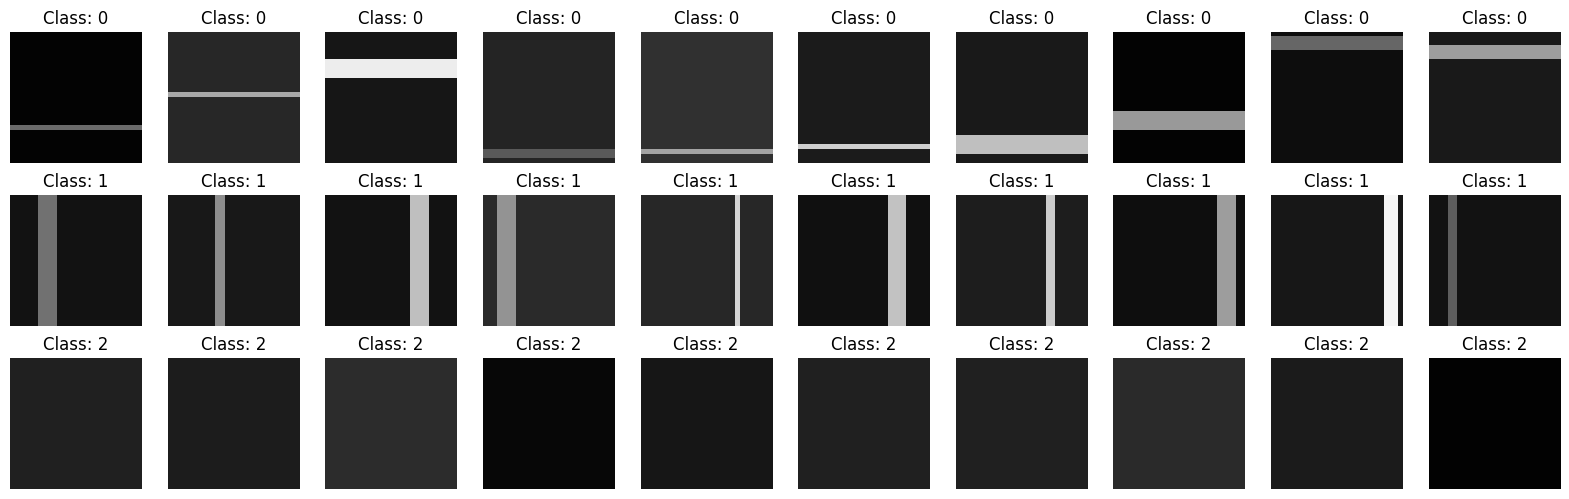

In [3]:
vis_dataset(visualize_dataset, num_classes=3, num_show_per_class=10)

### Q1. Overfitting Models to Small Dataset

In this problem, we will make our models overfit the small dataset to test the model architecture and our synthetic dataset. We use the same dataset for both models. Let's generate a small dataset with ten images per class. 

In [4]:
set_seed(seed)

small_dataset_config = None
small_dataset = None
transforms = T.Compose([T.ToTensor()])

#############################################################################
# TODO: Generate dataset with 10 images per class                           #
# Hint: Refer visualize_data_config                                         #
#############################################################################
pass
small_dataset_config = dict(
    data_per_class=10,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)
small_dataset = EdgeDetectionDataset(small_dataset_config, mode='train', transform=transforms)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In this notebook, we will use pytorch dataloader to load the dataset. We will use `torch.utils.data.DataLoader` to load the dataset. `DataLoader` takes two arguments: `dataset` and `batch_size`. `dataset` is the dataset that we want to load. Note that `batch_size` is one of important hyperparameters. We will use `batch_size=32` for this problem.

In [5]:
from random import shuffle


small_dataset_loader = None
batch_size = 32
#############################################################################
# TODO: Implement dataloader                                                #
# Hint: You should flag shuffle = True for training data loader             #
# This flag makes huge difference in training                               #
#############################################################################
pass
small_dataset_loader = torch.utils.data.DataLoader(small_dataset, batch_size, shuffle = True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### Model Architecture

MLP has two hidden layer with 10 hidden units and 10 hidden units. The input size is 28x28=784 and the output size is 3. We use ReLU as the activation function. We use cross entropy loss as the loss function. 

MLP architecture: FC(784, 10) -> ReLU -> FC(10, 10) -> ReLU -> FC(10, 3)

CNN has two convolutional layers followed by global average pooling and one fully connected layer. Both convolutional layers have 3 filters whose kernel size is 7. We use ReLU as the activation function. We use cross entropy loss as the loss function.

CNN arhitecture is as follows: CONV - RELU - MAXPOOL - CONV - RELU - MAXPOOL - FC

### Fitting on Small Dataset

Now let's train the model on the small dataset. The final tranining loss should be around 100% for both models.

In [6]:
set_seed(seed)

lr = 0.01
num_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn_model = SimpleCNN(kernel_size=7)
cnn_model.to(device)
untrained_cnn_model = deepcopy(cnn_model)

mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
mlp_model.to(device)

mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()
print("CNN Model has {} parameters".format(count_parameters(cnn_model, only_trainable=True)))
print("MLP Model has {} parameters".format(count_parameters(mlp_model, only_trainable=True)))

for epoch in tqdm(range(num_epochs)):
    train_one_epoch(cnn_model, cnn_optimizer, criterion, small_dataset_loader, device, epoch, verbose=False)
    train_one_epoch(mlp_model, mlp_optimizer, criterion, small_dataset_loader, device, epoch, verbose=False)

    _, cnn_acc, _ = evaluate(cnn_model, criterion, small_dataset_loader, device, verbose=False)
    _, mlp_acc, _ = evaluate(mlp_model, criterion, small_dataset_loader, device, verbose=False)

print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))

CNN Model has 606 parameters
MLP Model has 39793 parameters


100%|██████████| 500/500 [00:08<00:00, 56.89it/s]

CNN Acc: 100.0, MLP Acc: 100.0


We checked that both models can overfit the small dataset. This is one of the most important sanity check. If the model cannot overfit the small dataset, the model is not powerful enough to learn the dataset. In this case, we need to increase the size of the model. 

### Visualize Learned Filters

/home/cleverctz/berkeley/cs182_deeplearning/hw5/hw5/helpers/vis_helper.py:146: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap=cmap)


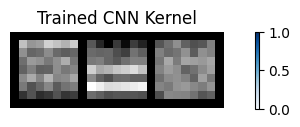

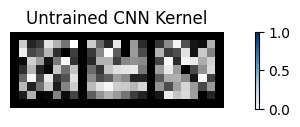

In [7]:
cnn_kernel = cnn_model.conv1.weight.data.clone().cpu()
untrained_kernel = untrained_cnn_model.conv1.weight.data.clone().cpu()

vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel')
vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel')


Q. Can you find any interesting patterns in the learned filters?

I find a set of horizontally distributed weights.

### Q2. Sweeping the Number of Training Images

We understood the given task and checked that both models had enough expressive power. We will compare the performance of MLP and CNN by changing the number of data per class. We expect that the model with proper inductive biases on this task will fit with **fewer training examples**. And let's see which one has inductive biases. In this problem, we will use the same dataset for both models. We sweep the number of training images from 10 to 50. The validation set will be the same for all the experiments.

In [4]:
set_seed(seed)

train_loader_dict = dict()
num_images_list = [10, 50, 100, 500]
valid_loader = None

transforms = T.Compose([T.ToTensor()])
train_batch_size = 10
valid_batch_size = 256
#############################################################################
# TODO: Implement train_loader_dict for each number of training images.     #
# Key: The number of training images (10, 50, 100, and 500)                 #
# Value: The corresponding dataloader                                       #
# The validation set size is 50 images per class                            #
#############################################################################
for i in num_images_list:
    dataset_config = dict(
    data_per_class=i,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)
    dataset = EdgeDetectionDataset(dataset_config, mode='train', transform=transforms)
    train_loader_dict[f'{i}'] = torch.utils.data.DataLoader(dataset, train_batch_size, shuffle = True)


valid_config = dict(
    data_per_class=50,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)
valid_dataset = EdgeDetectionDataset(valid_config, mode='valid', transform=transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, valid_batch_size, shuffle = True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [9]:
lr = 5e-3
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict() 

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_valid_acc_list = []
    mlp_valid_acc_list = []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, _ = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        mlp_valid_loss, mlp_valid_acc, _ = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

        cnn_valid_acc_list.append(cnn_valid_acc)
        mlp_valid_acc_list.append(mlp_valid_acc)
    
    cnn_kernel_dict[num_image] = deepcopy(cnn_model.conv1.weight.cpu().detach())
    untrained_cnn_kernel_dict[num_image] = deepcopy(untrained_cnn_model.conv1.weight.cpu().detach())
    
    cnn_acc = cnn_valid_acc_list[-1]
    mlp_acc = mlp_valid_acc_list[-1]
    
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))
    cnn_acc_list.append(cnn_acc)
    mlp_acc_list.append(mlp_acc)

Training with 10 images


100%|██████████| 100/100 [00:05<00:00, 18.49it/s]


CNN Acc: 64.66666666666667, MLP Acc: 55.333333333333336
Training with 50 images


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


CNN Acc: 95.33333333333333, MLP Acc: 81.33333333333333
Training with 100 images


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


CNN Acc: 96.0, MLP Acc: 90.66666666666667
Training with 500 images


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

CNN Acc: 96.0, MLP Acc: 94.66666666666667


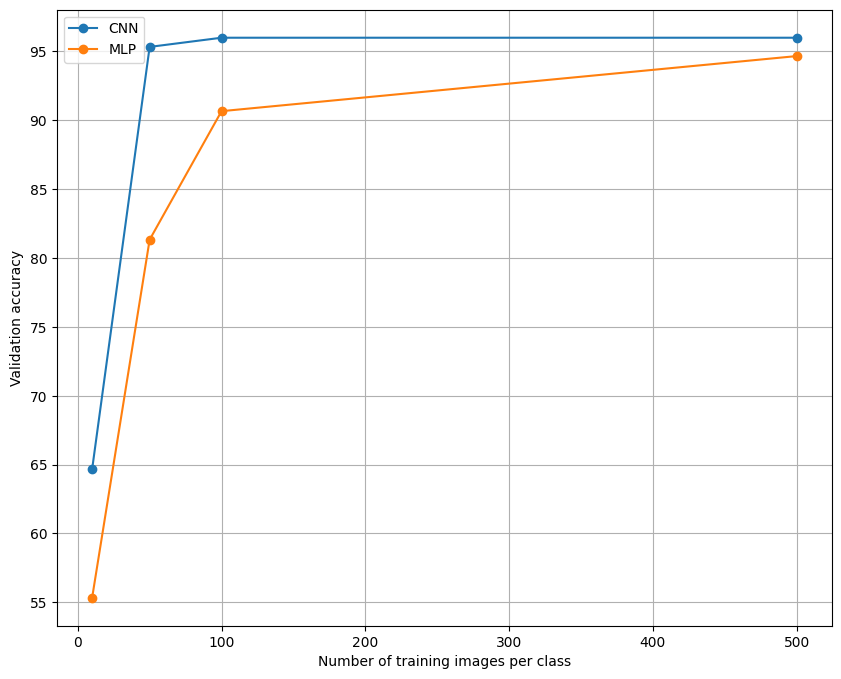

In [10]:
## Plot the validation accuracy
plt.plot(num_images_list, cnn_acc_list, marker='o', label='CNN')
plt.plot(num_images_list, mlp_acc_list, marker='o', label='MLP')
plt.xlabel('Number of training images per class')
plt.ylabel('Validation accuracy')
plt.legend()
plt.grid()
plt.show()

OK, in most cases, CNN looks like it is performing better than MLP. So can we conclude that CNN has the inductive biases of locality and translational invariance? Not yet. We need to conduct a series of other experiments to show that CNN has such inductive biases. 



Seemingly, the experiment result is odd. First, the performance of the low data regime ```num_train_images_per_class=10``` is very bad, considering the task is straightforward. Second, some students will observe that the performance of MLP is better than CNN at some point. At least, CNN should be much better even in a small data regime if it is translational equivariant. How do we debug the model? We will study how to debug the model in the following problem.

Here are some checklists that you can do to debug the problem.

1. Did you check the dataset? For example, is the dataset balanced? Is the dataset noisy? Is the dataset too small?
2. Did you check the model architecture? For example, is the model architecture powerful enough to learn the dataset? Is the model architecture too complex? Is the model architecture too simple?
3. Did you check the model initialization? For example, is the model initialized properly? Is the model initialized randomly? Is the model initialized with the pre-trained weights?
4. Did you check that the model is trained correctly? For example, does the kernel look like an edge detector? What would be the performance of CNN if kernels were initialized with edge detectors?
5. Did you check the training procedure? For example, is the training procedure correct? Is the training procedure stable? Is the training procedure too slow?
6. Did you optimize the hyperparameters? For example, learning rate, batch size, and the number of epochs.

Note that we already checked the dataset, initialization, and model architecture. But we didn't check the step after 3. Let's step 4 first. We will first see what the learned weights look like, initialize the kernels with edge detectors, and see what happens.

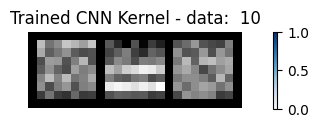

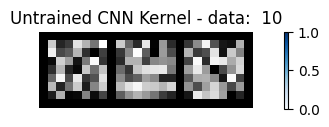

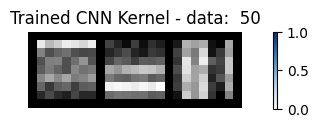

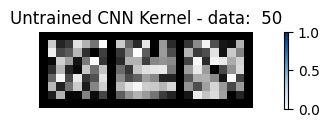

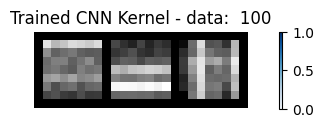

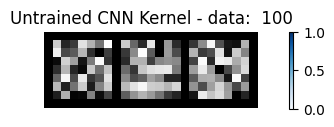

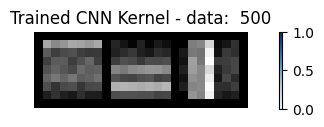

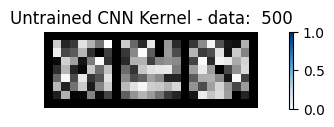

In [11]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel - data:  {}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel - data:  {}'.format(num_image))

Q. Compare the learned kernels, untrainable kernels, and edge-detector kernels. What do you observe?

One learned kernel's weight distribution is horizontal.
Another one is vertical.

Visualized kernels seem very odd. Some kernels look randomly generated. Think about the data generating process. The factor determining this dataset is the edge location, edge width, and the intensities of background and edges. Therefore, we might be able to get kernels that look like edge detectors. Then, the next logical question should be, what if kernels are initialized with edge detectors? How would the performance change? Because we inject the additional inductive biases into the model. We expect the validation accuracy to be much better and with fewer training examples. Let's try it.

### Injecting Inductive Bias: Initialize Kernels with Edge Detectors

In [12]:
lr = 0.05
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

edge_init_cnn_acc_list = list()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    cnn_model = SimpleCNN(kernel_size=2)
    init_conv_kernel_with_edge_detector(cnn_model)
    freeze_conv_layer(cnn_model)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)


    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    edge_init_cnn_valid_acc_list = []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        cnn_valid_loss, cnn_valid_acc, _ = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        edge_init_cnn_valid_acc_list.append(cnn_valid_acc)
    
    cnn_acc = edge_init_cnn_valid_acc_list[-1]
    
    print("CNN Acc: {}".format(cnn_acc))
    edge_init_cnn_acc_list.append(cnn_acc)


Training with 10 images


100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


CNN Acc: 83.33333333333333
Training with 50 images


100%|██████████| 100/100 [00:04<00:00, 20.52it/s]


CNN Acc: 85.33333333333333
Training with 100 images


100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


CNN Acc: 85.33333333333333
Training with 500 images


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]

CNN Acc: 85.33333333333333


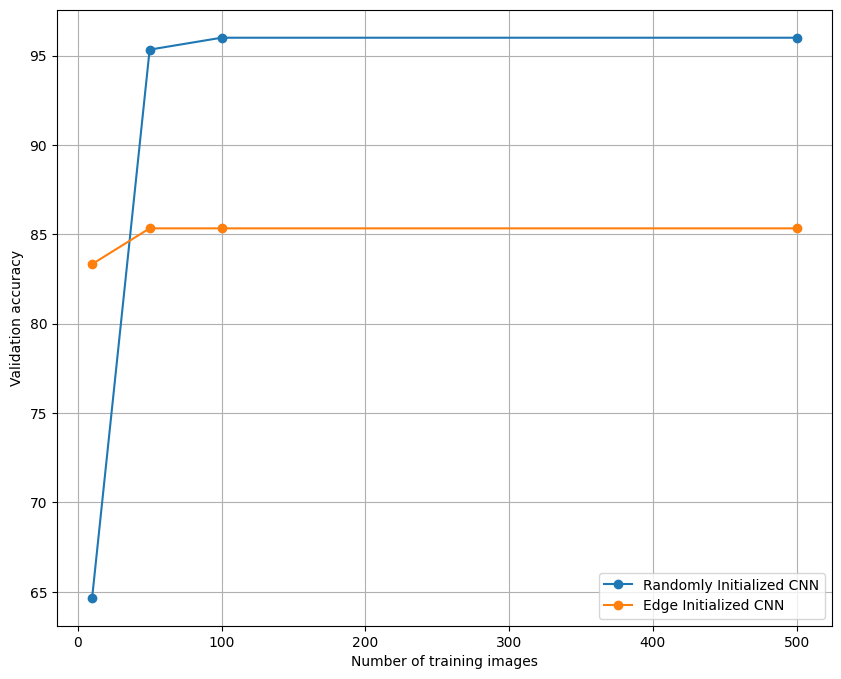

In [13]:
## Plot the validation accuracy
plt.plot(num_images_list, cnn_acc_list, marker='o', label='Randomly Initialized CNN')
plt.plot(num_images_list, edge_init_cnn_acc_list, marker='o', label='Edge Initialized CNN')
plt.xlabel('Number of training images')
plt.ylabel('Validation accuracy')
plt.legend()
plt.grid()
plt.show()

As you can see in the above graph, the performance of CNN initialized with edge detectors is much better than CNN initialized with random weights. It is a significant observation, especially in a low data regime. Now we have to check the training procedure.

Q. We freeze the convolutional layer and train only final layer (classifier) in this experiment. For a high data regime, the performance of CNN initialized with edge detectors is worse than CNN initialized with random weights. Why do you think this happens?

The dataset is large enough for classification task. 
Detectation initialization will become the bottomneck of the task. If it the edge is wrongly detected, definitely the picture won't be correctly classified

### Q3. Checking the Training Procedure

Checking the training procedure is very important. We must log at least training loss, training accuracy, validation loss, and validation accuracy. Let's log such training signals and find out what is going on.

Training with 10 images


100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


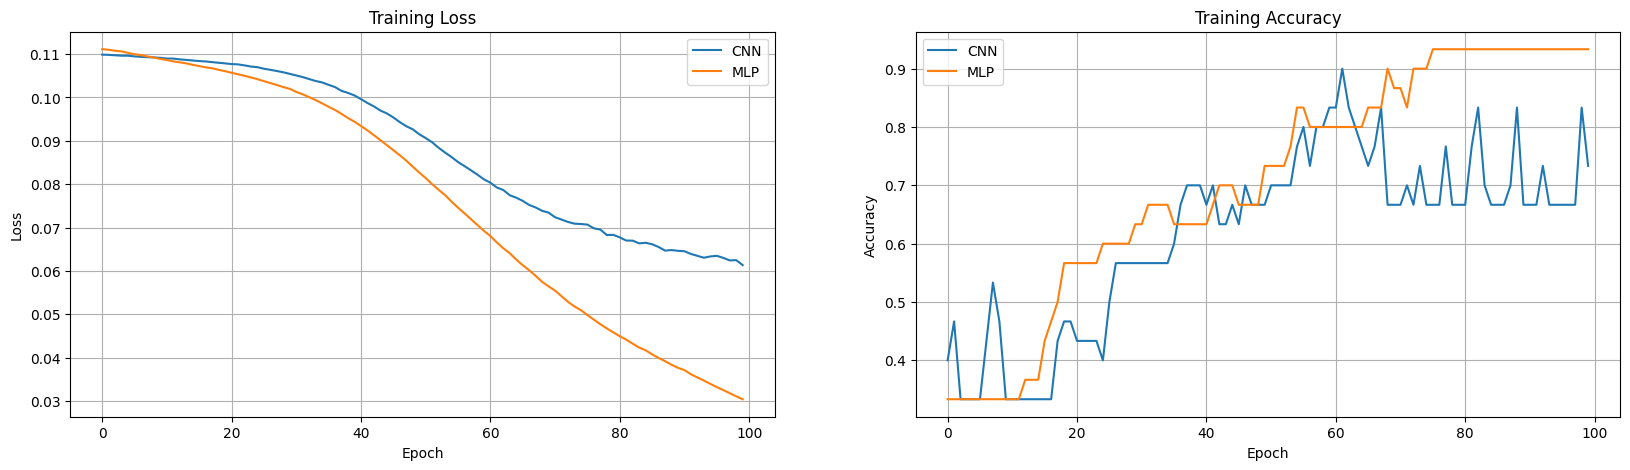

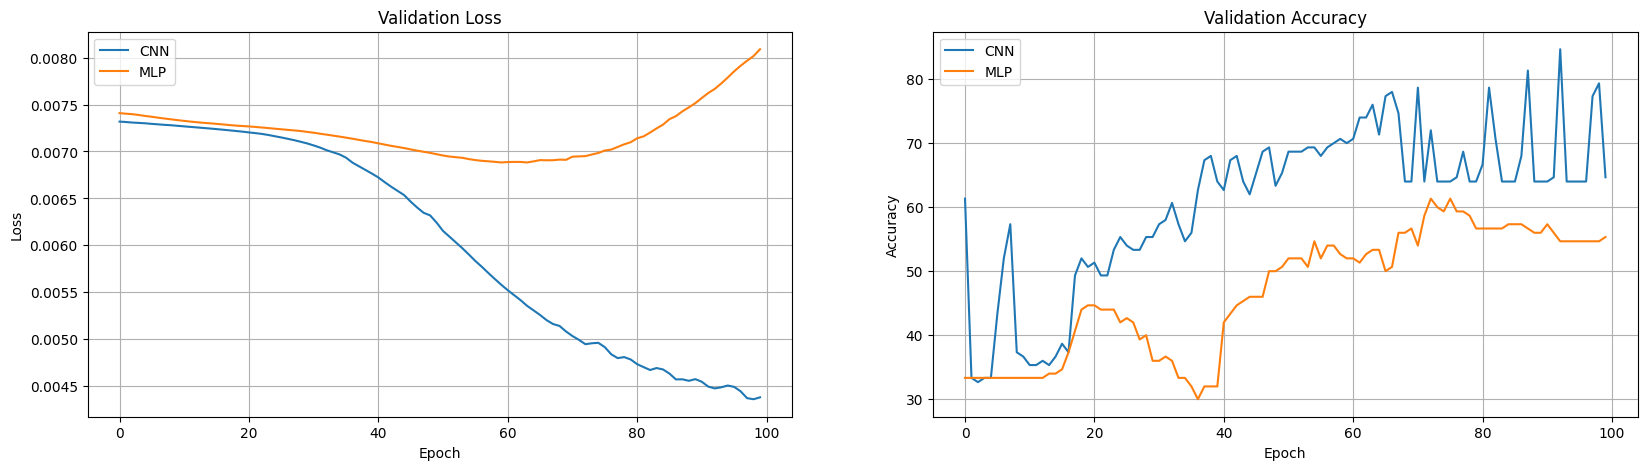

CNN Acc: 64.66666666666667, MLP Acc: 55.333333333333336
Training with 50 images


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


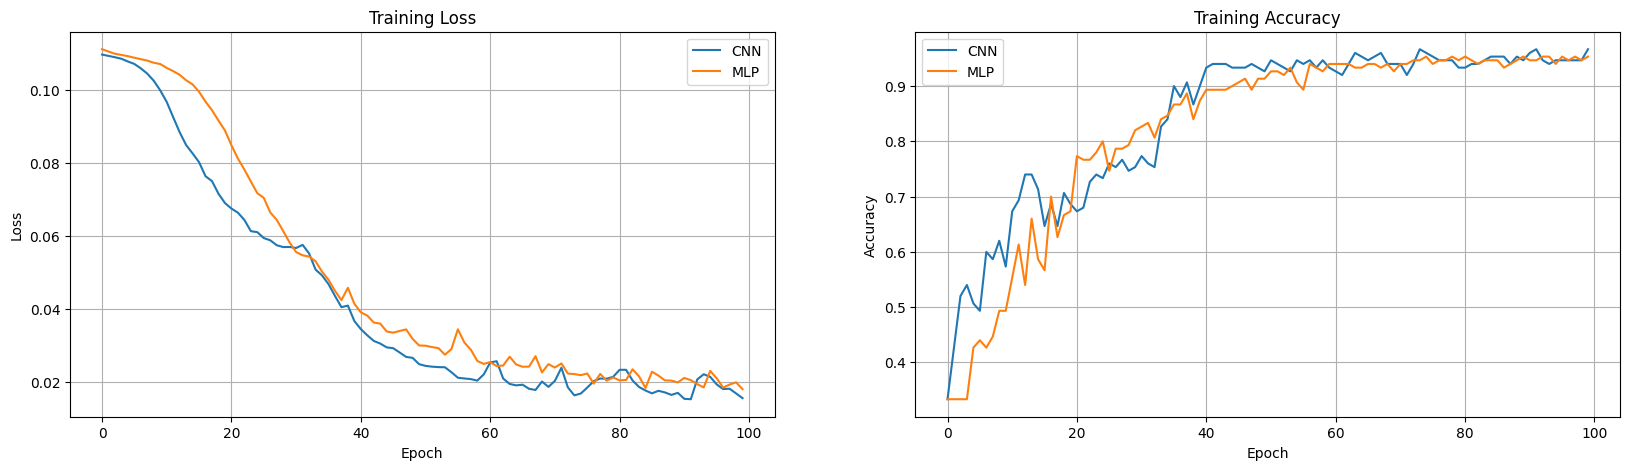

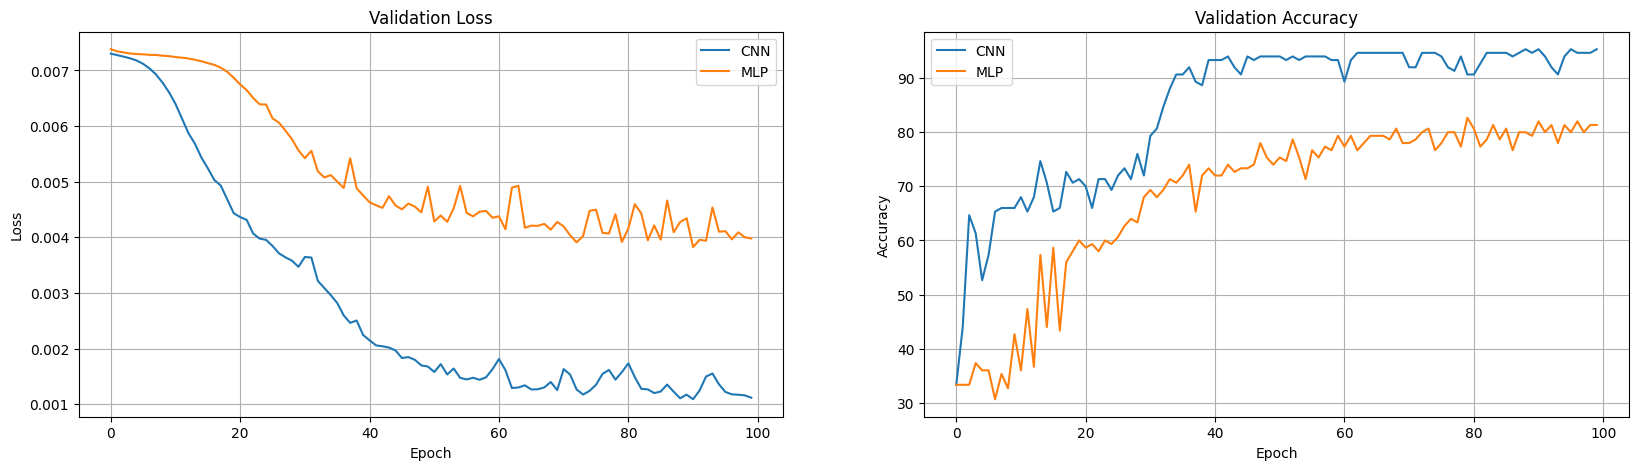

CNN Acc: 95.33333333333333, MLP Acc: 81.33333333333333
Training with 100 images


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


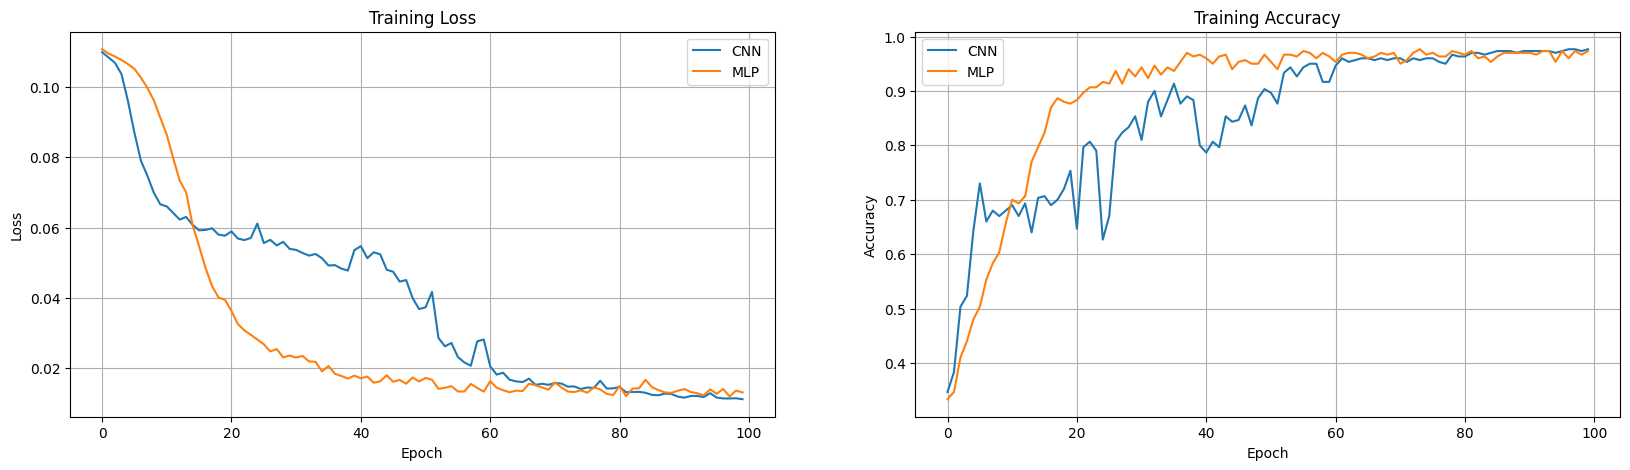

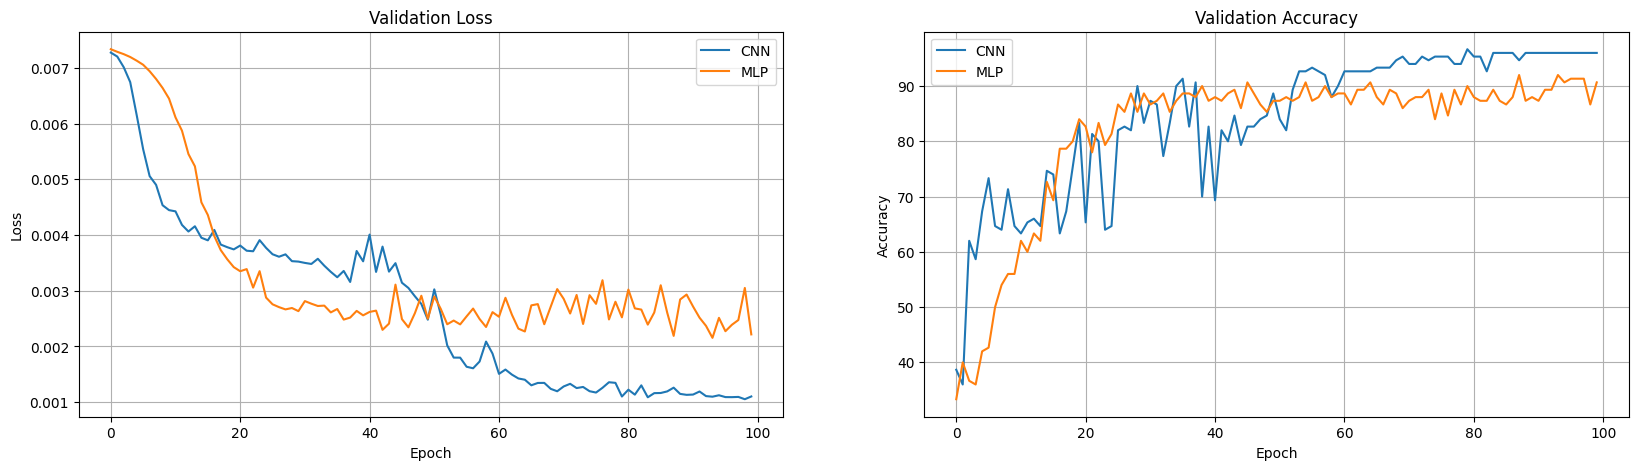

CNN Acc: 96.0, MLP Acc: 90.66666666666667
Training with 500 images


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


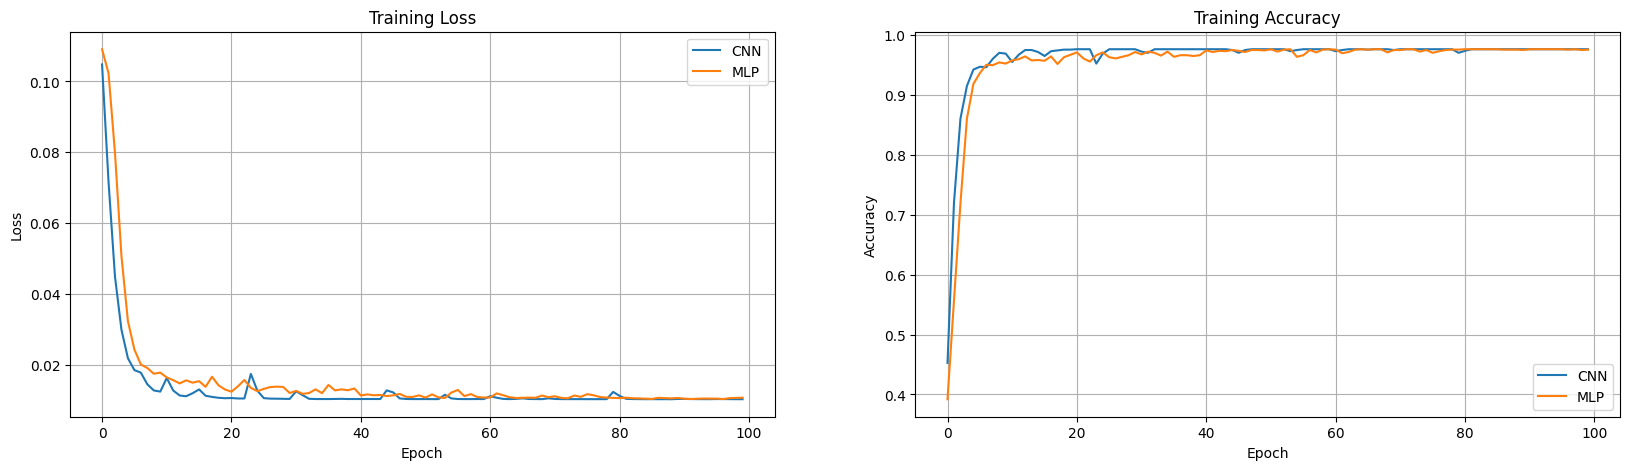

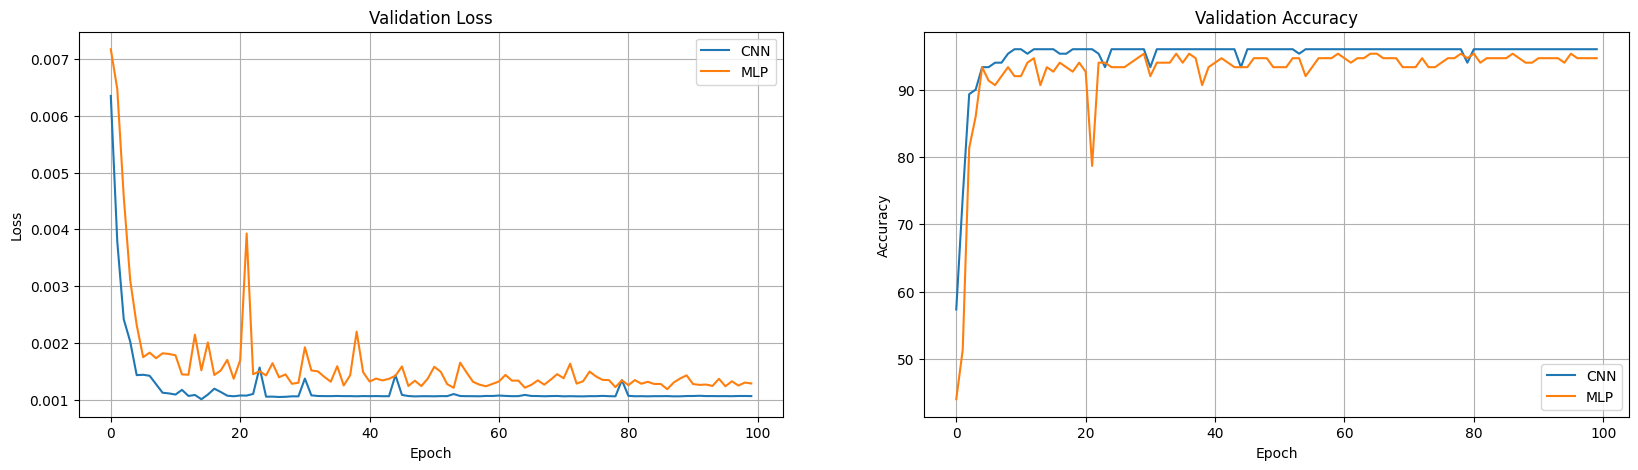

CNN Acc: 96.0, MLP Acc: 94.66666666666667


In [14]:
lr = 5e-3
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict() 

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    mlp_train_acc_list, mlp_valid_acc_list, mlp_train_loss_list, mlp_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, _ = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        mlp_valid_loss, mlp_valid_acc, _ = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        mlp_train_acc_list.append(mlp_train_acc)
        mlp_valid_acc_list.append(mlp_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
        mlp_train_loss_list.append(mlp_train_loss)
        mlp_valid_loss_list.append(mlp_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, mlp_train_loss_list, mlp_train_acc_list)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, mlp_valid_loss_list, mlp_valid_acc_list)

    cnn_acc = cnn_valid_acc_list[-1]
    mlp_acc = mlp_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.data.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.data.detach().cpu()
    
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))
    cnn_acc_list.append(cnn_acc)
    mlp_acc_list.append(mlp_acc)

What is going on here? Validation loss and validation accuracy are not flat at the end. It means that the model is not converged. We need to train the model more. Let's train the model with the higher number of epochs. Increase the number of epochs until the validation loss and accuracy are flat. 

Q. List every epochs that you trained the model. Final accuracy of CNN should be at least 90% for 20 images per class. Final accuracy of MLP should be at least 80% for 10 images per class.

Q. Check the learned kernels. What do you observe?

Q. (optional) You might find that with the high number of epochs, validation loss of MLP is increasing whild validation accuracy increasing. How can we interpret this? (Hint: Refer to this [paper](https://arxiv.org/pdf/1706.04599.pdf]))

Q. (optional) Do hyperparameter tuning. And list the best hyperparameter setting that you found and report the final accuracy of CNN and MLP.

Epochs: 100, 300, 400, 430, 500
epochs = 400, best behavior

One learned kernel's weight distribution is horizontal.
Another one is vertical.

Training with 10 images


100%|██████████| 400/400 [00:22<00:00, 17.84it/s]


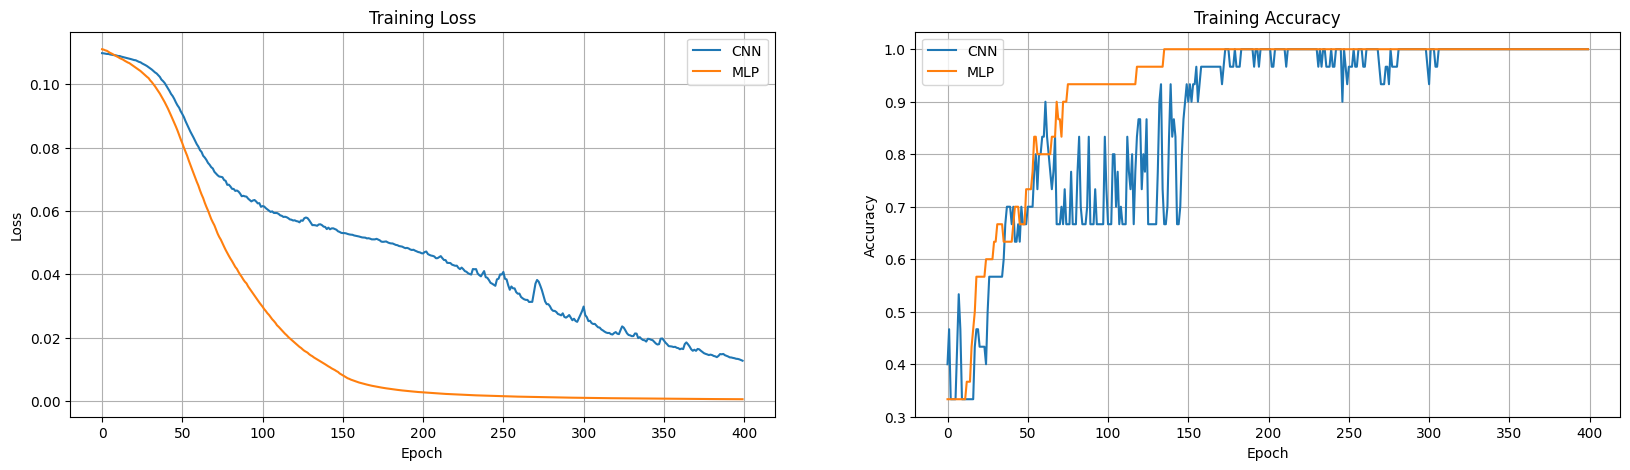

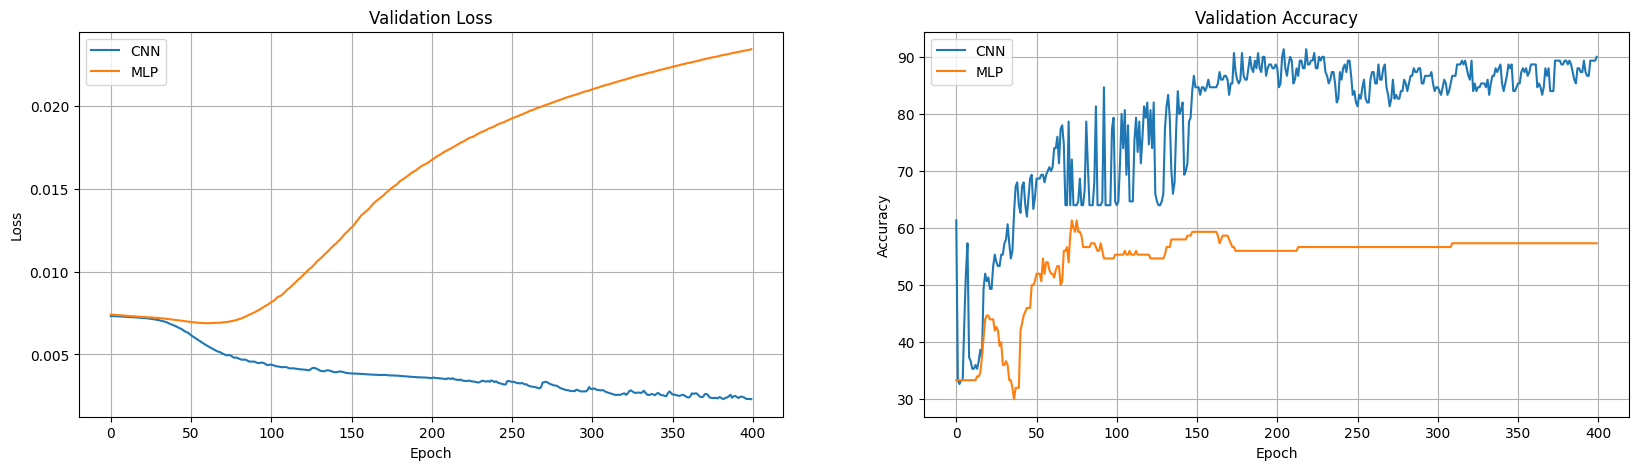

CNN Acc: 90.0, MLP Acc: 57.333333333333336
Training with 50 images


100%|██████████| 400/400 [00:47<00:00,  8.42it/s]


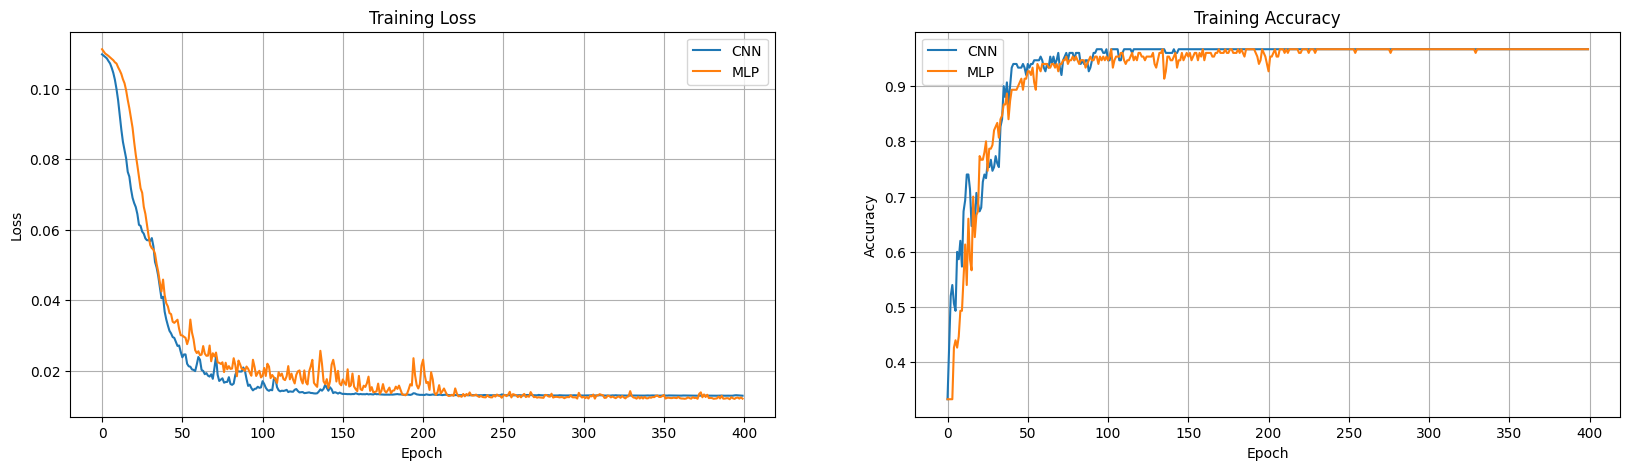

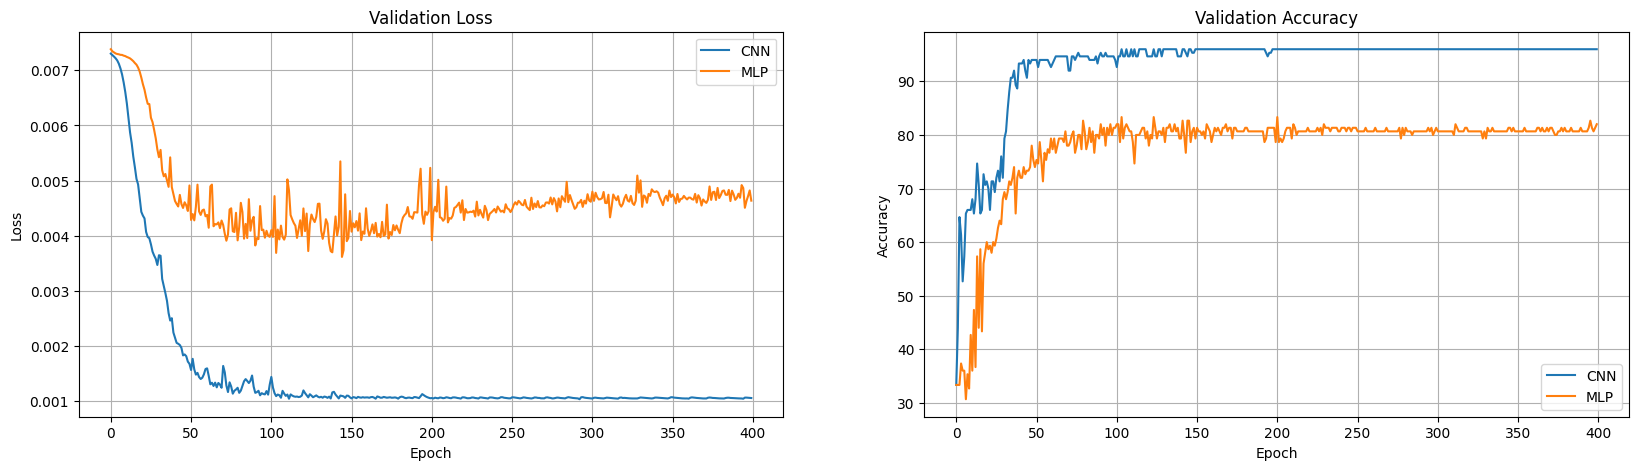

CNN Acc: 96.0, MLP Acc: 82.0
Training with 100 images


100%|██████████| 400/400 [01:18<00:00,  5.07it/s]


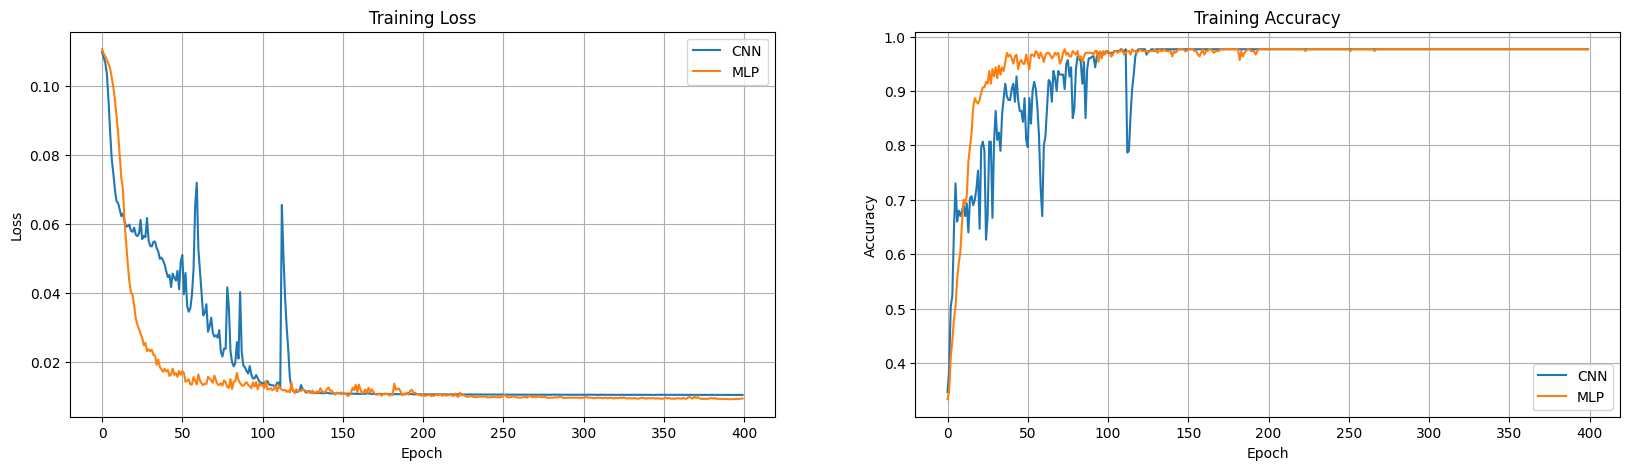

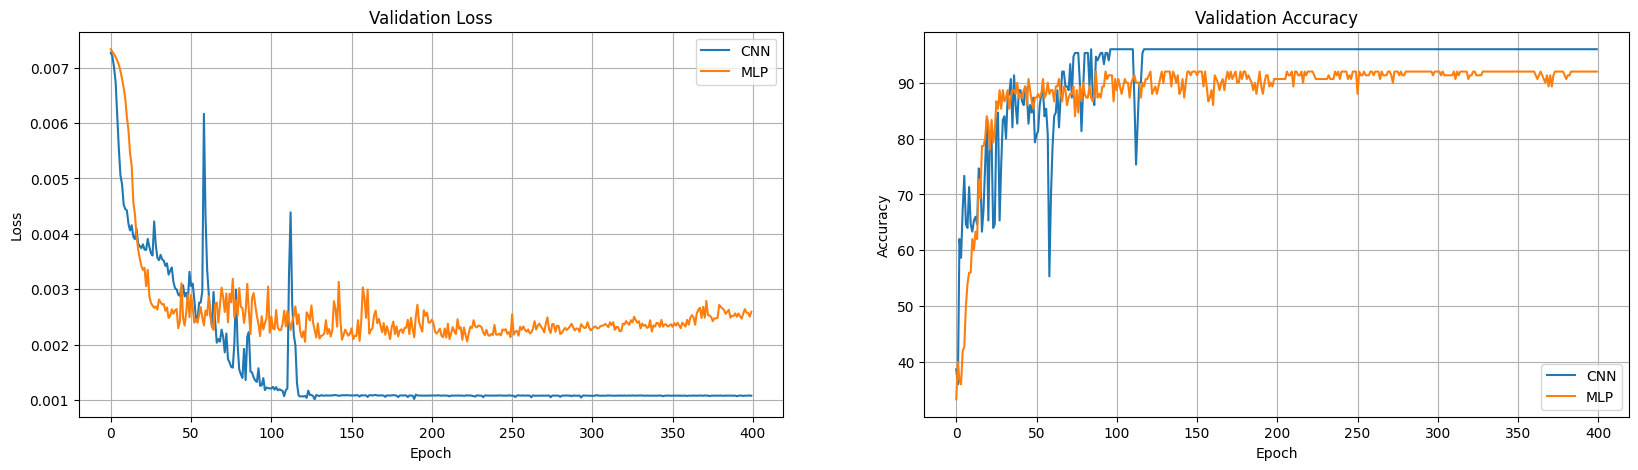

CNN Acc: 96.0, MLP Acc: 92.0
Training with 500 images


100%|██████████| 400/400 [05:19<00:00,  1.25it/s]


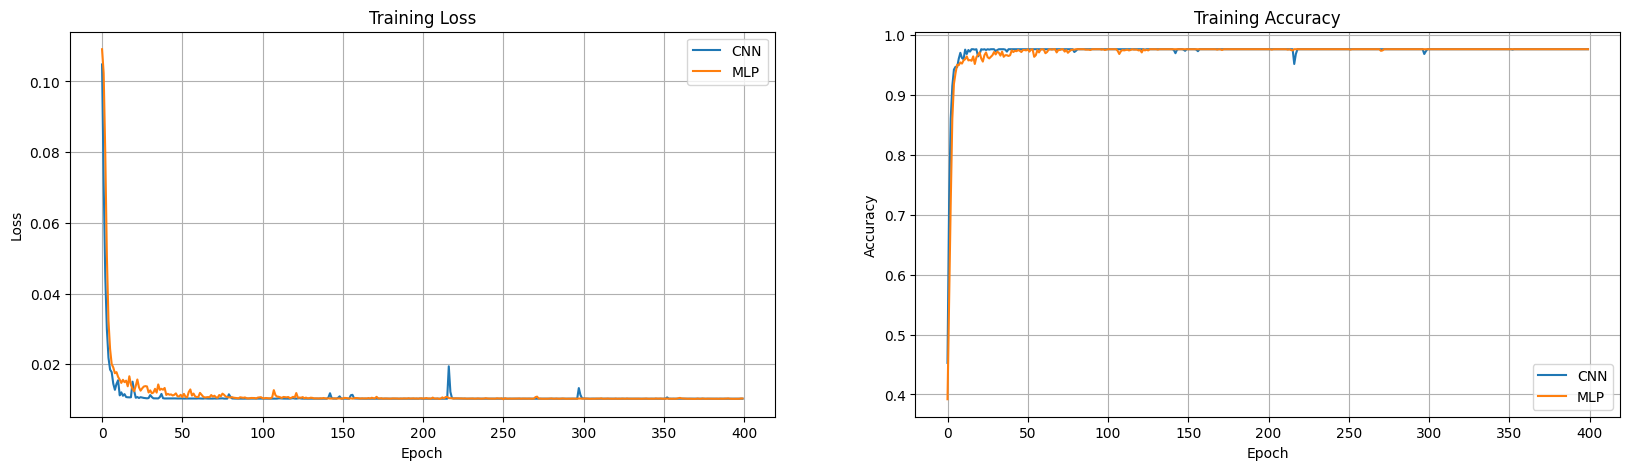

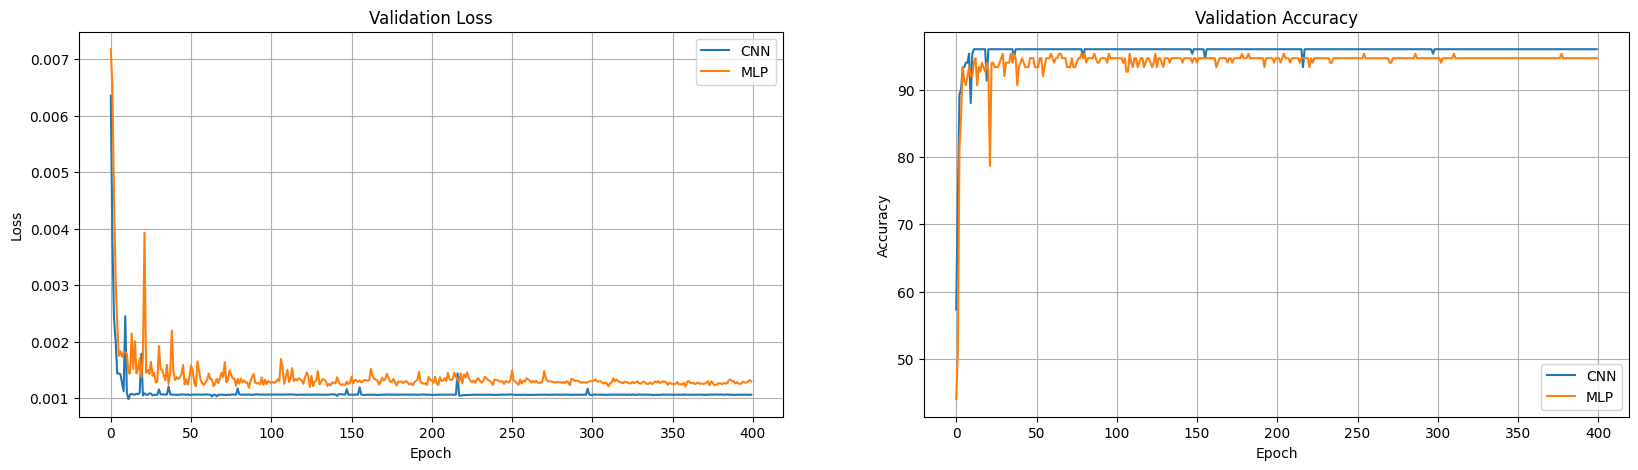

CNN Acc: 96.0, MLP Acc: 94.66666666666667


In [5]:
#############################################################################
# TODO: Try other num_epochs. Final accuracy of CNN should be at least      #
# 90% for 10 images per class.                                              #
#############################################################################
num_epochs = 400
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
lr = 5e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict() 

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    mlp_train_acc_list, mlp_valid_acc_list, mlp_train_loss_list, mlp_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, _ = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        mlp_valid_loss, mlp_valid_acc, _ = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        mlp_train_acc_list.append(mlp_train_acc)
        mlp_valid_acc_list.append(mlp_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
        mlp_train_loss_list.append(mlp_train_loss)
        mlp_valid_loss_list.append(mlp_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, mlp_train_loss_list, mlp_train_acc_list)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, mlp_valid_loss_list, mlp_valid_acc_list)

    cnn_kernel_dict[num_image] = deepcopy(cnn_model.conv1.weight.data.detach().cpu())
    untrained_cnn_kernel_dict[num_image] = deepcopy(untrained_cnn_model.conv1.weight.data.detach().cpu())

    cnn_acc = cnn_valid_acc_list[-1]
    mlp_acc = mlp_valid_acc_list[-1]
    
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))
    cnn_acc_list.append(cnn_acc)
    mlp_acc_list.append(mlp_acc)

/home/cleverctz/berkeley/cs182_deeplearning/hw5/hw5/helpers/vis_helper.py:146: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap=cmap)


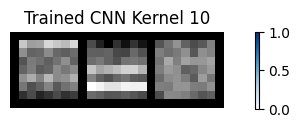

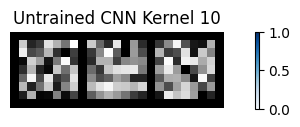

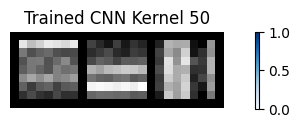

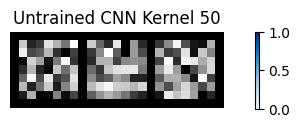

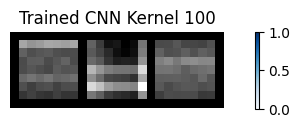

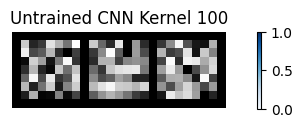

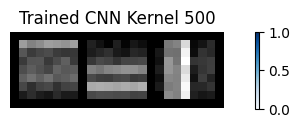

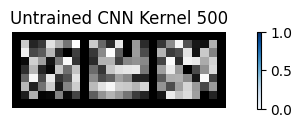

In [6]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel {}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel {}'.format(num_image))

Q. How much more data is needed for MLP to get a competitive performance with CNN? Does MLP really generalize or memorize?


MLP needs class of 500 to achieve competitive behavior.
MLP doesn't.

### Q4. Domain Shift between Training and Validation Set

In this problem, we will see how the model performance changes when the domain of the training set and that of the validation set are different. We will generate training set images with edges that locate only half of the image and validation set images with edges that locate only the other half of the image. Let's repeat the same experiment as the previous problem.

In [7]:
set_seed(seed)
train_loader_dict = dict()
num_train_images_list = [10, 50, 100, 500]
possible_edge_location_ratio = 0.5
valid_loader = None

transforms = T.Compose([T.ToTensor()])
batch_size = 10
#############################################################################
# TODO: Implement train_loader_dict for each number of training images.     #
# Key: The number of training images (10, 50, 100, and 500)                 #
# Value: The corresponding dataloader                                       #
# The validation set size is 50 images per class                            #
# Hint: You can use the same code as above                                  #
# Hint: Pass possible_edge_location_ratio arguments to domain_config        #
# Hint: possible_edge_location_ratio is 0.5                                 #
#############################################################################
for i in num_images_list:
    dataset_config = dict(
    data_per_class=i,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
    possible_edge_location_ratio=0.5  
)
    dataset = EdgeDetectionDataset(dataset_config, mode='train', transform=transforms)
    train_loader_dict[f'{i}'] = torch.utils.data.DataLoader(dataset, train_batch_size, shuffle = True)


valid_config = dict(
    data_per_class=50,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
    possible_edge_location_ratio=0.5
)
valid_dataset = EdgeDetectionDataset(valid_config, mode='valid', transform=transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, valid_batch_size, shuffle = True)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

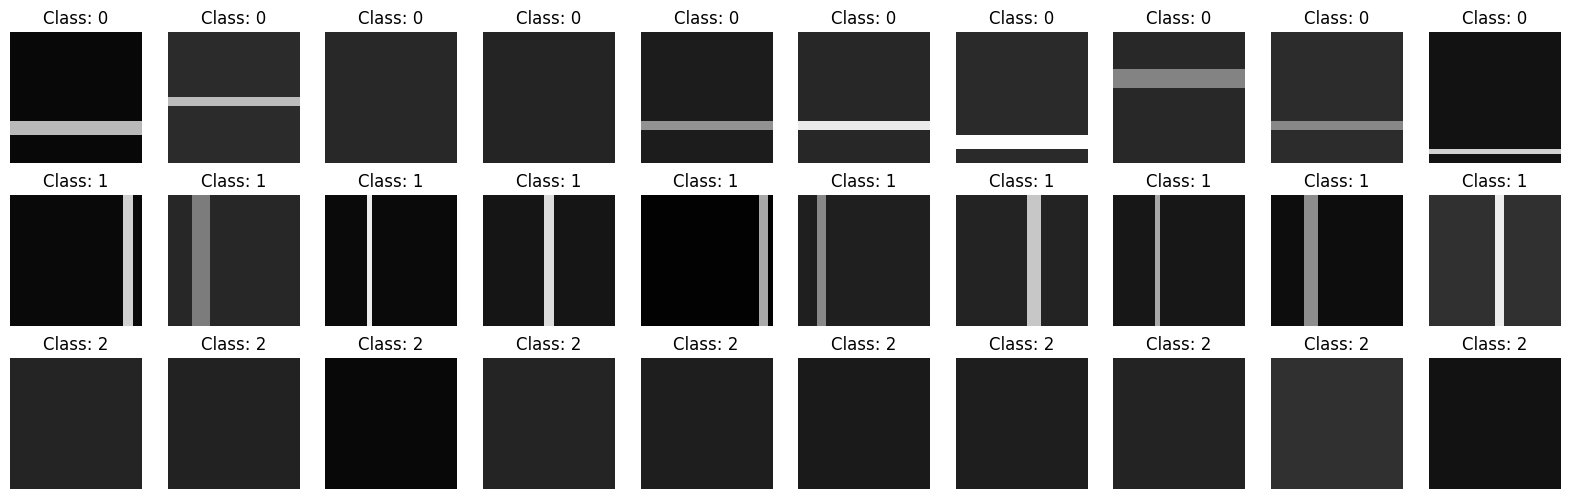

In [28]:
visualize_data_config = dict(
    data_per_class=10,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)

visualize_dataset = EdgeDetectionDataset(visualize_data_config, mode='train', transform=None)
vis_dataset(visualize_dataset, num_classes=3, num_show_per_class=10)

Training with 10 images


100%|██████████| 300/300 [00:16<00:00, 18.27it/s]


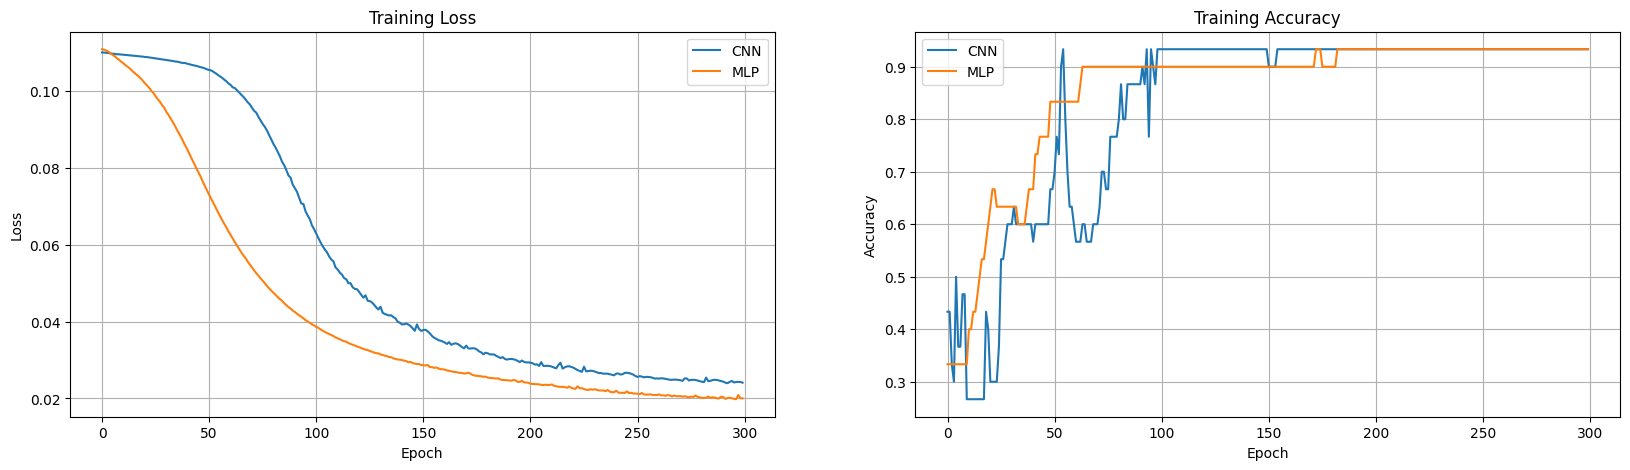

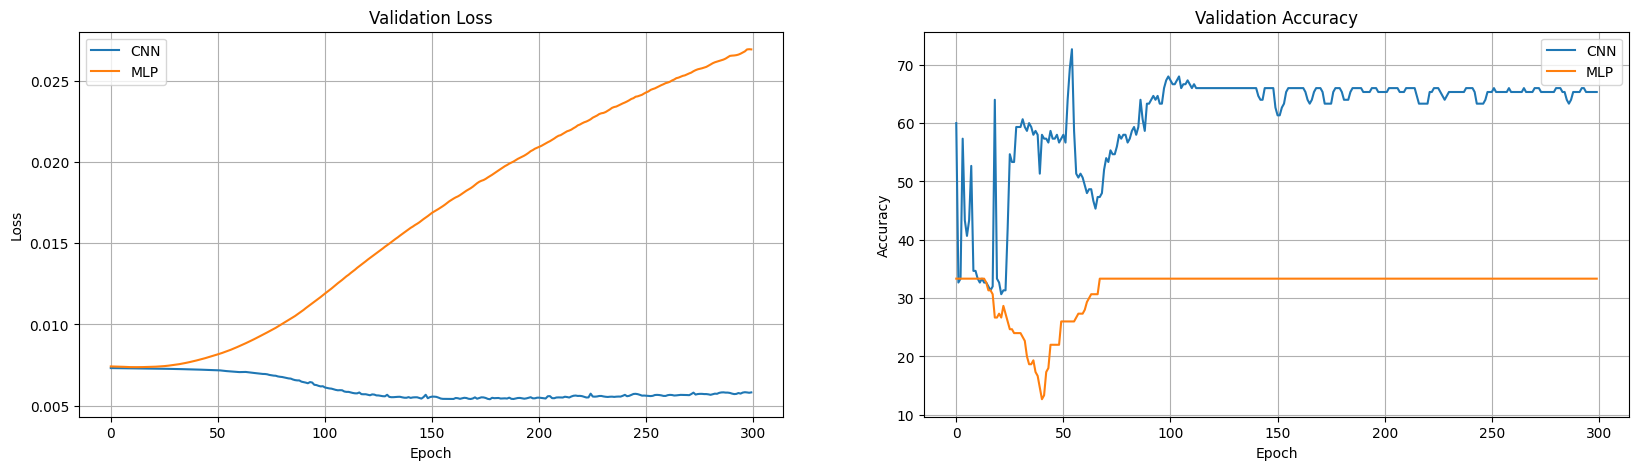

CNN Acc: 65.33333333333333, MLP Acc: 33.333333333333336
Training with 50 images


100%|██████████| 300/300 [00:34<00:00,  8.61it/s]


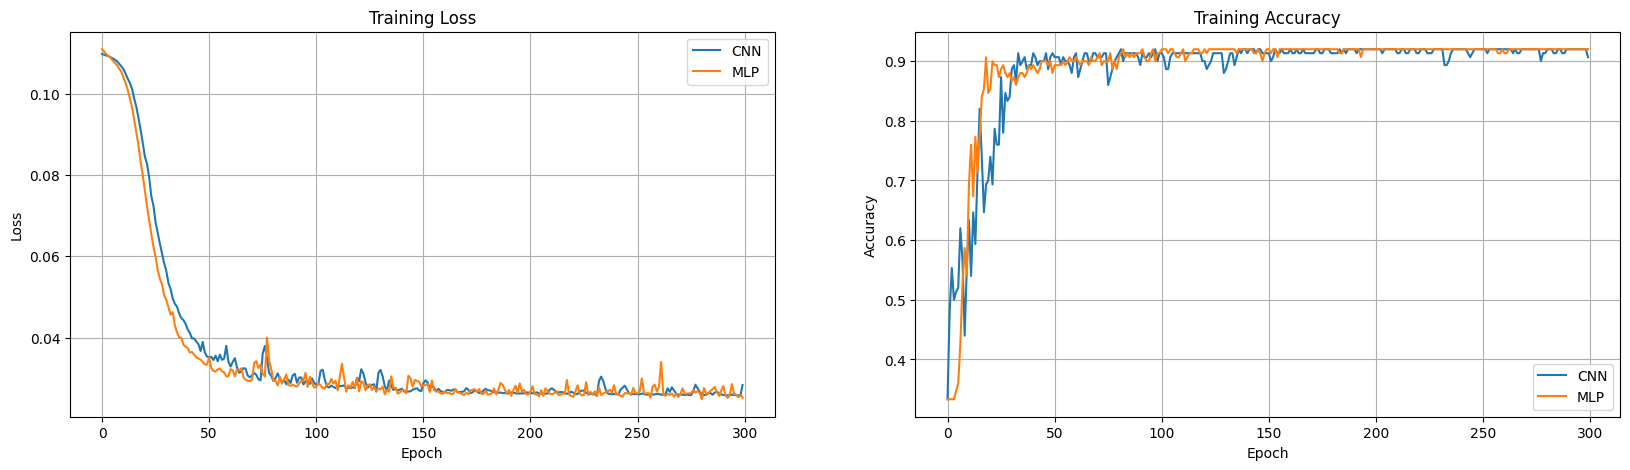

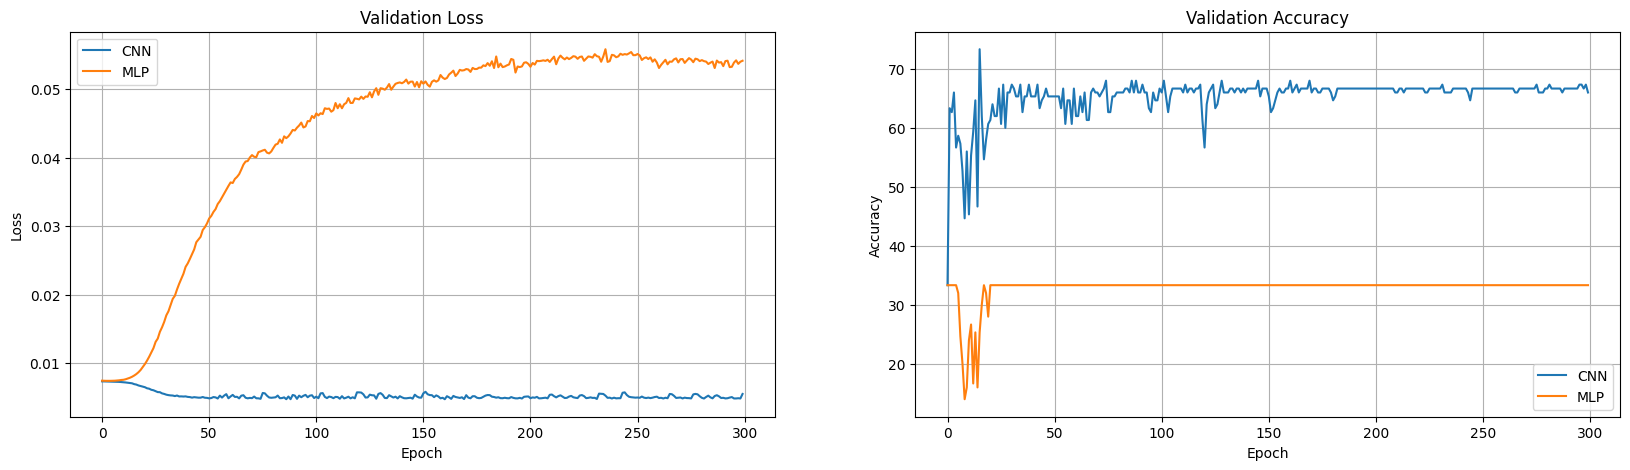

CNN Acc: 66.0, MLP Acc: 33.333333333333336
Training with 100 images


100%|██████████| 300/300 [00:57<00:00,  5.18it/s]


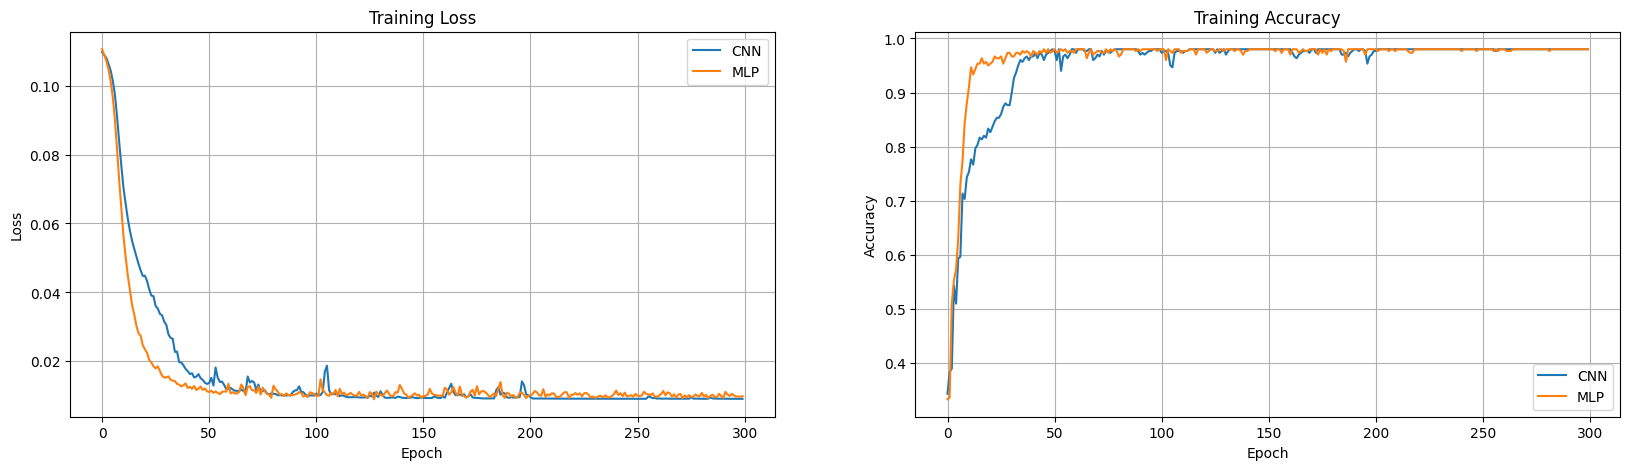

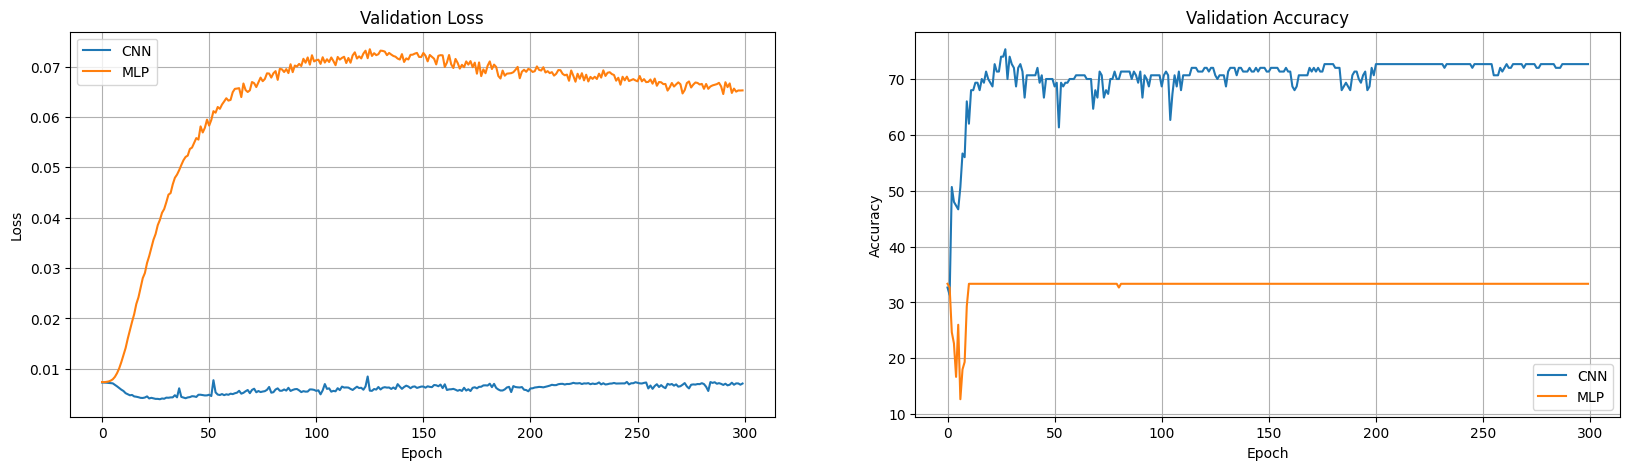

CNN Acc: 72.66666666666667, MLP Acc: 33.333333333333336
Training with 500 images


100%|██████████| 300/300 [04:02<00:00,  1.24it/s]


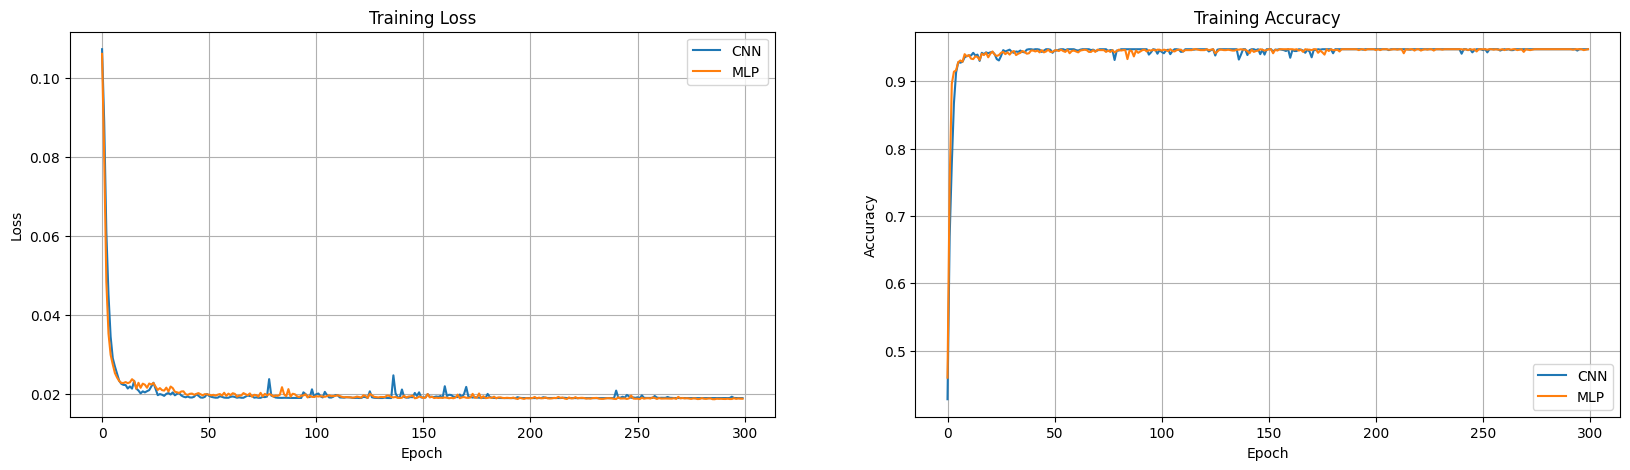

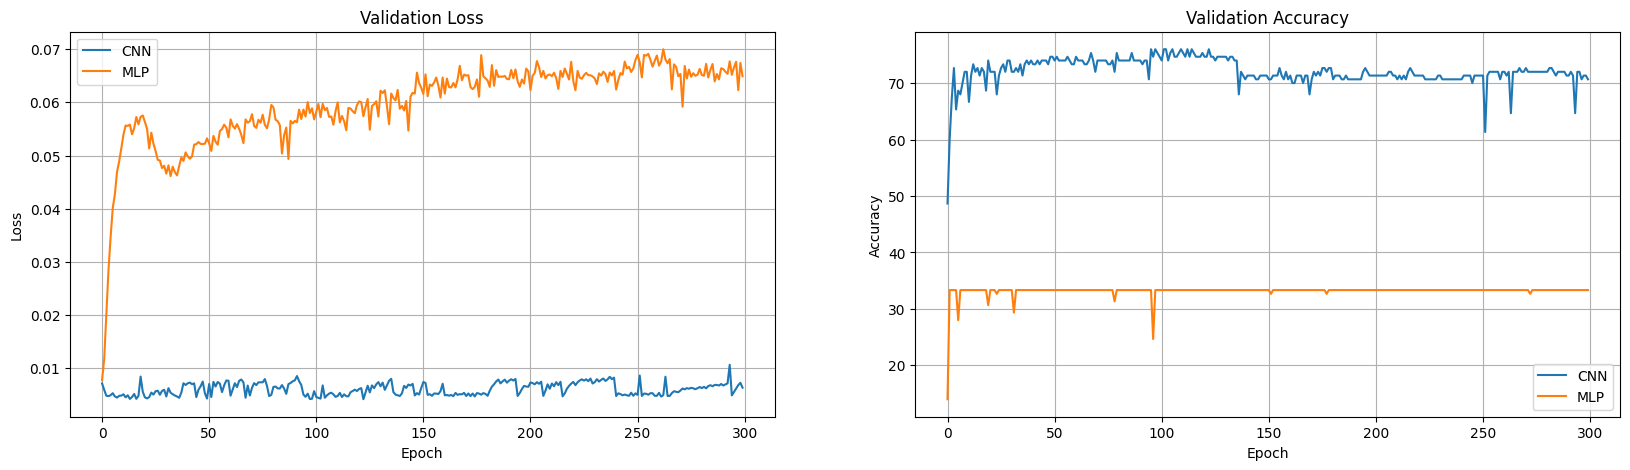

CNN Acc: 70.66666666666667, MLP Acc: 33.333333333333336


In [8]:
lr = 3e-3
num_epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict() 

cnn_confusion_matrix_dict = dict()
mlp_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    mlp_train_acc_list, mlp_valid_acc_list, mlp_train_loss_list, mlp_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, cnn_confusion_matrix = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        mlp_valid_loss, mlp_valid_acc, mlp_confusion_matrix = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        mlp_train_acc_list.append(mlp_train_acc)
        mlp_valid_acc_list.append(mlp_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
        mlp_train_loss_list.append(mlp_train_loss)
        mlp_valid_loss_list.append(mlp_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, mlp_train_loss_list, mlp_train_acc_list)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, mlp_valid_loss_list, mlp_valid_acc_list)

    cnn_acc = cnn_valid_acc_list[-1]
    mlp_acc = mlp_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = deepcopy(cnn_model.conv1.weight.detach().cpu())
    untrained_cnn_kernel_dict[num_image] = deepcopy(untrained_cnn_model.conv1.weight.detach().cpu())

    cnn_confusion_matrix_dict[num_image] = cnn_confusion_matrix
    mlp_confusion_matrix_dict[num_image] = mlp_confusion_matrix
    
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))
    cnn_acc_list.append(cnn_acc)
    mlp_acc_list.append(mlp_acc)

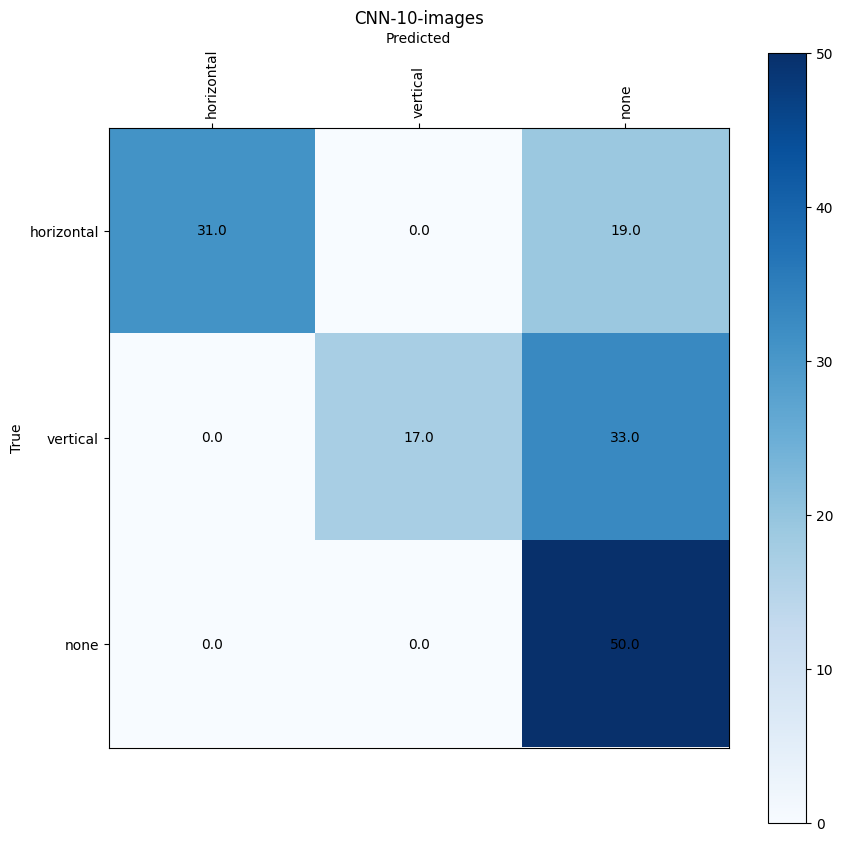

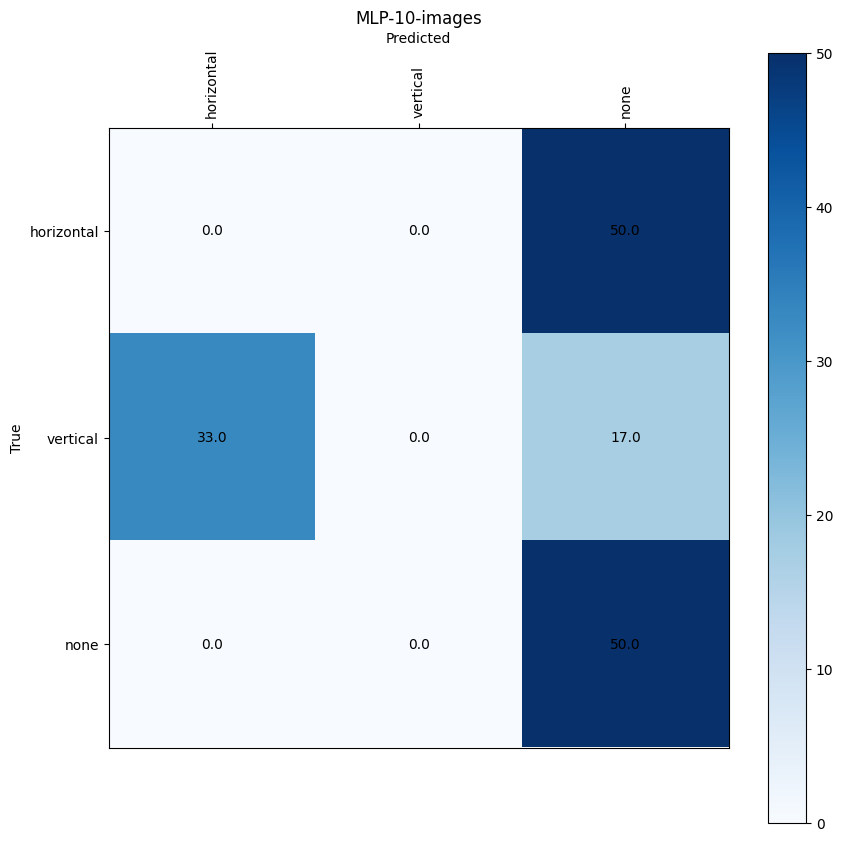

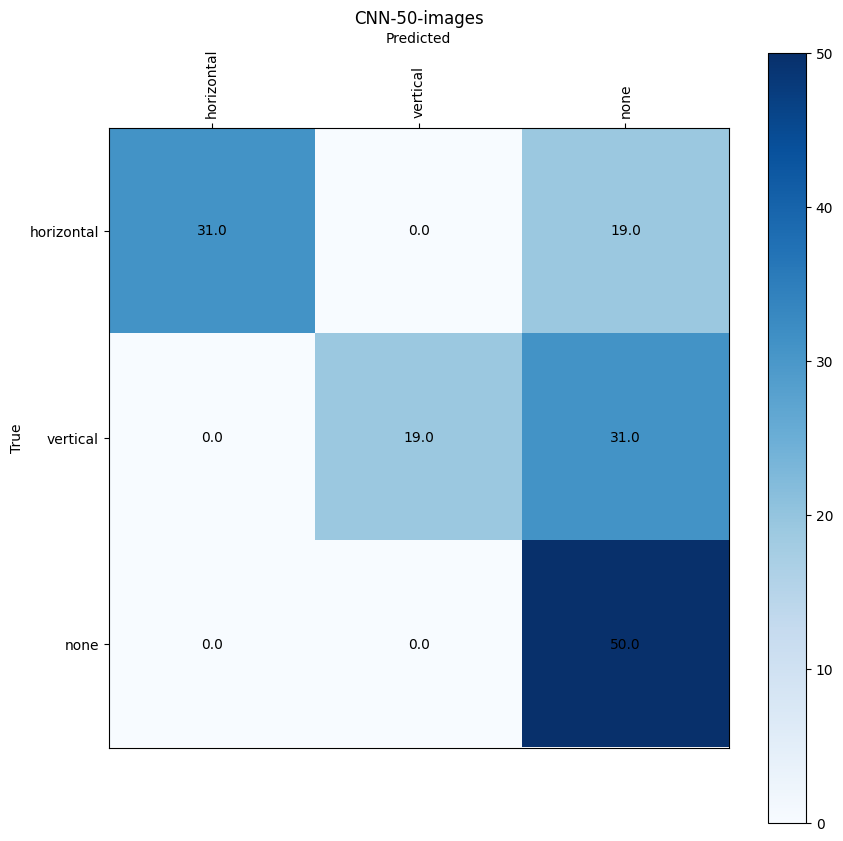

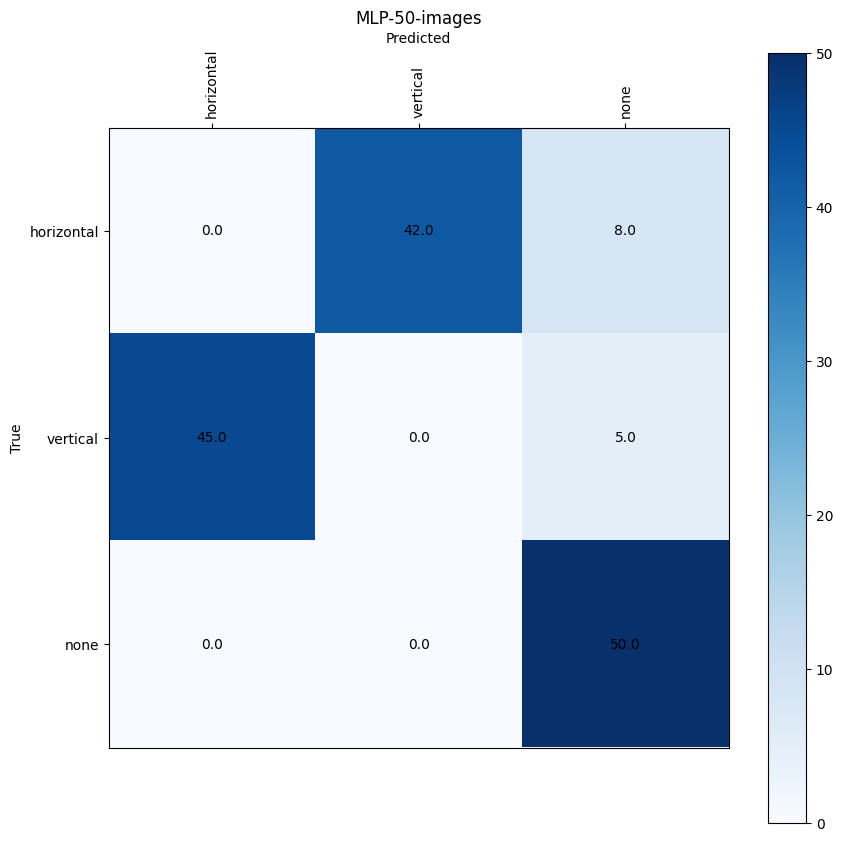

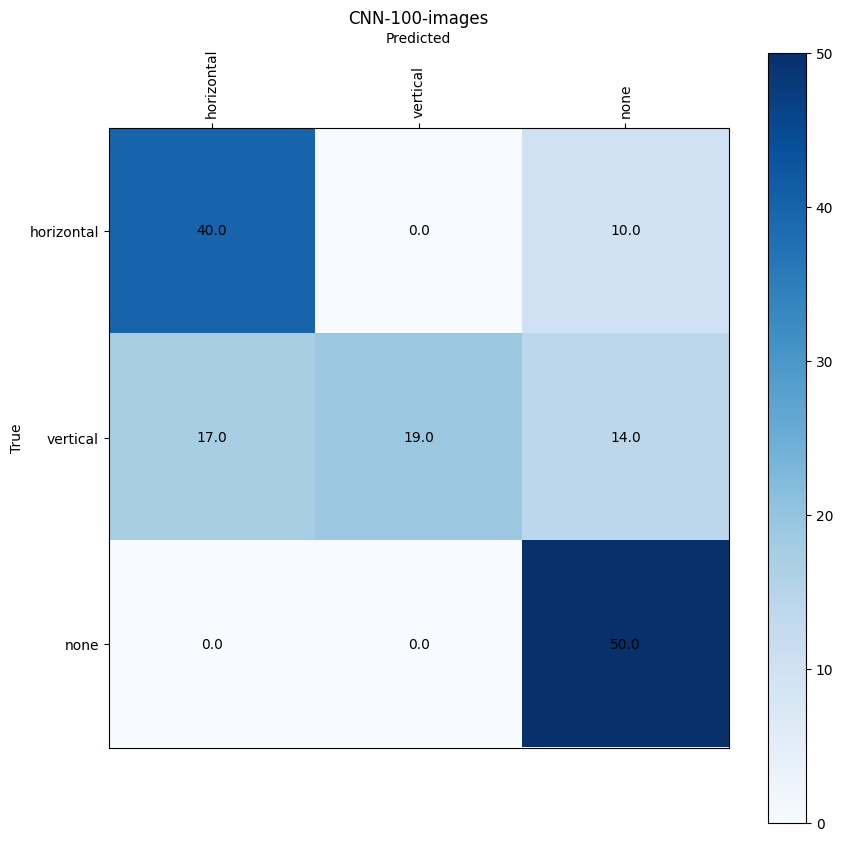

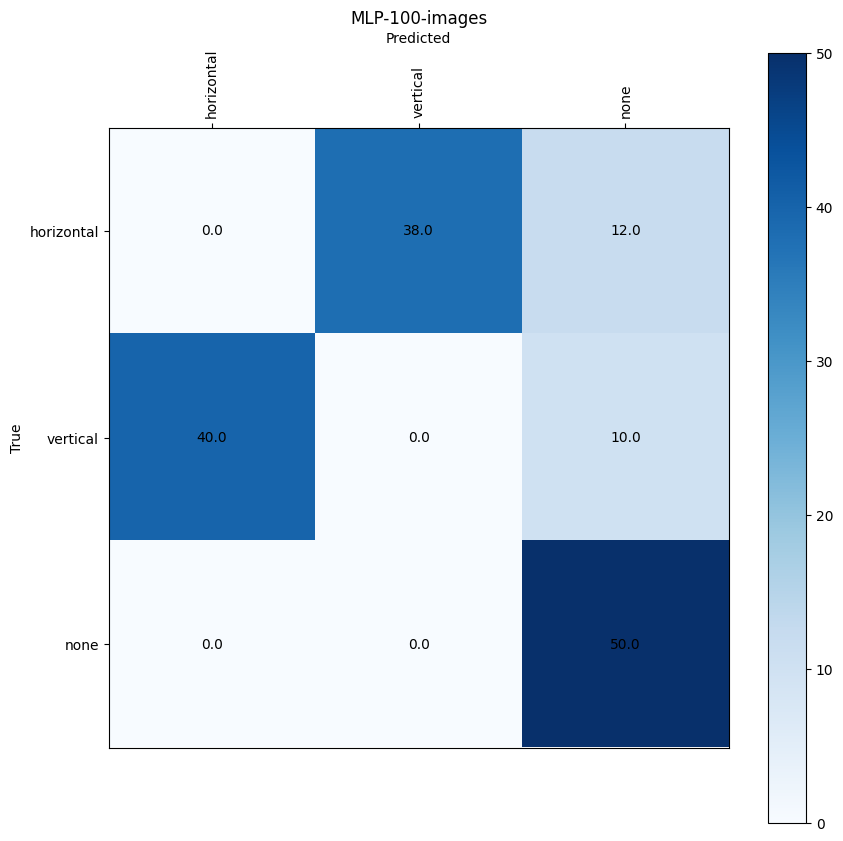

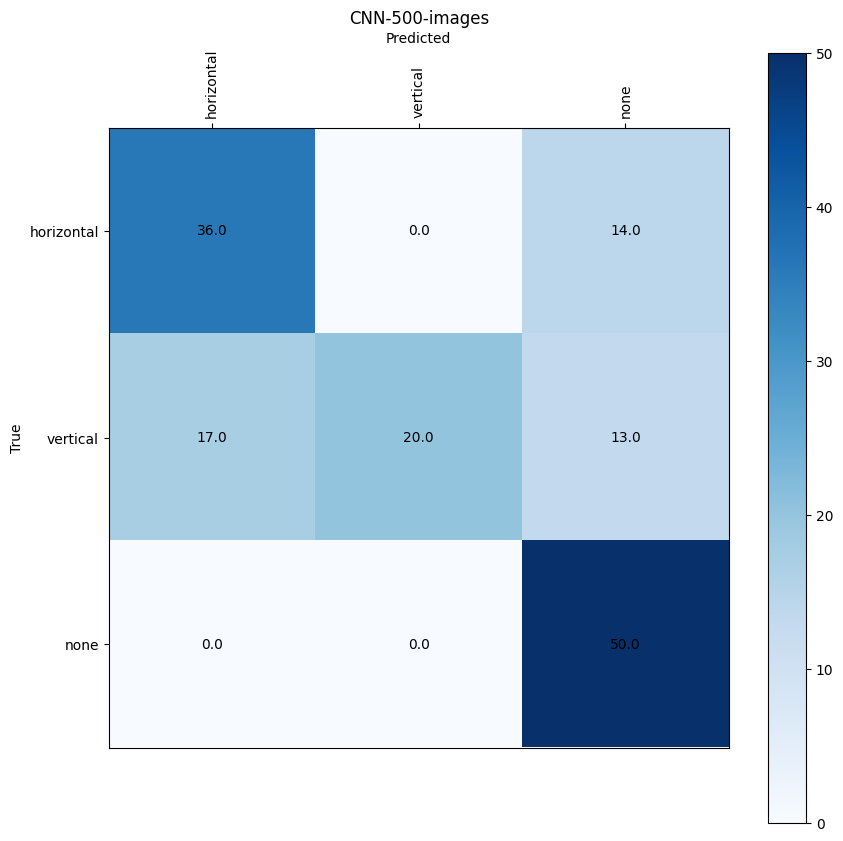

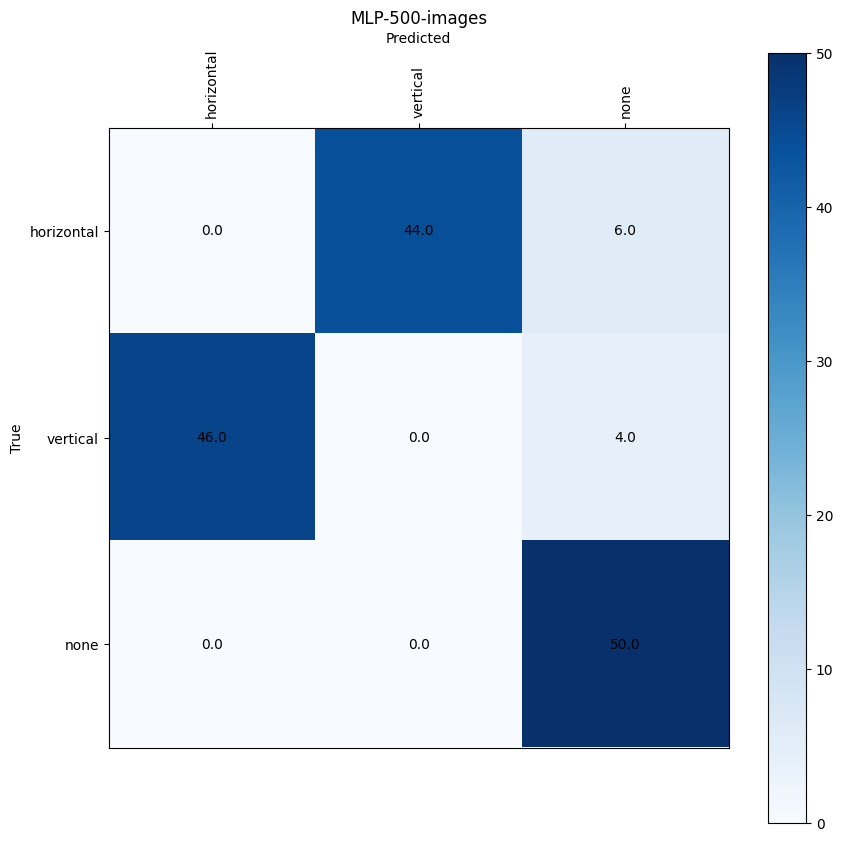

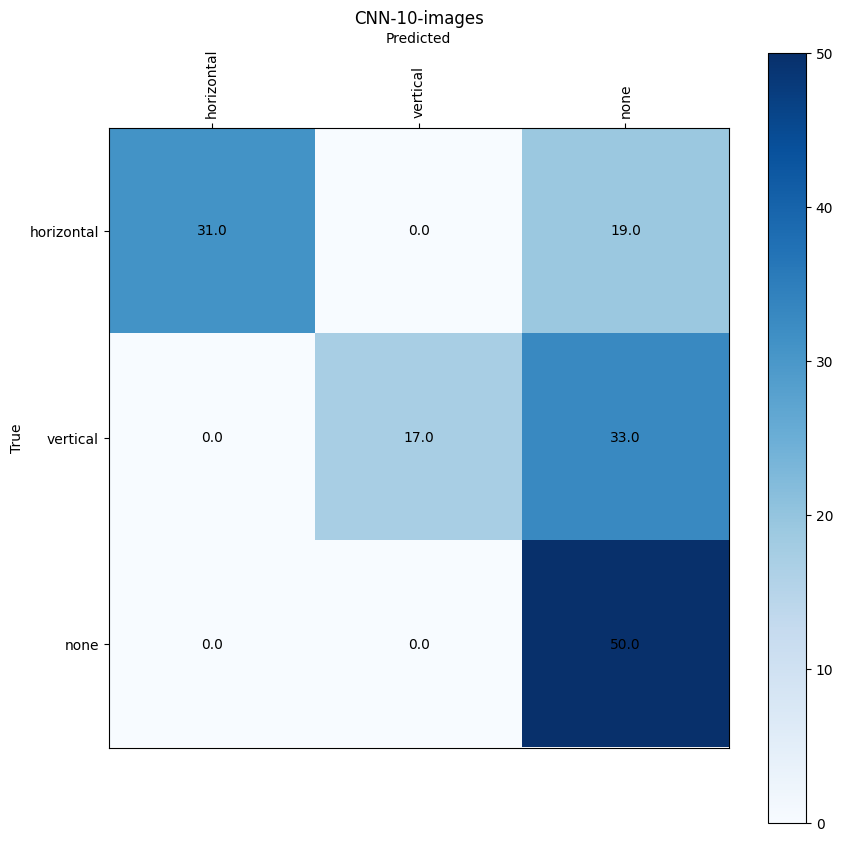

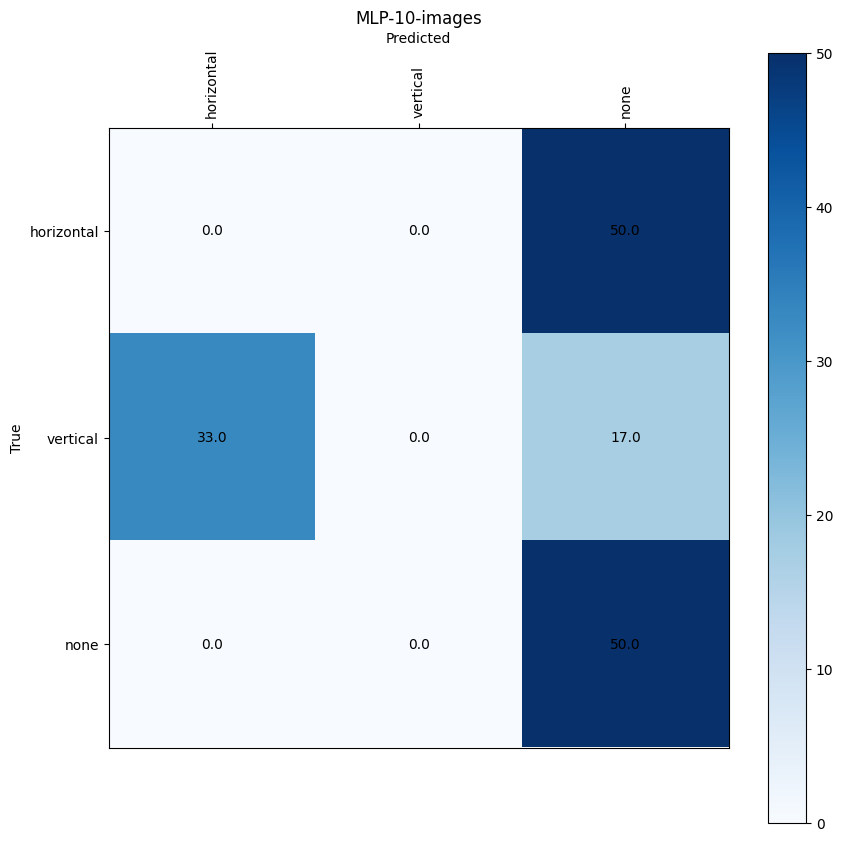

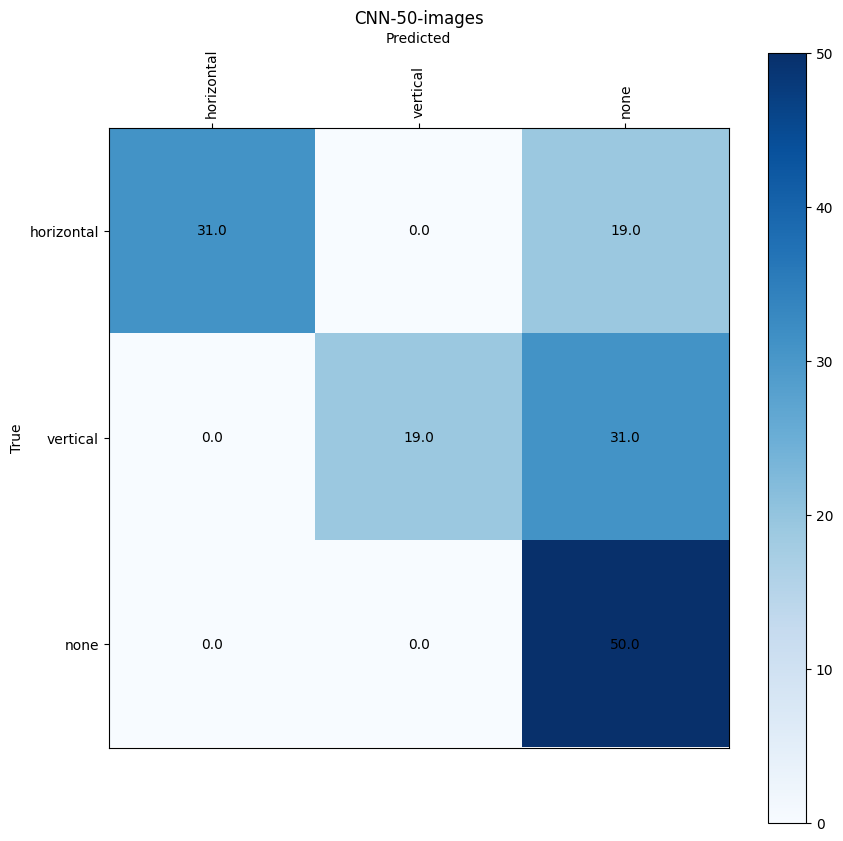

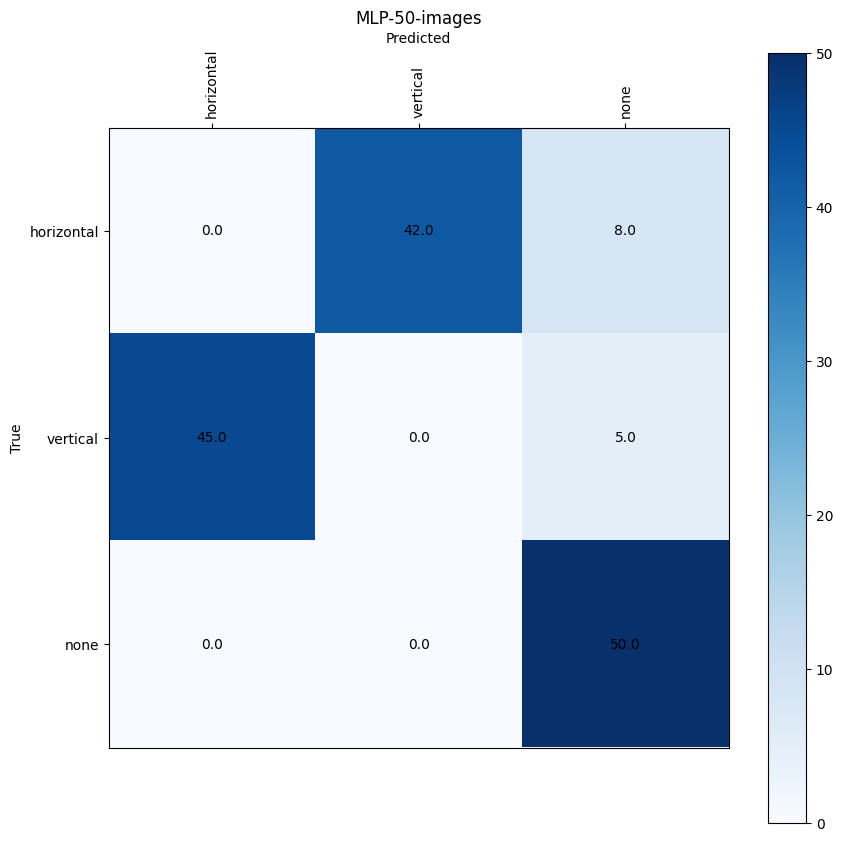

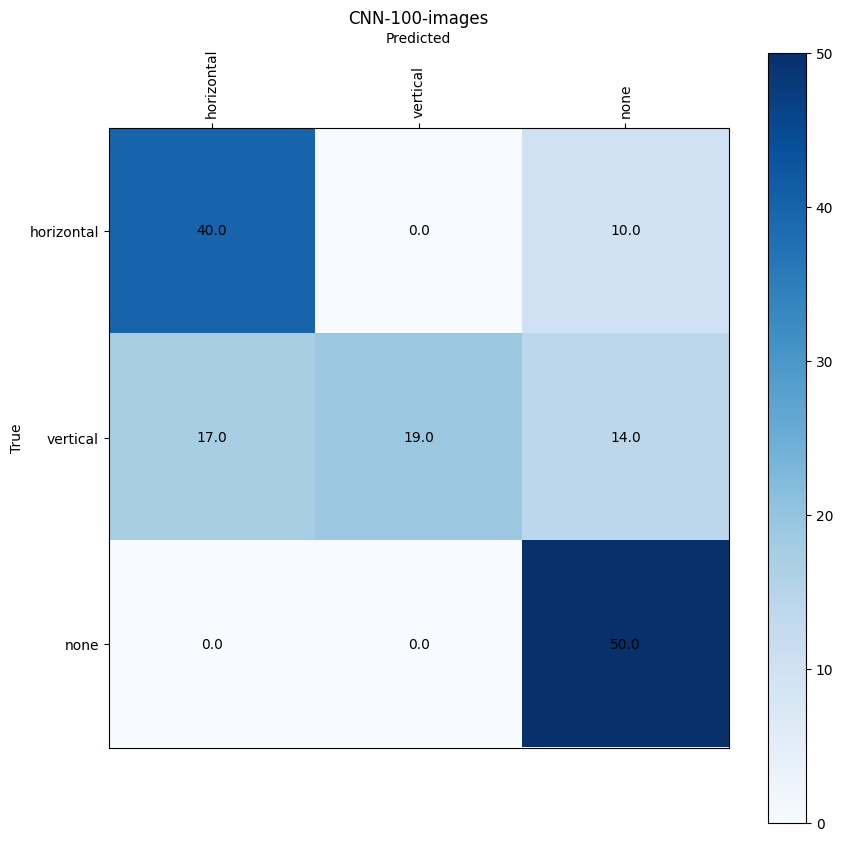

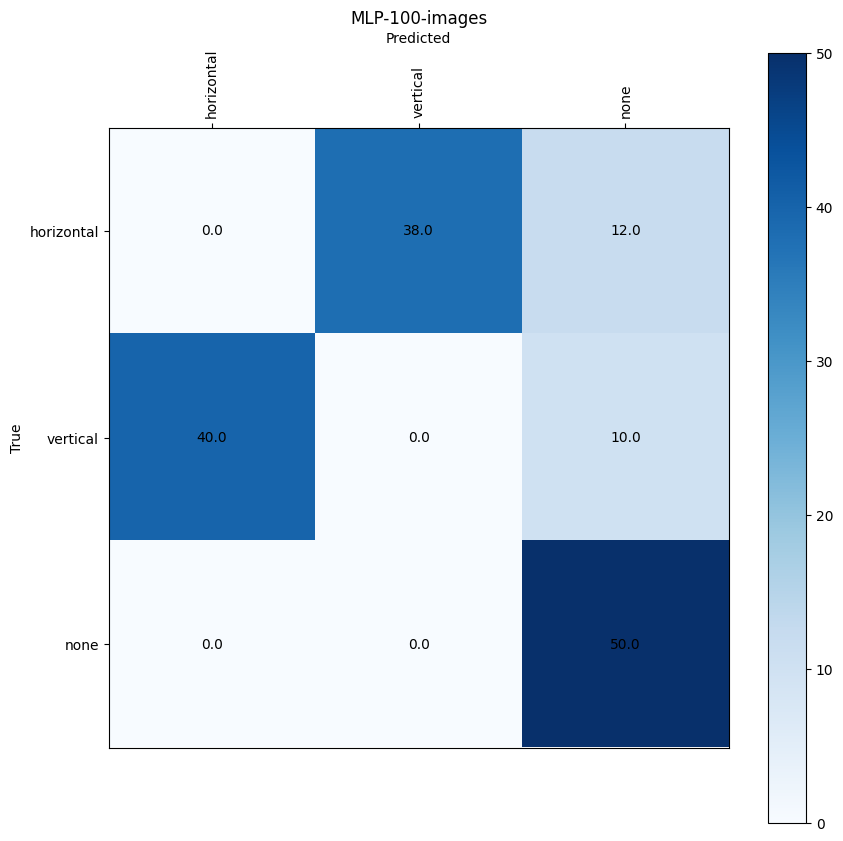

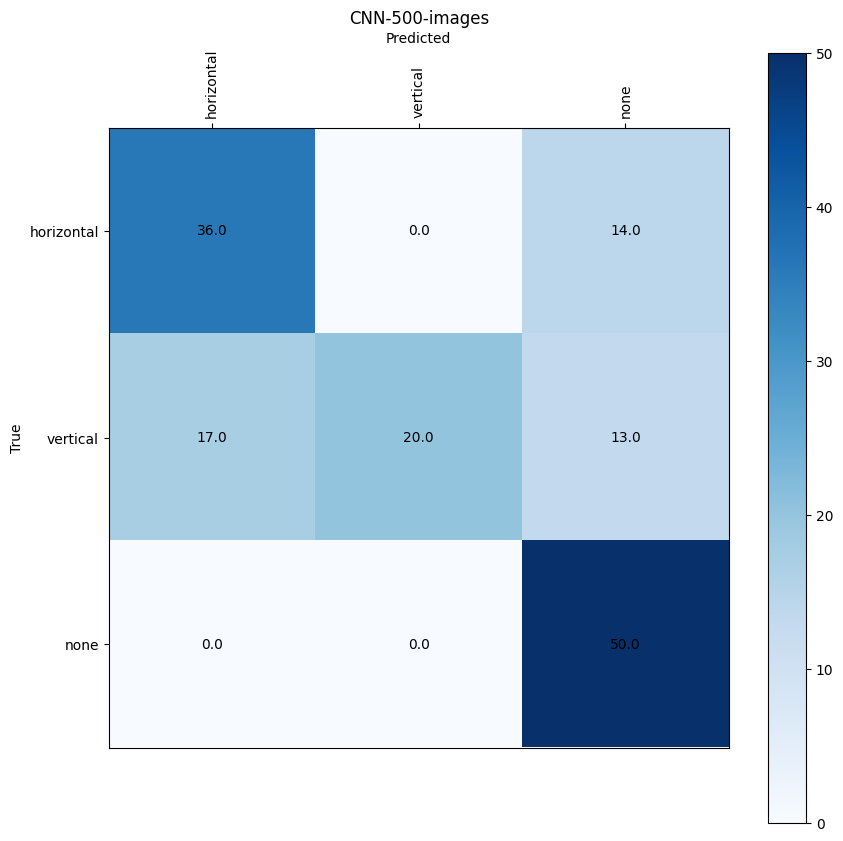

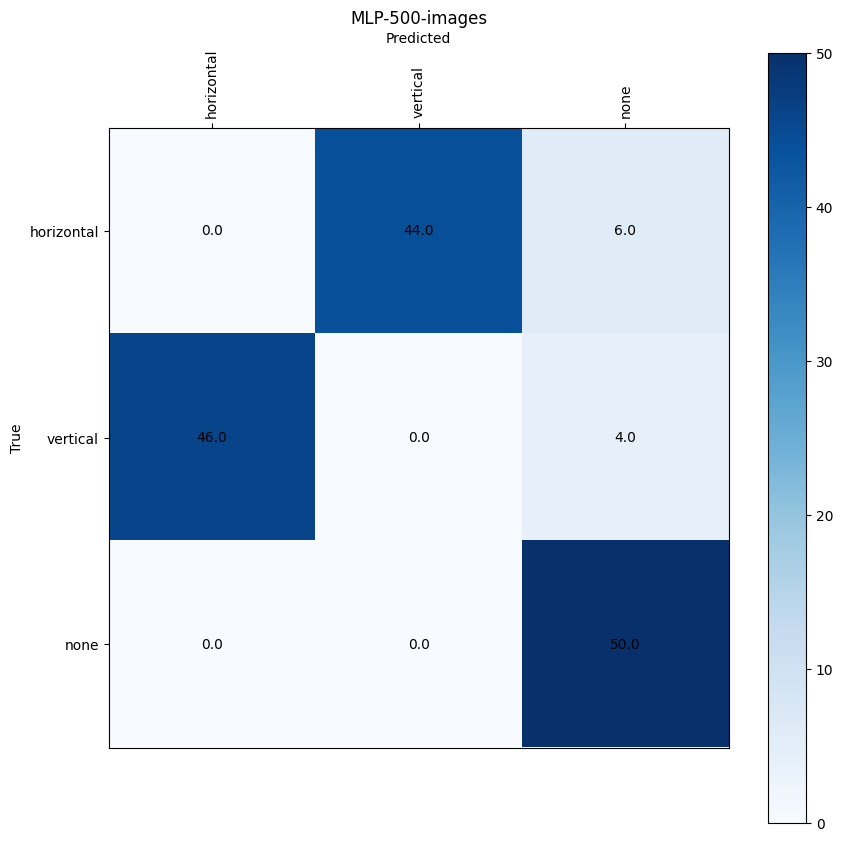

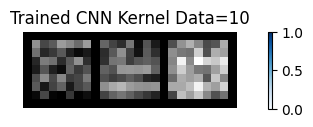

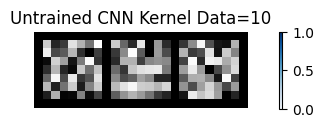

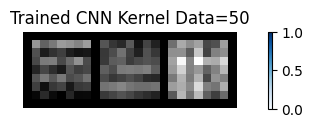

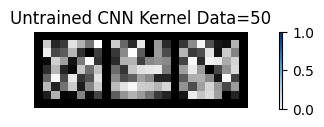

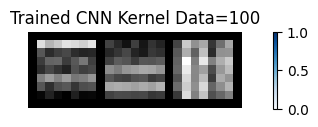

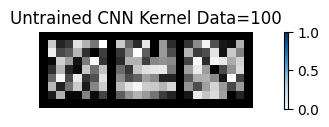

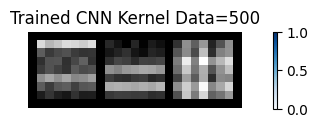

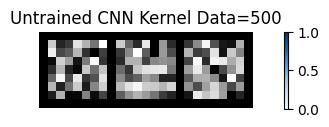

In [23]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Data={}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel Data={}'.format(num_image))

In this example, you will see that both CNN and MLP performance are worse than those in the previous question. If two models learn how to extract edges, they should be able to classify the images with edges even though the edges locate in the other half of the images. However, both models fail to do so. What would be the problem? To investigate this, let's first look at the confusion matrices for both models  [link](https://en.wikipedia.org/wiki/Confusion_matrix).

/home/cleverctz/berkeley/cs182_deeplearning/hw5/hw5/helpers/vis_helper.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + class_names, rotation=90)
/home/cleverctz/berkeley/cs182_deeplearning/hw5/hw5/helpers/vis_helper.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + class_names)


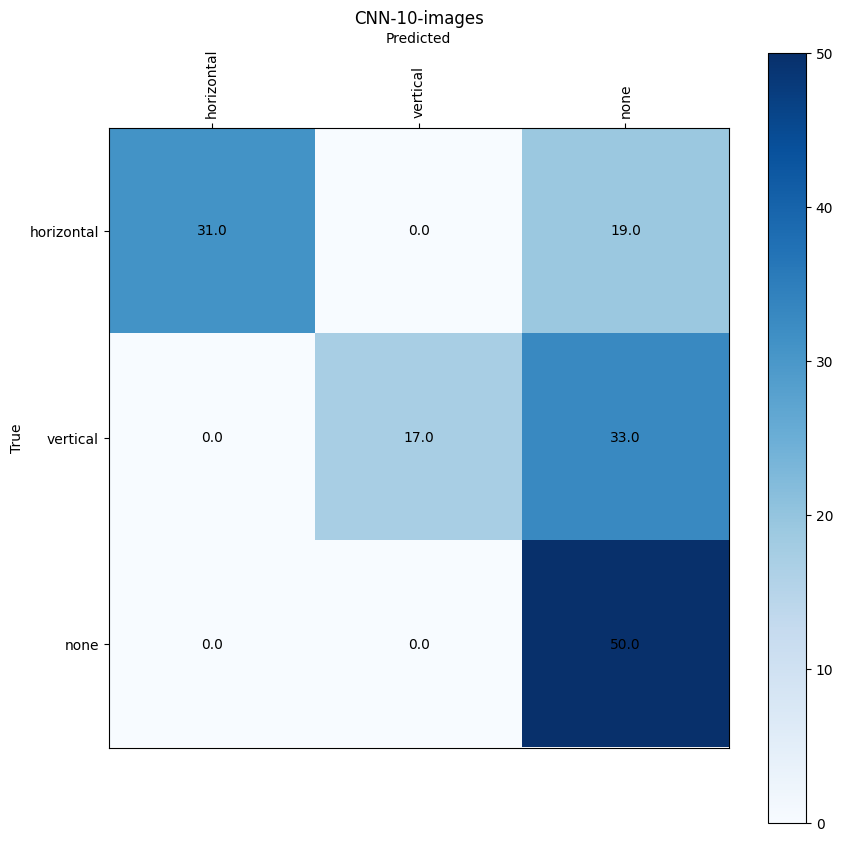

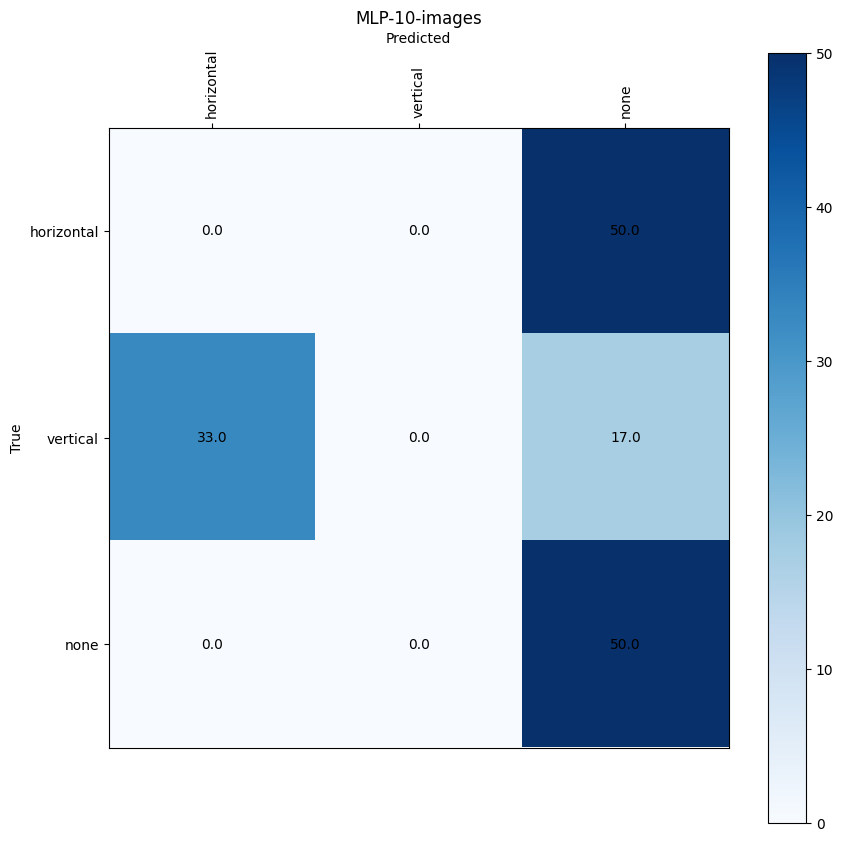

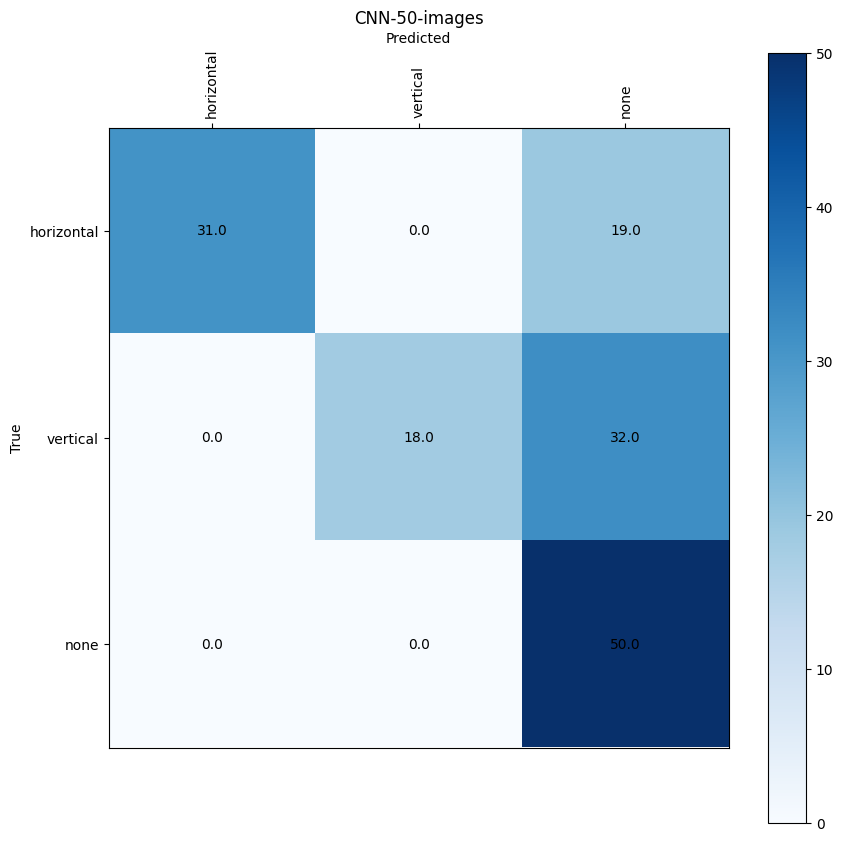

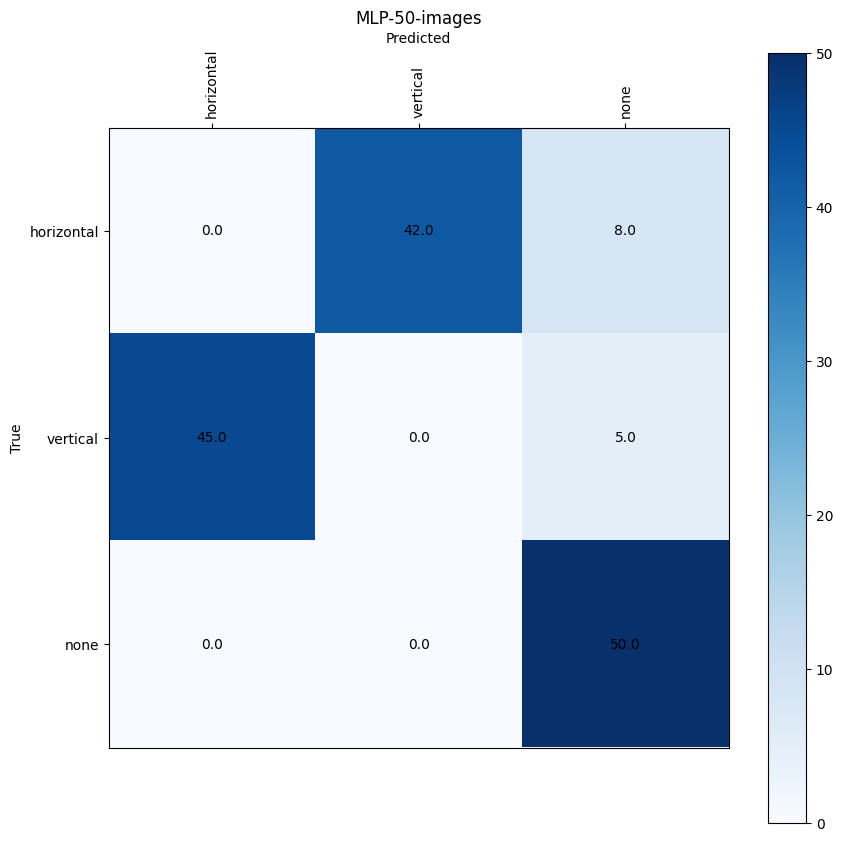

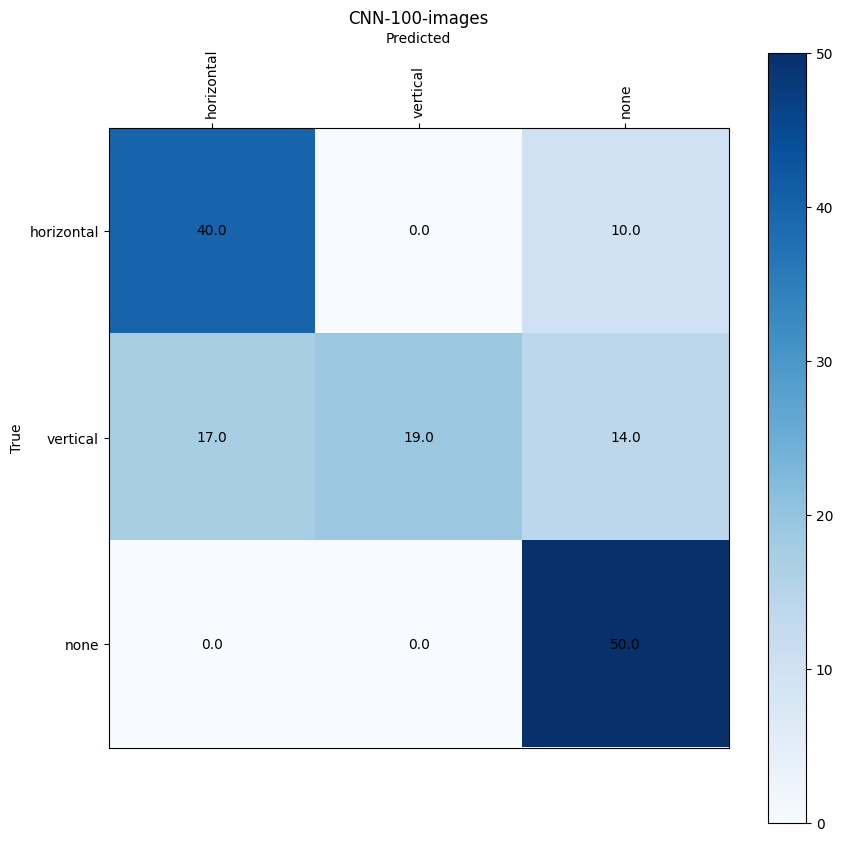

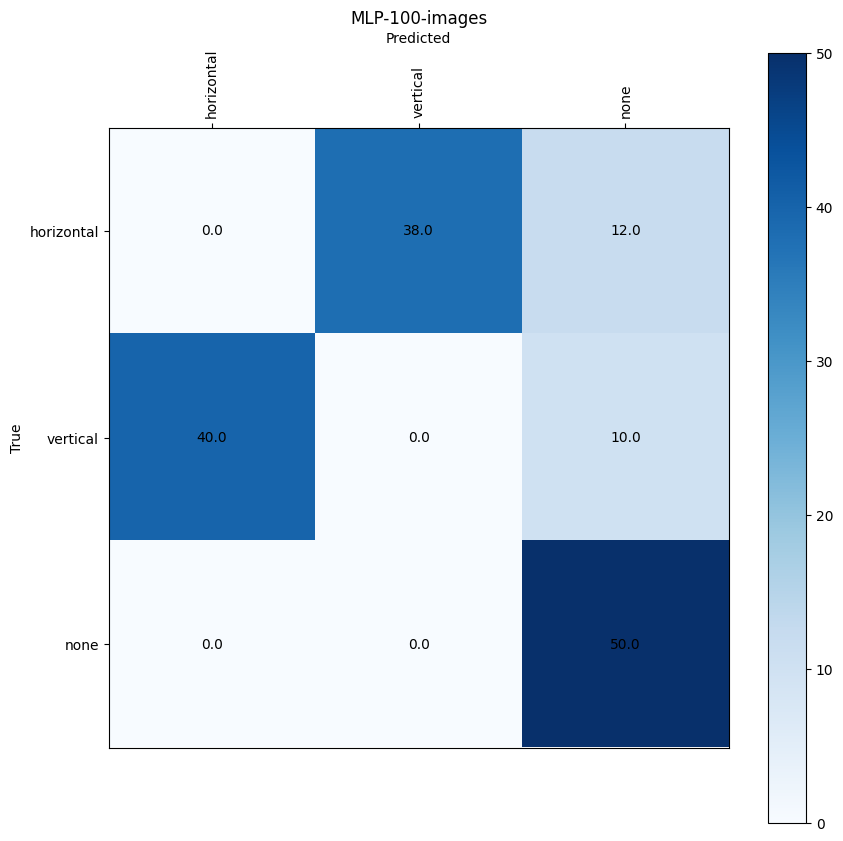

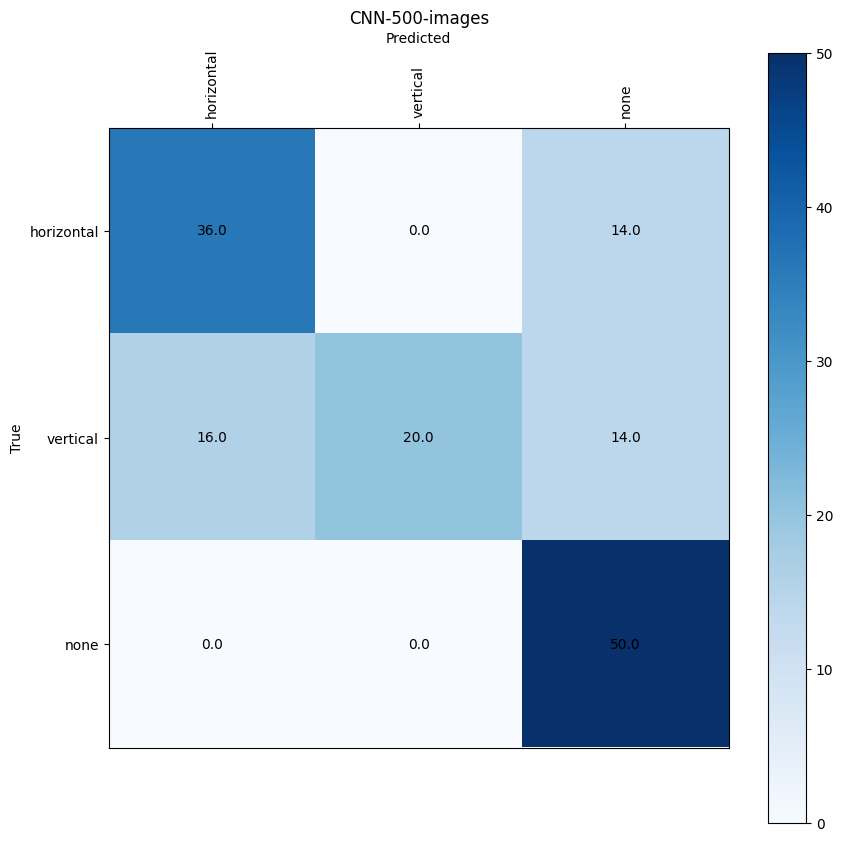

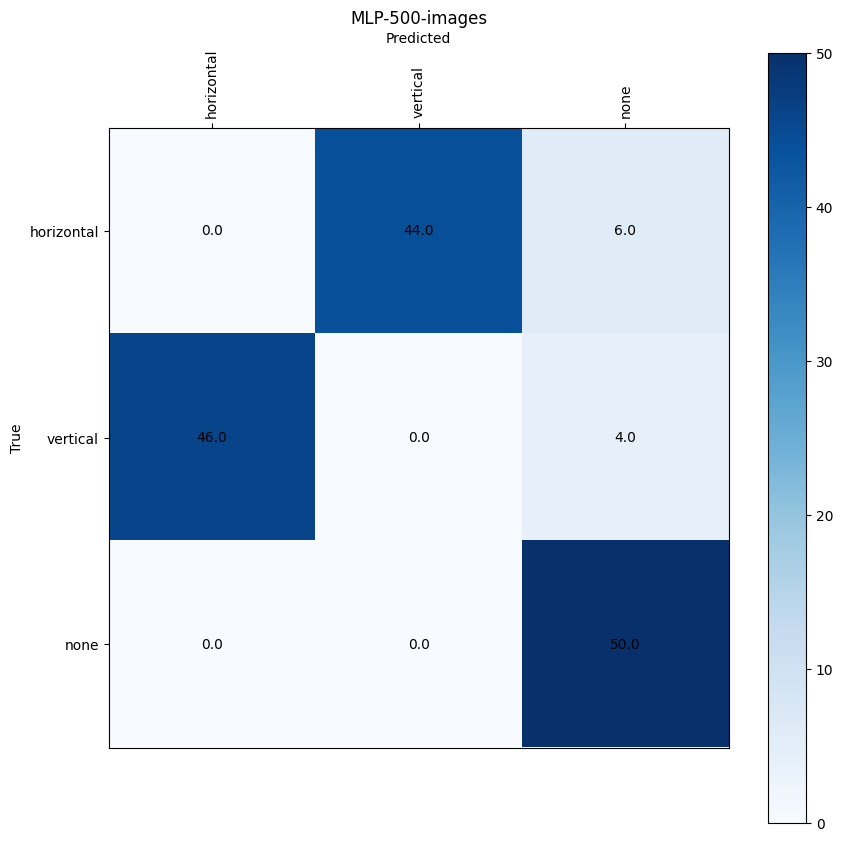

In [9]:
## Plot the confusion matrix
for num_image, cnn_confusion_matrix in cnn_confusion_matrix_dict.items():
    mlp_confusion_matrix = mlp_confusion_matrix_dict[num_image]
    vis_confusion_matrix(cnn_confusion_matrix, ['horizontal', 'vertical', 'none'], 'CNN-{}-images'.format(num_image))
    vis_confusion_matrix(mlp_confusion_matrix, ['horizontal', 'vertical', 'none'], 'MLP-{}-images'.format(num_image))

Q. Why do you think the confusion matrix looks like this? Why does CNN misclassify the images with edge to those without edge? Why does MLP misclassify the images with vertical edge to those with horizontal edges and vice versa? (Hint: Visualize some of the images in the training and validation set. And we are using kernel_size=7, which is large relative to the image size.)

Why CNN misclassifies: The kernel size is too large. It tends to wrongly generalize the feature of one pixel and its neighbours.
Why MLP misclassifies: MLP tends to ignore the relationship between nearby pixels.

We can do better than this. We didn't explore hyperparameter space yet. Let's search hyperparameters that can generalize well to the validation set. We will change the learning rate, the number of epochs, and kernel size for CNN.

Training with 10 images


100%|██████████| 500/500 [00:14<00:00, 34.69it/s]


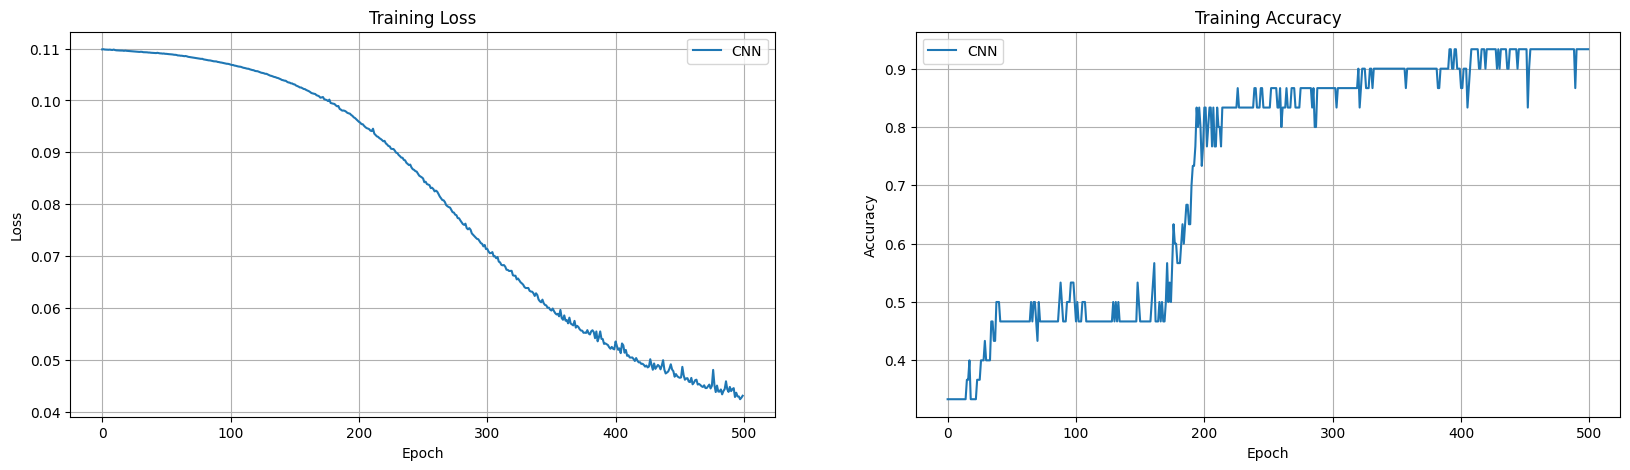

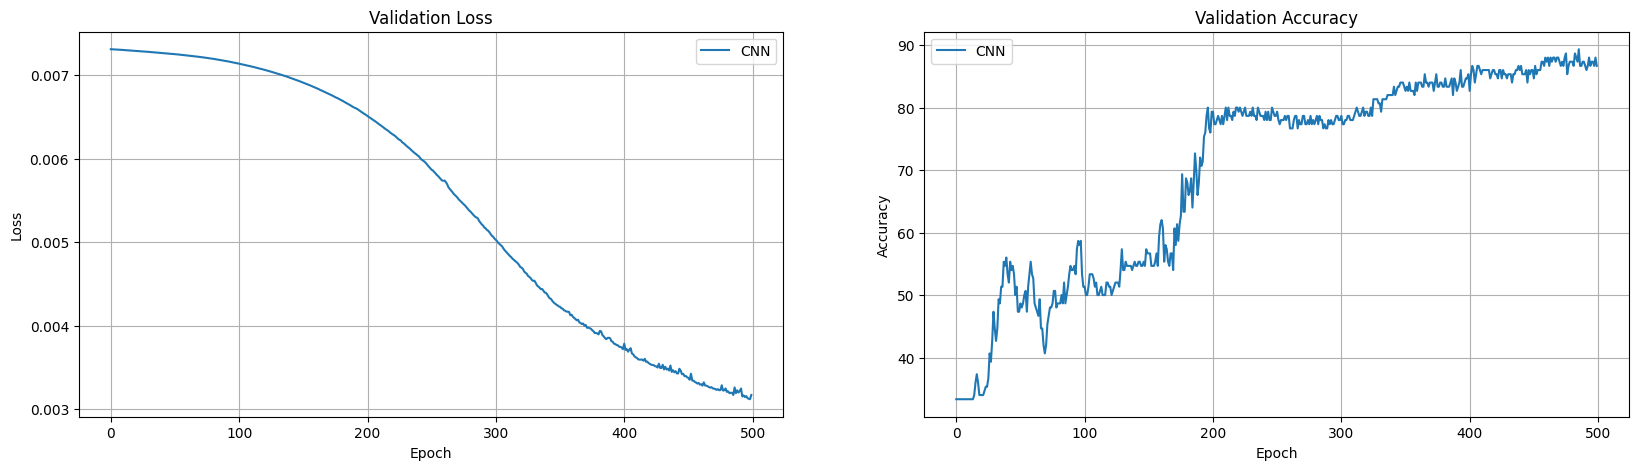

CNN Acc: 86.66666666666667
Training with 50 images


100%|██████████| 500/500 [00:31<00:00, 15.81it/s]


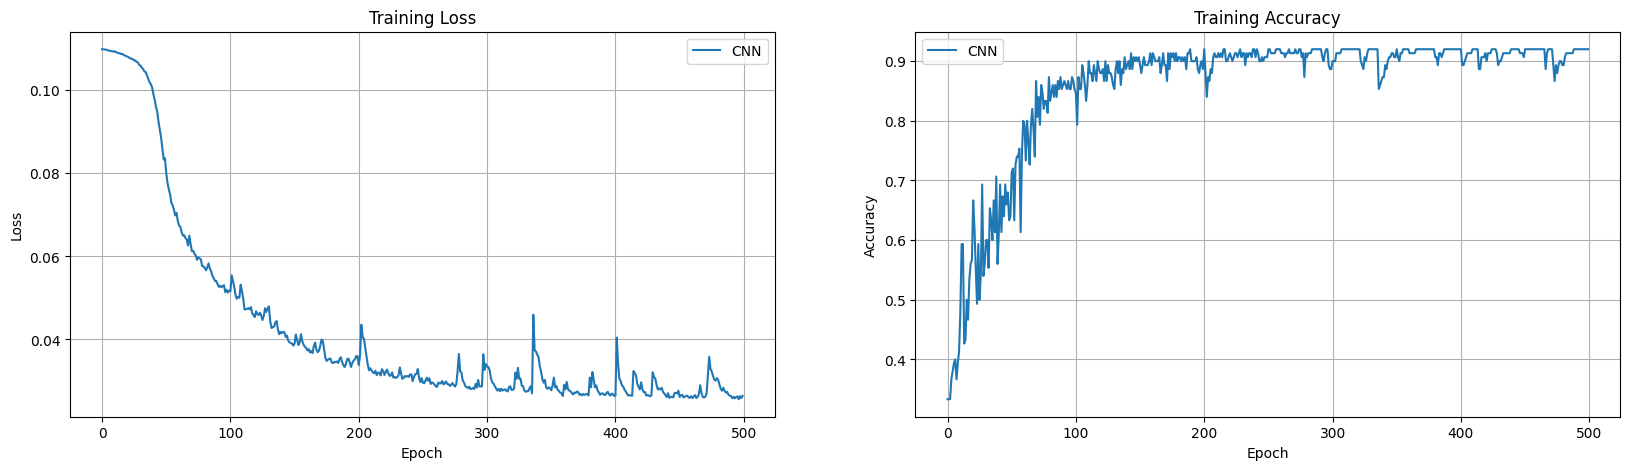

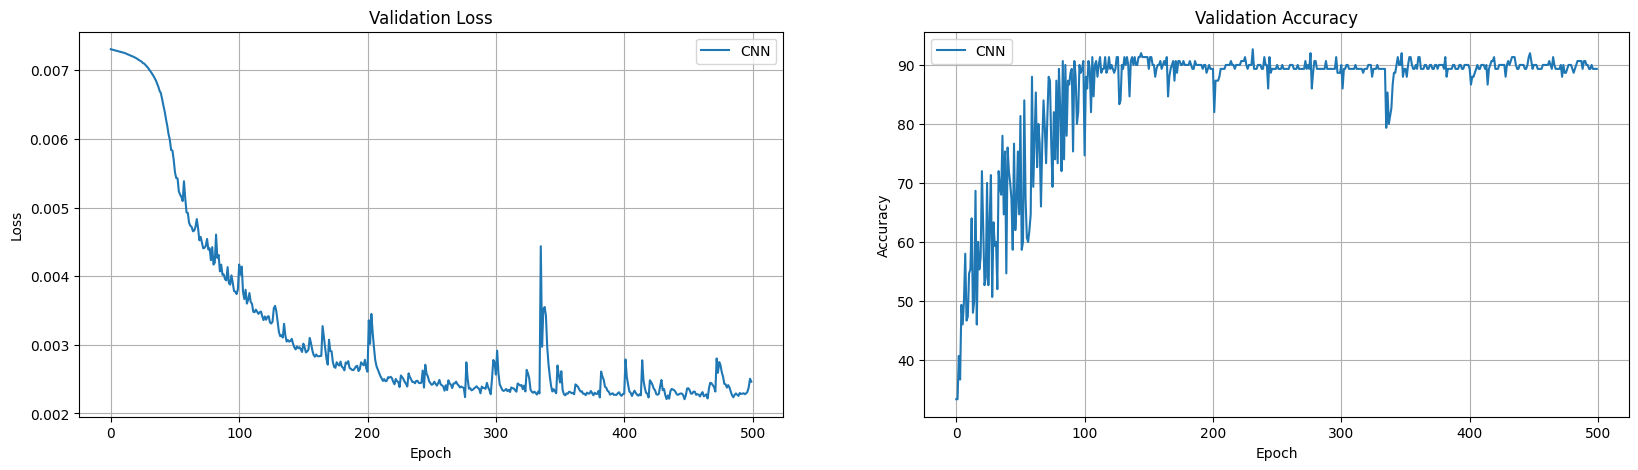

CNN Acc: 89.33333333333333
Training with 100 images


100%|██████████| 500/500 [00:52<00:00,  9.48it/s]


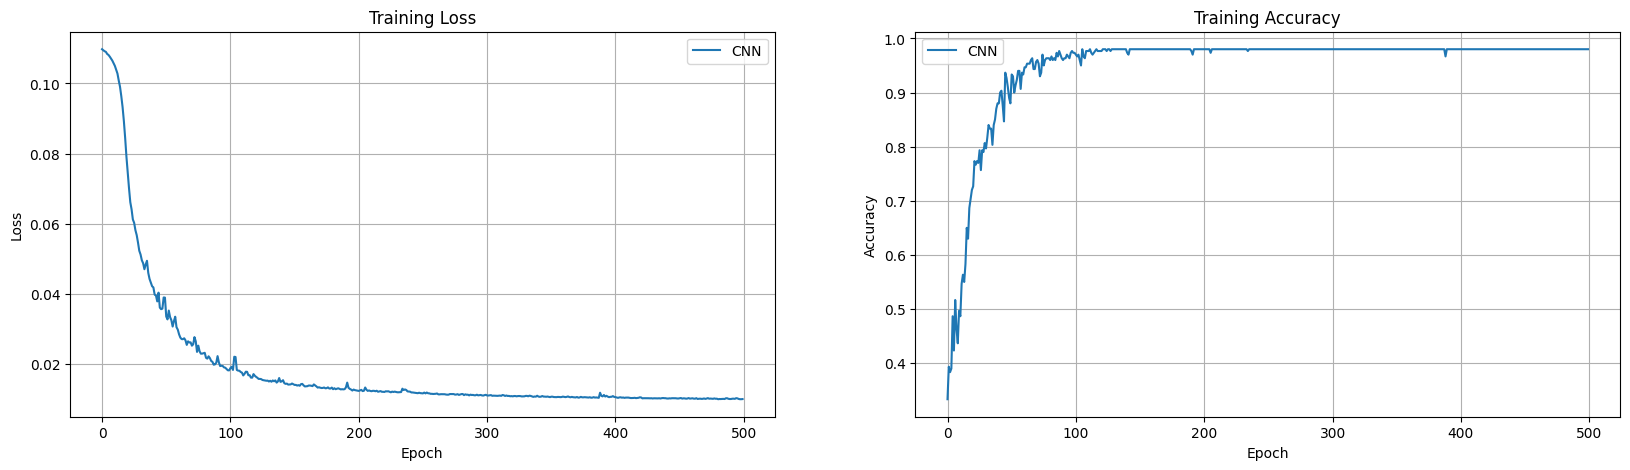

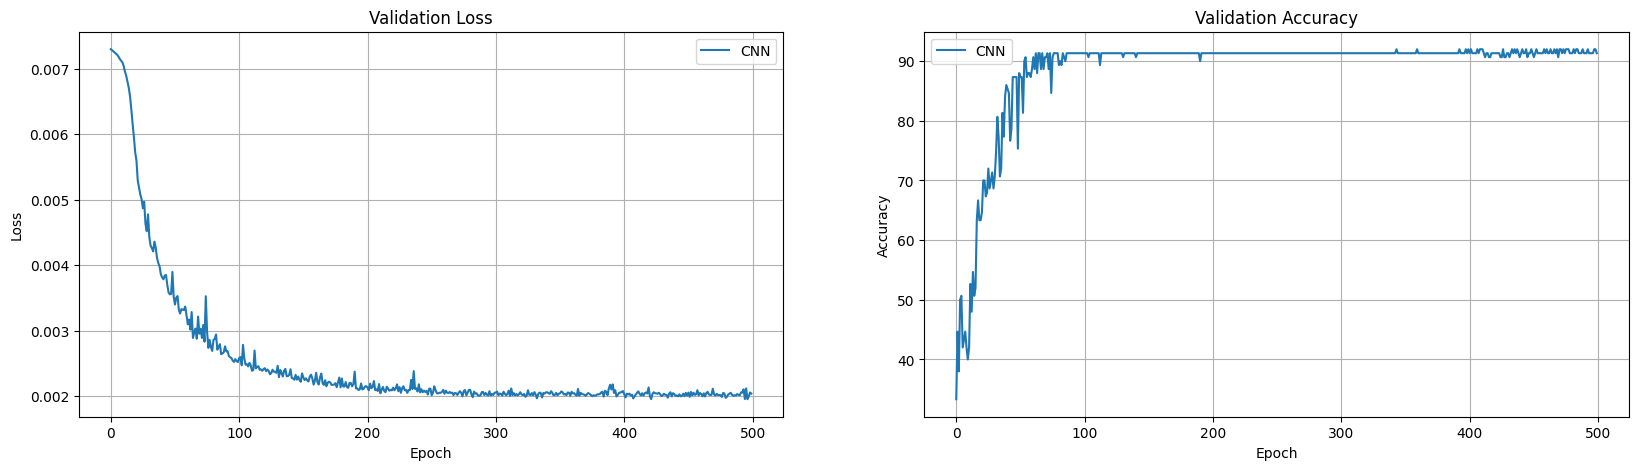

CNN Acc: 91.33333333333333
Training with 500 images


100%|██████████| 500/500 [03:37<00:00,  2.29it/s]


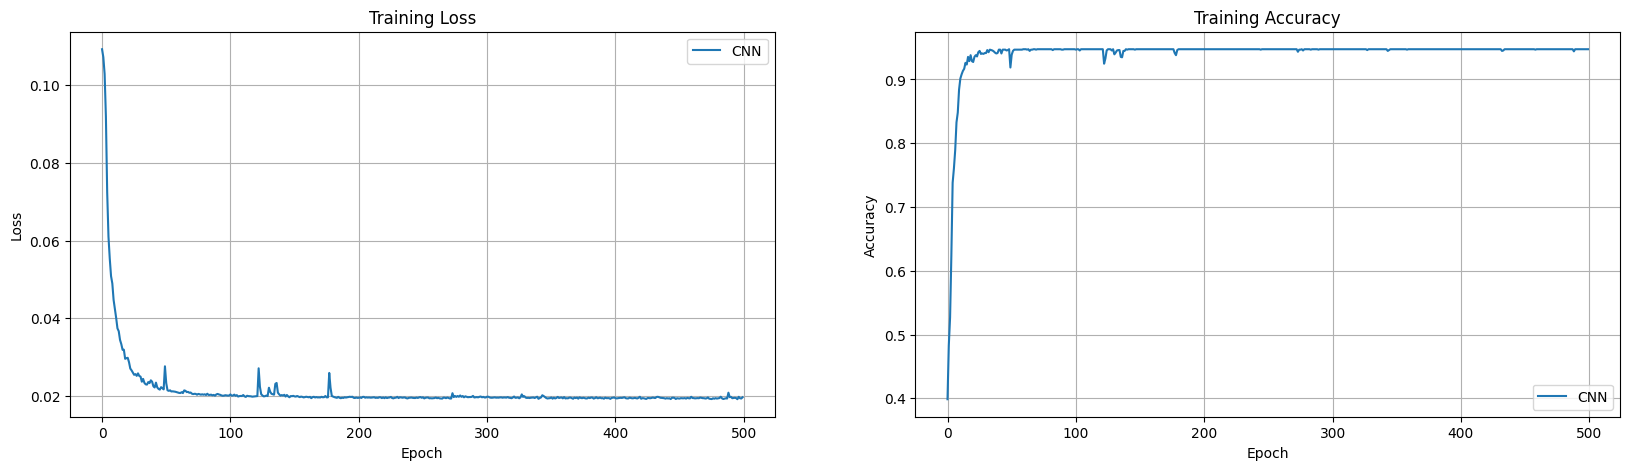

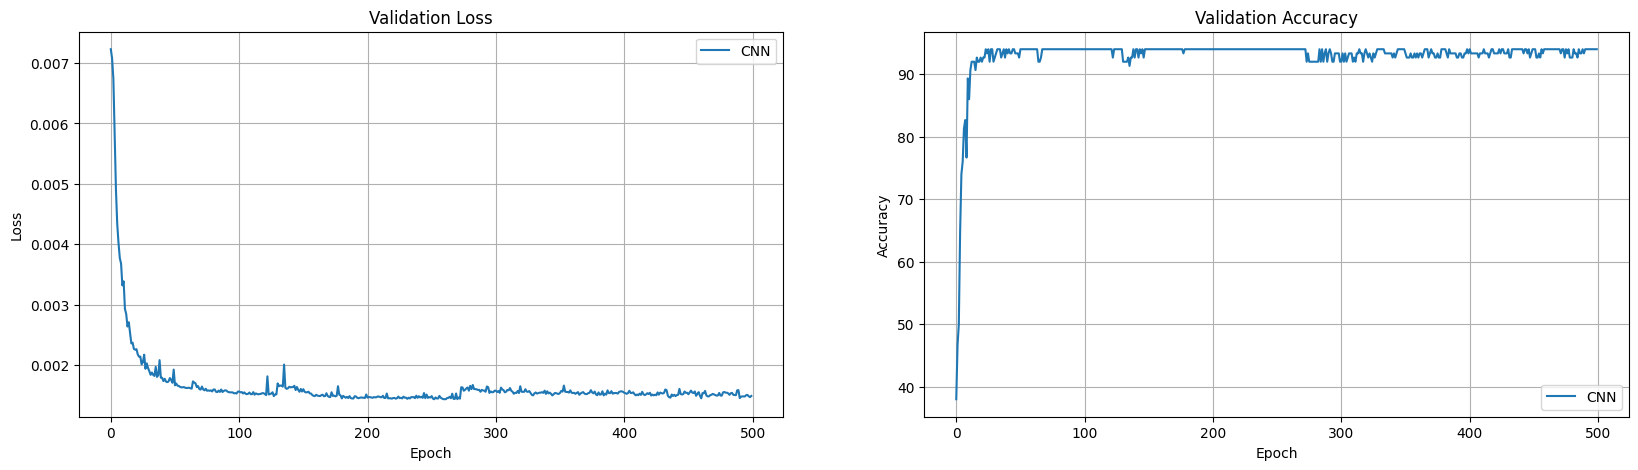

CNN Acc: 94.0


In [31]:
#############################################################################
# TODO: Try other num_epochs, lr, kernel_size. The validation accuracy      #
# should achieve 80% for 10 images per class.                               #
#############################################################################
lr = 5e-3
num_epochs = 500
kernel_size = 5
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_valid_acc_list = list()

cnn_kernel_dict = dict()

cnn_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=kernel_size)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, cnn_confusion_matrix = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, None, None)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, None, None)

    cnn_acc = cnn_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    cnn_confusion_matrix_dict[num_image] = cnn_confusion_matrix
    
    print("CNN Acc: {}".format(cnn_acc))
    cnn_acc_list.append(cnn_acc)

In [60]:
# #############################################################################
# # TODO: Try other num_epochs, lr, kernel_size. The validation accuracy      #
# # should achieve 40% for 10 images per class.                               #
# # len(hidden_dims) should be 2.                                             #
# #############################################################################
# lr = 2e-4
# num_epochs = 100
# hidden_dims = [50, 10]
# #############################################################################
# #                             END OF YOUR CODE                              #
# #############################################################################

# assert len(hidden_dims) == 2, "len(hidden_dims) should be 2."

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# criterion = nn.CrossEntropyLoss()

# mlp_valid_acc_list = list()

# mlp_confusion_matrix_dict = dict()

# for num_image, train_loader in train_loader_dict.items():
#     print("Training with {} images".format(num_image))
#     set_seed(seed)

#     mlp_model = ThreeLayerMLP(hidden_dims=hidden_dims)
#     mlp_model.to(device)

#     mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)

#     # logging how training and validation accuracy changes
#     mlp_train_acc_list, mlp_valid_acc_list, mlp_train_loss_list, mlp_valid_loss_list = [], [], [], []
#     for epoch in tqdm(range(num_epochs)):
#         mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

#         mlp_valid_loss, mlp_valid_acc, mlp_confusion_matrix = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

#         mlp_train_acc_list.append(mlp_train_acc)
#         mlp_valid_acc_list.append(mlp_valid_acc)
#         mlp_train_loss_list.append(mlp_train_loss)
#         mlp_valid_loss_list.append(mlp_valid_loss)
    
#     vis_training_curve([], [], mlp_train_loss_list, mlp_train_acc_list)
#     vis_validation_curve([], [], mlp_valid_loss_list, mlp_valid_acc_list)

#     mlp_acc = mlp_valid_acc_list[-1]

#     mlp_confusion_matrix_dict[num_image] = mlp_confusion_matrix
    
#     print("MLP Acc: {}".format(mlp_acc))
#     mlp_acc_list.append(mlp_acc)

Q. Why do you think MLP fails to learn the task while CNN can learn the task? (Hint: Think about the model architecture.)

Reason: In this task, each pixel has a strong relationship with its neighbour pixels. Since CNN does well in detecting the relationship, trained classifier successfully does this task. MLP doesn't do well in detecting such relationship.

### Q5. When CNN is Worse than MLP

In this problem, we will see that CNN is not always better than MLP in the image domain. Using CNN assumes that the data has locally correlated, whatever data looks. We can manually 'whiten' or remove such local correlation simply by applying random permutation to the images. A random permutation matrix is a matrix that has the same number of rows and columns. Each row and column has the same number of 1s. The rest of the elements are 0s. For example, the following is a random permutation matrix. 

```
[[0, 1, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 0, 1, 0]]
```

This matrix randomly reorders the elements of the vector. For example, if we apply this matrix to the vector `[1, 2, 3, 4]`, we will get `[2, 4, 1, 3]`. If we apply this matrix to the image, we will get the image with the same content, but the pixels are randomly shuffled. One property of the random permutation matrix is that it is invertible. It means that we can recover the original image by simply applying the inverse matrix to the shuffled image. From the information-theoretical perspective, the random permutation matrix preserves the mutual information of the image and the label. 

We will repeat the same experiment as the previous problem. Visualize the dataset first.

In [10]:
set_seed(seed)
visual_domain_config = None
use_permutation = True

permutater = np.arange(28 * 28,  dtype=np.int32)
np.random.shuffle(permutater)
unpermutater = np.argsort(permutater)

visual_dataset = None

transforms = T.Compose([T.ToTensor()])
#############################################################################
# TODO: Implement visual_dataset for this new domain                        #
# Hint: If you read docstring of EdgeDetectionDataset, you will find        #
# 'use_permutation' args. Pass True to this args.                           #
# Also pass permutator to EdgeDetectionDataset                              #
#############################################################################
pass
visual_domain_config = dict(
    data_per_class=10,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
    permutater = permutater,
    unpermutater = unpermutater,
    use_permutation = True
)
visual_dataset = EdgeDetectionDataset(visual_domain_config, mode='train', transform=transforms)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Dataset Image before permutation


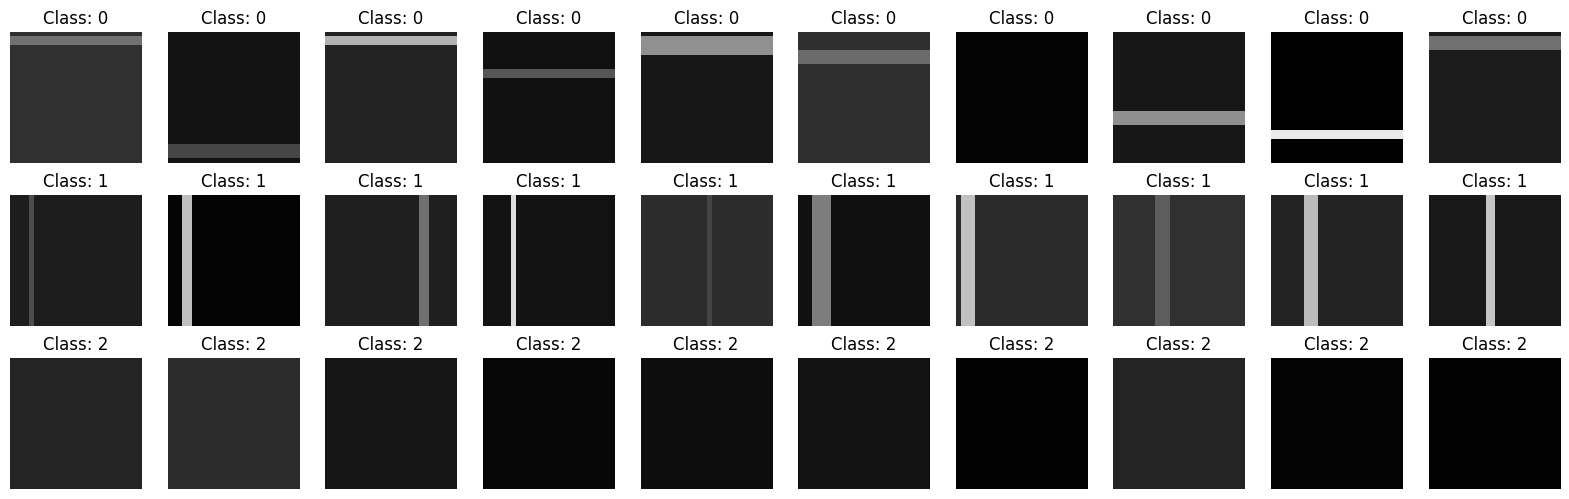

Dataset Image after permutation


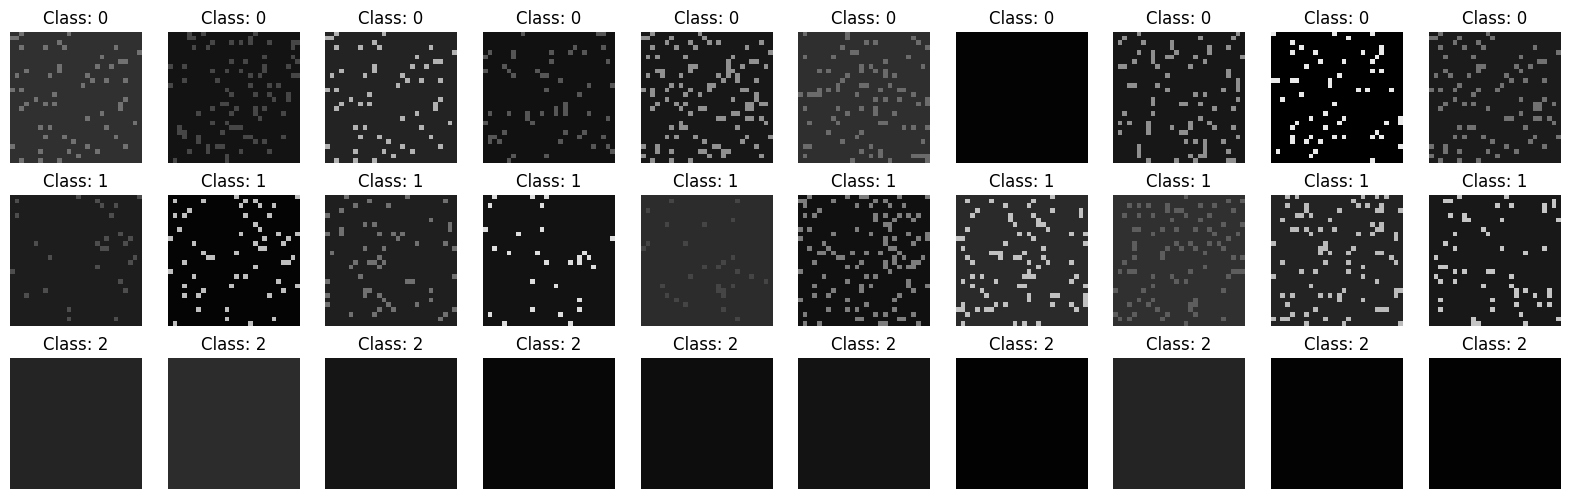

In [11]:
## Visualize the images
unpermutator = visual_dataset.get_unpermutater()
print('Dataset Image before permutation')
vis_unpermuted_dataset(visual_dataset, num_classes=3, num_show_per_class=10, unpermutator=unpermutator)

print('Dataset Image after permutation')
vis_dataset(visual_dataset, num_classes=3, num_show_per_class=10)

Now let's train CNN and MLP on the permuted dataset. 

In [75]:
set_seed(seed)

train_loader_dict = dict()
num_train_images_list = [30, 40, 50, 60, 70]
use_permutation = True
valid_loader = None

permutater = np.arange(28 * 28,  dtype=np.int32)
np.random.shuffle(permutater)
unpermutater = np.argsort(permutater)

transforms = T.Compose([T.ToTensor()])

batch_size = 10
#############################################################################
# TODO: Implement train_loader_dict for each number of training images.     #
# Key: The number of training images (30, 40, 50, 60 and 70)                #
# Value: The corresponding dataloader                                       #
# The validation set size is 50 images per class                            #
# 'use_permutation' args. Pass True to this args.                           #
# Also pass permutator/unpermutator to EdgeDetectionDataset                 #
#############################################################################
for i in num_images_list:
    dataset_config = dict(
    data_per_class=i,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
    permutater = permutater,
    unpermutater = unpermutater,
    use_permutation = True
)
    dataset = EdgeDetectionDataset(dataset_config, mode='train', transform=transforms)
    train_loader_dict[f'{i}'] = torch.utils.data.DataLoader(dataset, train_batch_size, shuffle = True)


valid_config = dict(
    data_per_class=50,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
    permutater = permutater,
    unpermutater = unpermutater,
    use_permutation = True
)
valid_dataset = EdgeDetectionDataset(valid_config, mode='valid', transform=transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, valid_batch_size, shuffle = True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Note that kernel size is 3 in this experiment. 

Training with 10 images


100%|██████████| 300/300 [00:16<00:00, 18.44it/s]


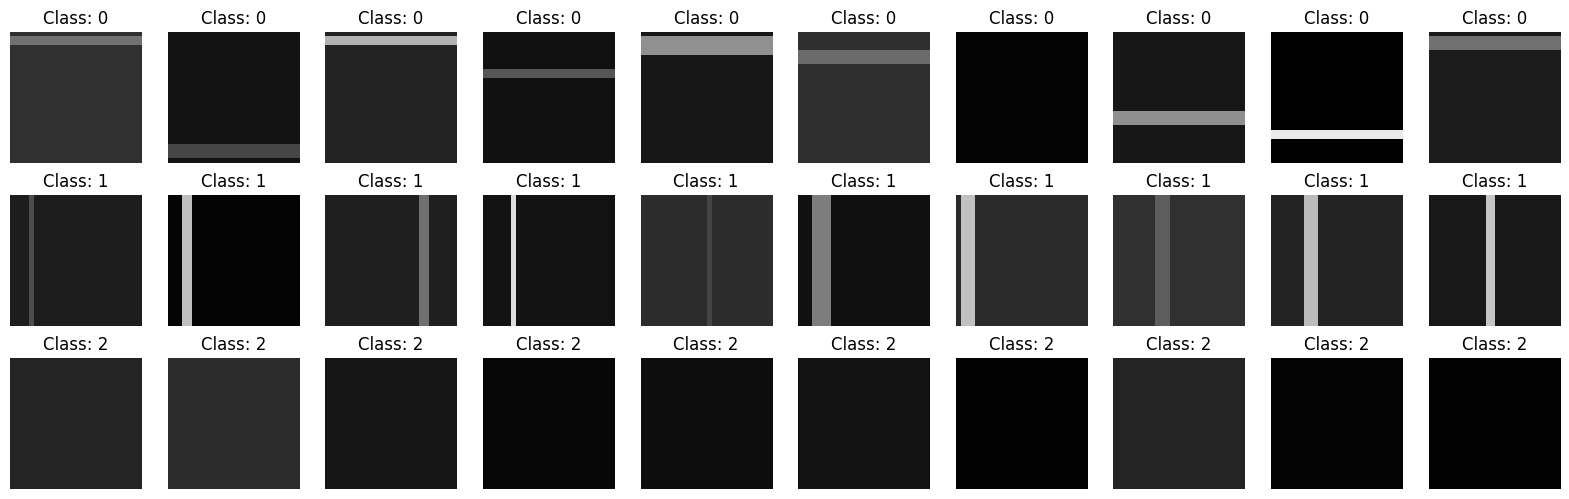

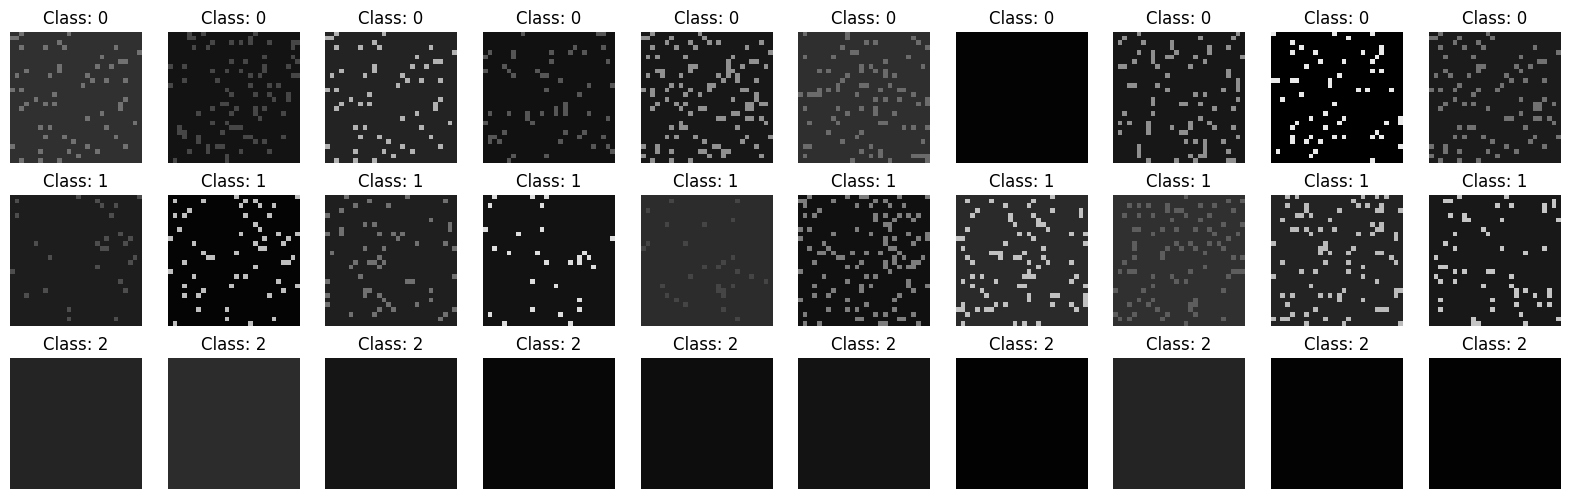

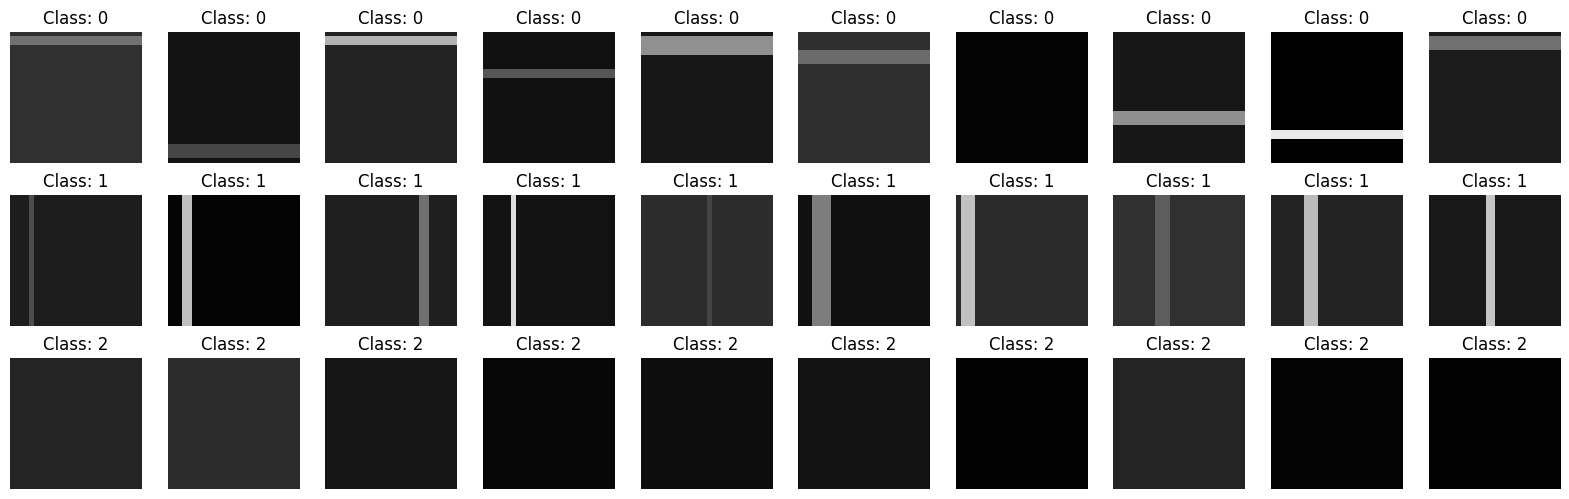

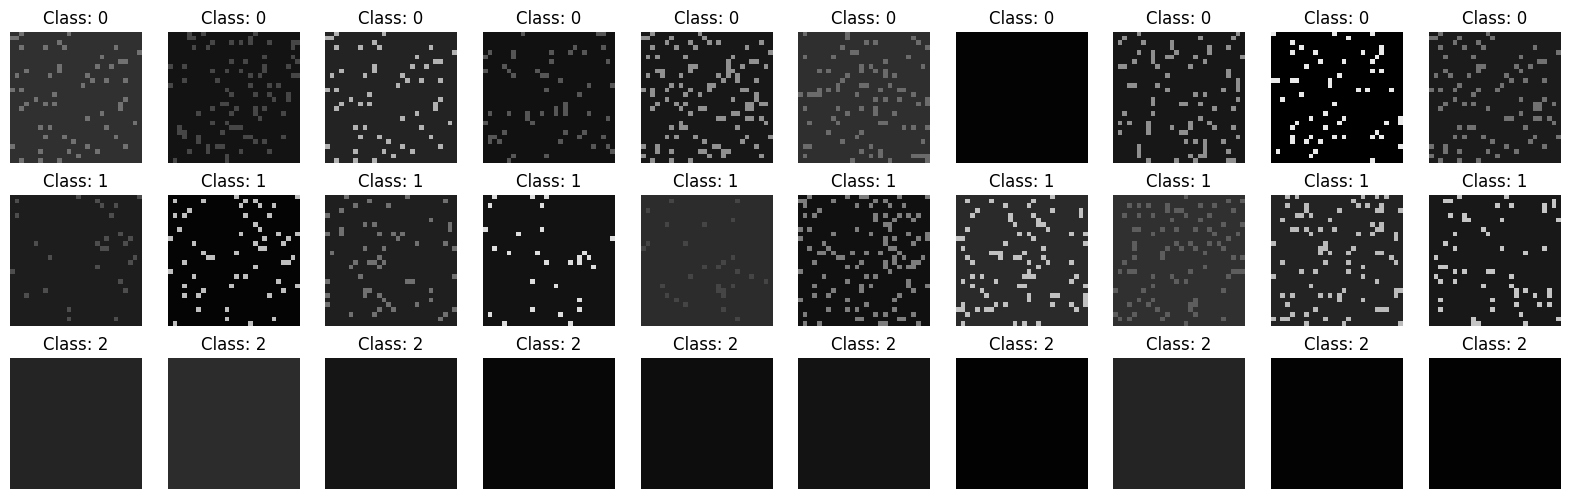

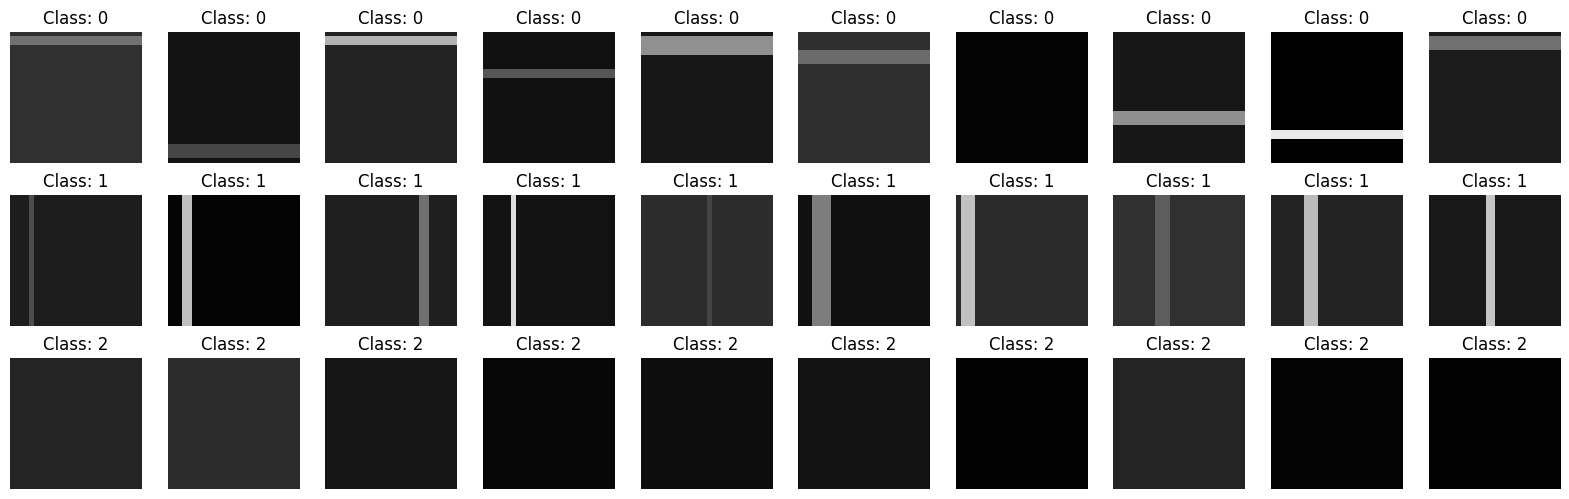

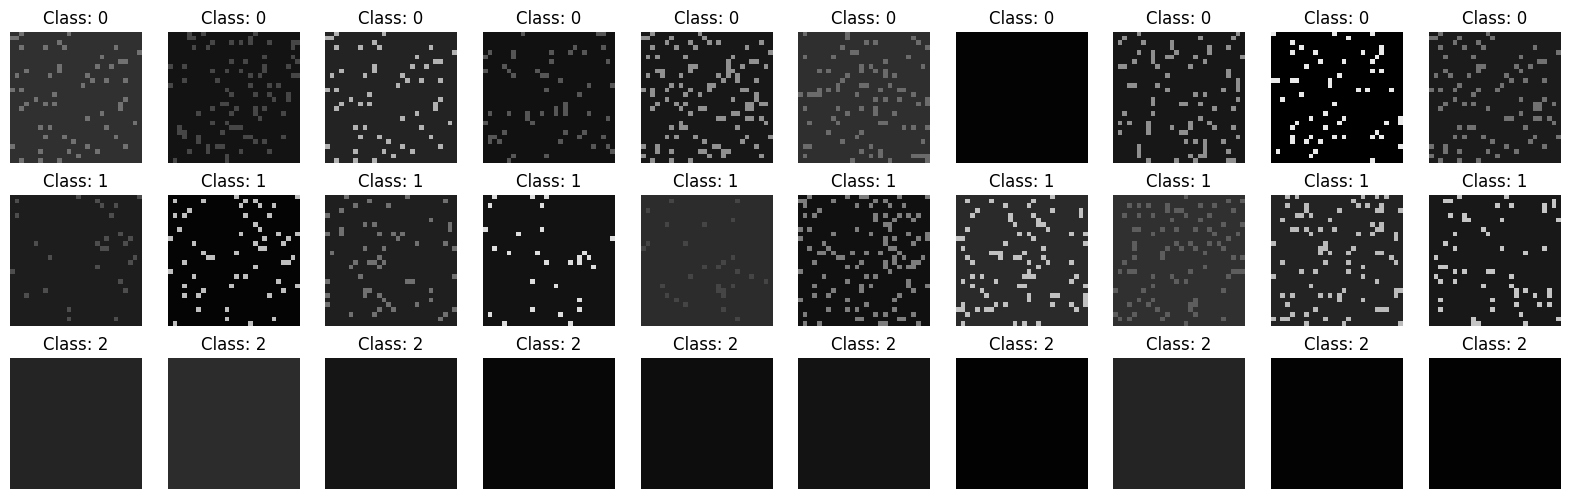

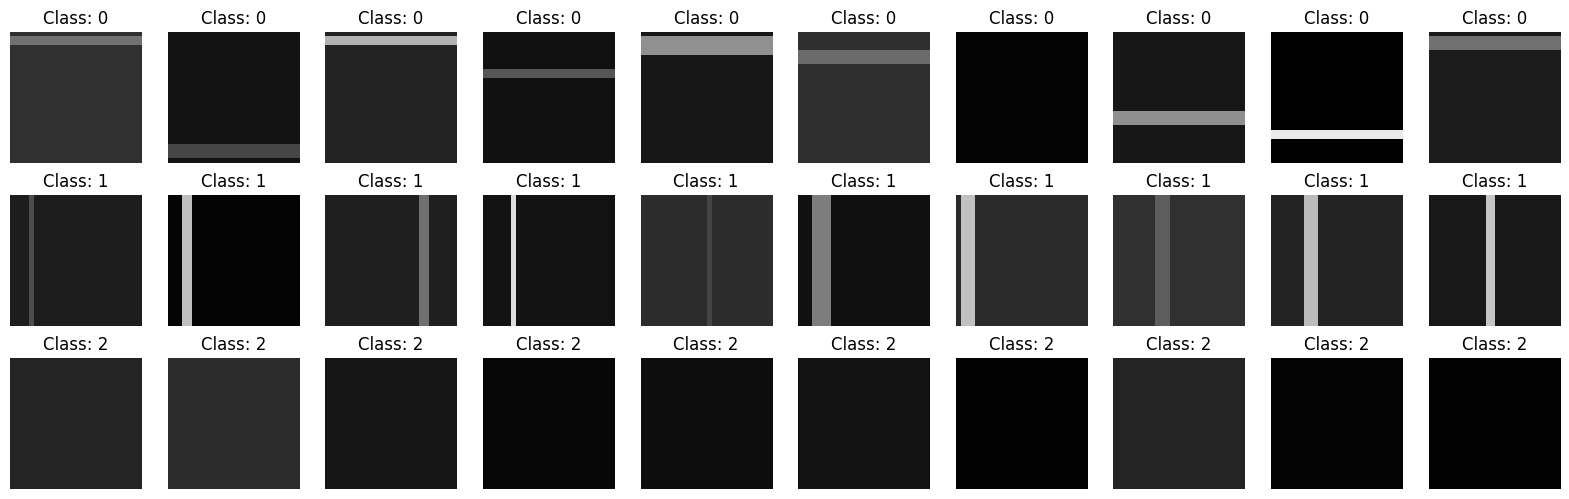

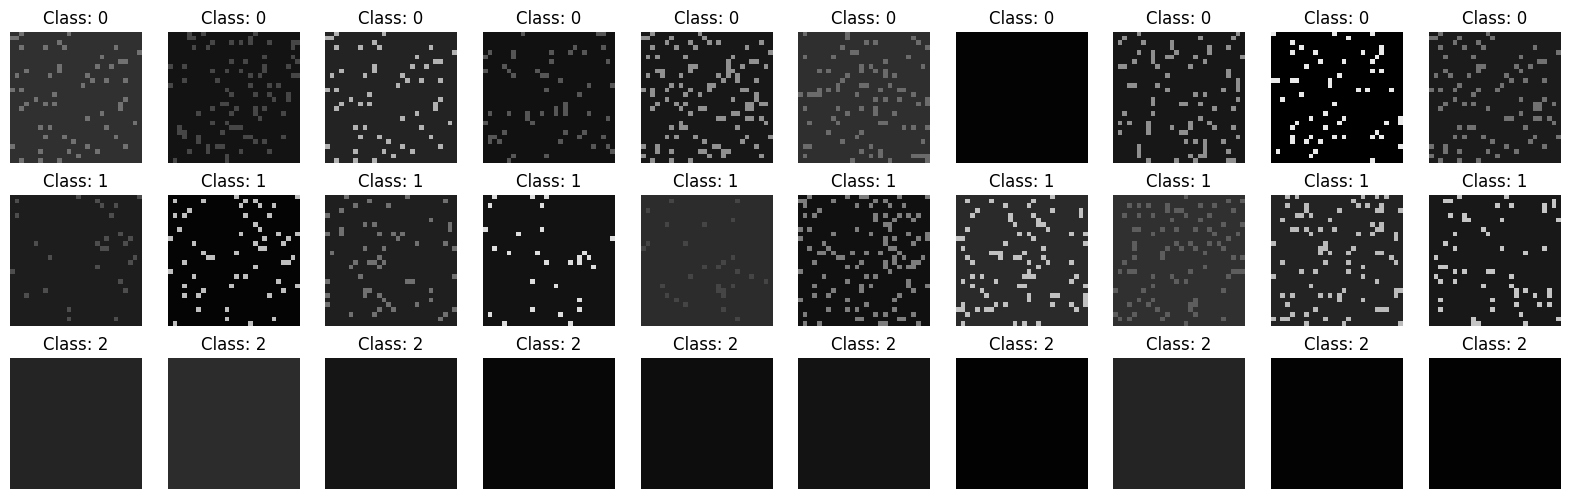

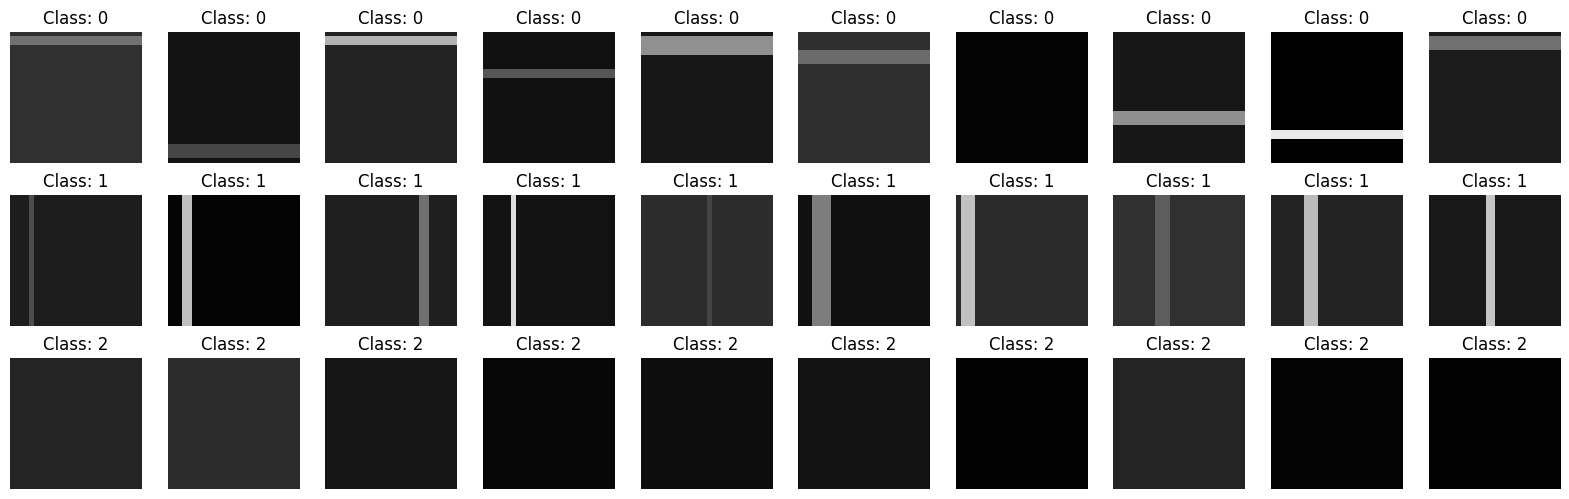

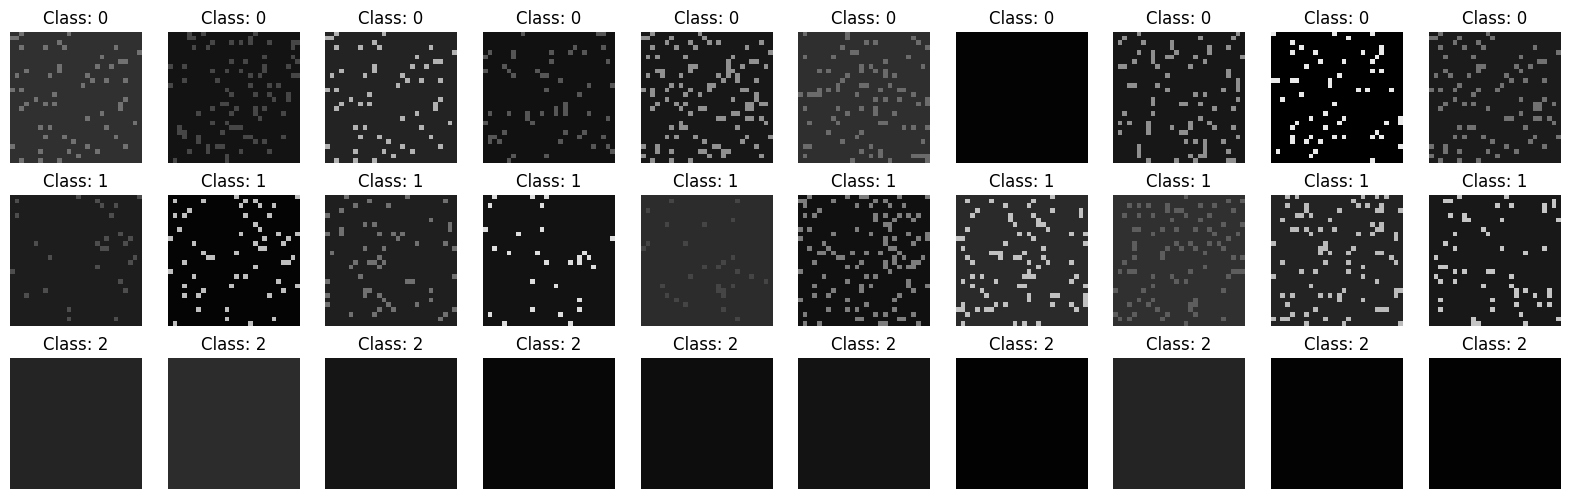

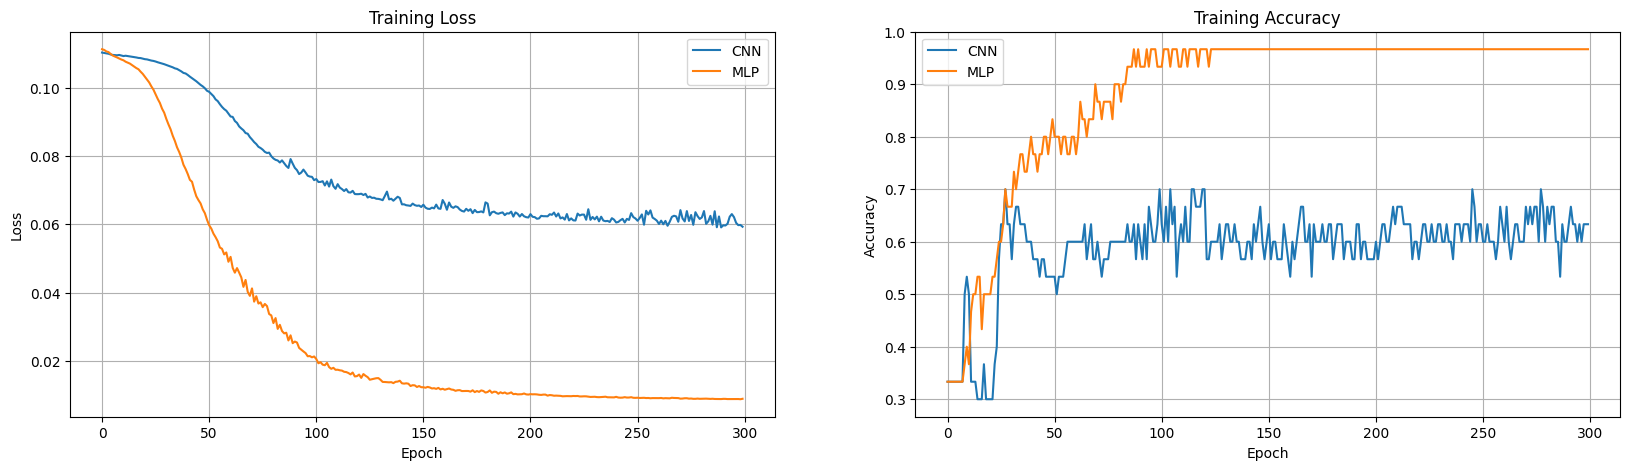

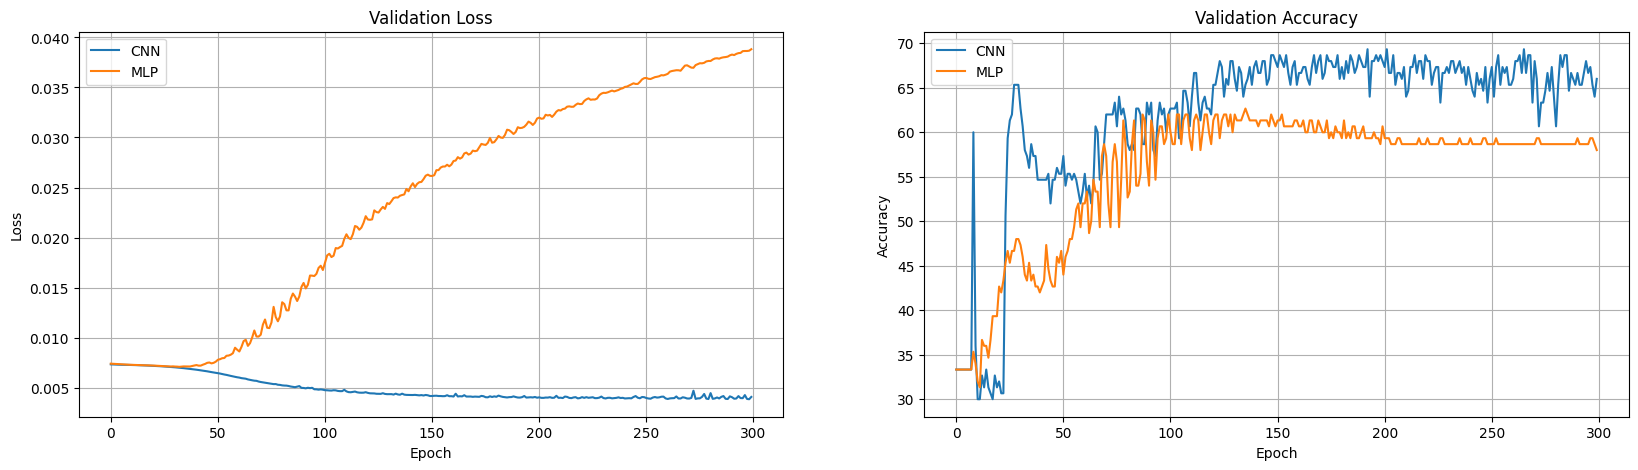

CNN Acc: 66.0, MLP Acc: 58.0
Training with 50 images


100%|██████████| 300/300 [00:35<00:00,  8.53it/s]


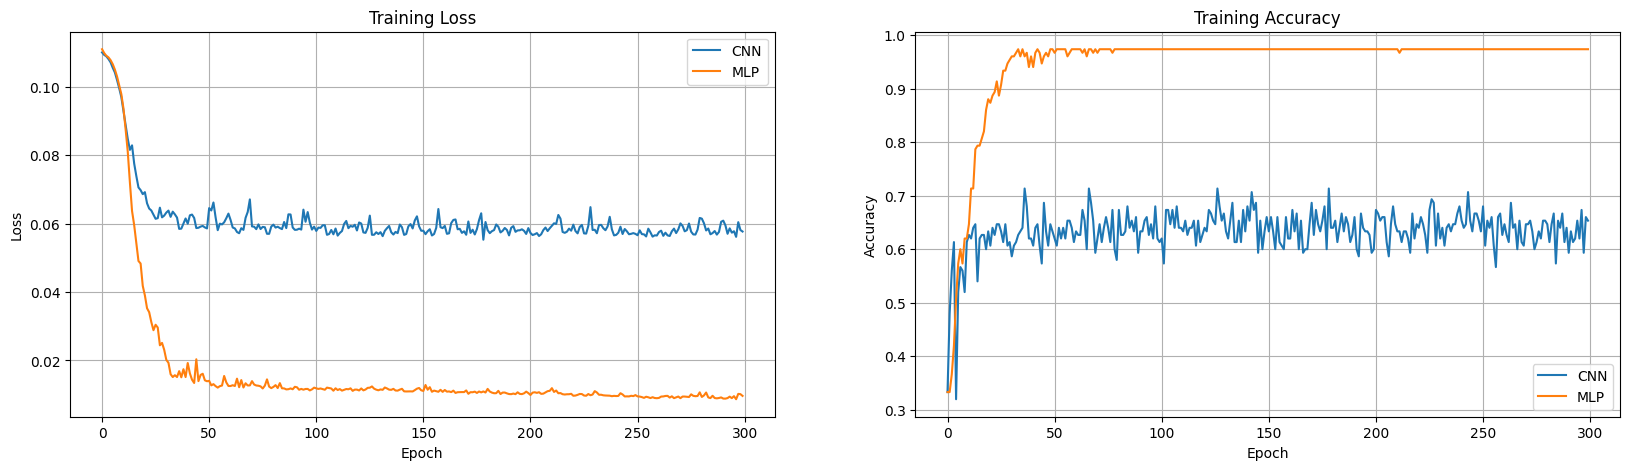

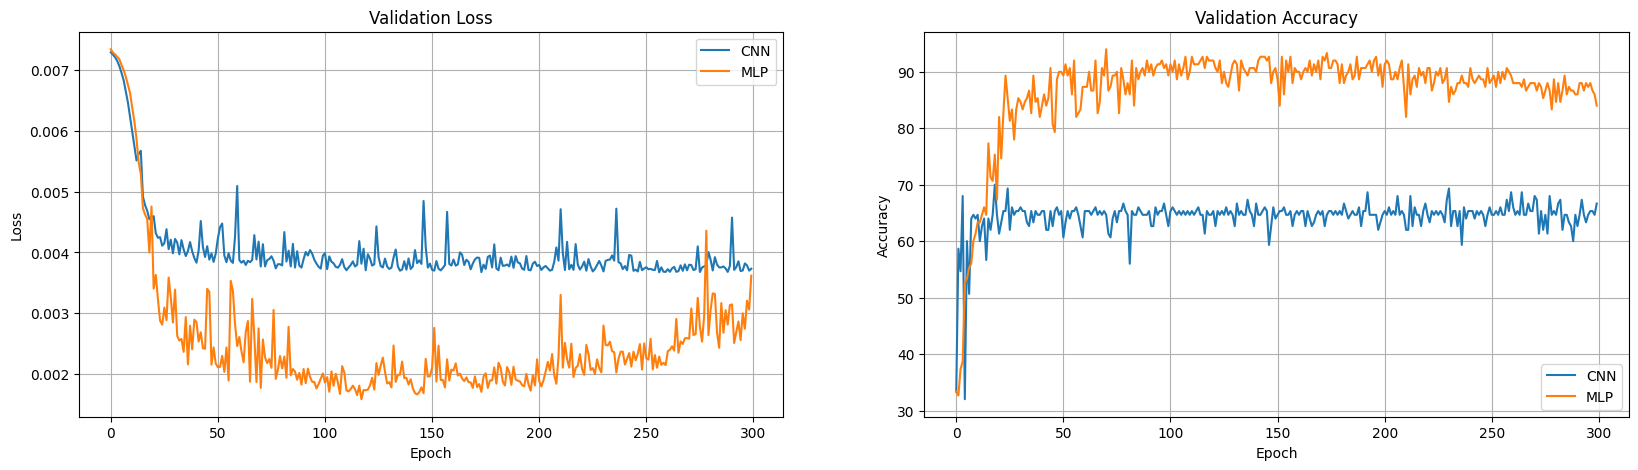

CNN Acc: 66.66666666666667, MLP Acc: 84.0
Training with 100 images


100%|██████████| 300/300 [00:57<00:00,  5.24it/s]


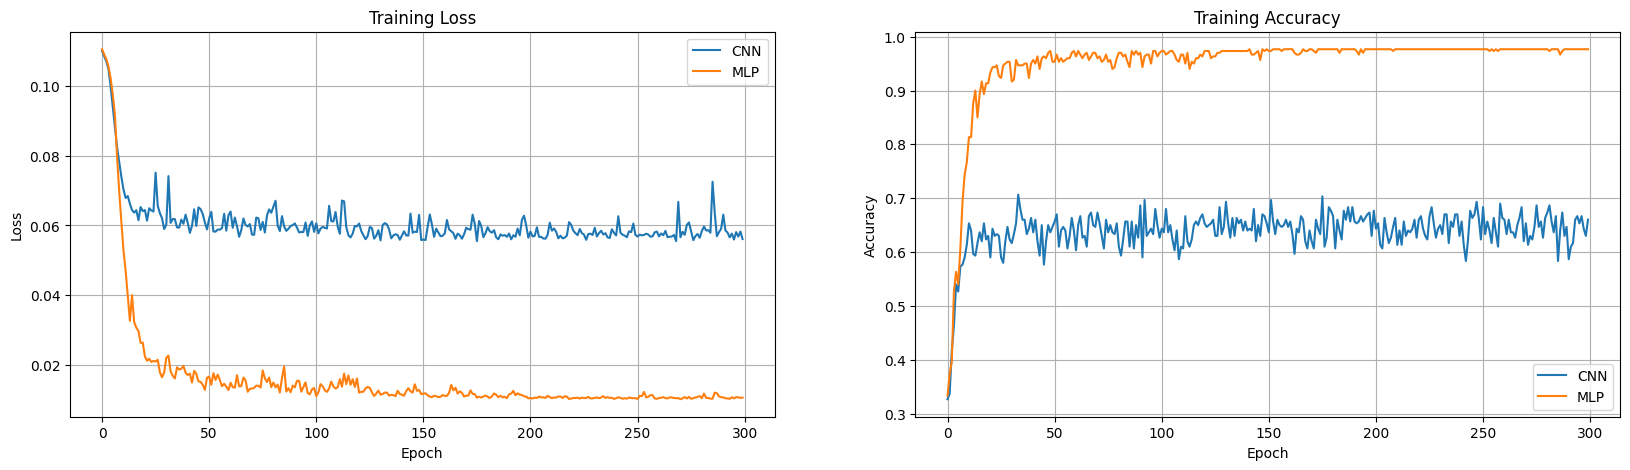

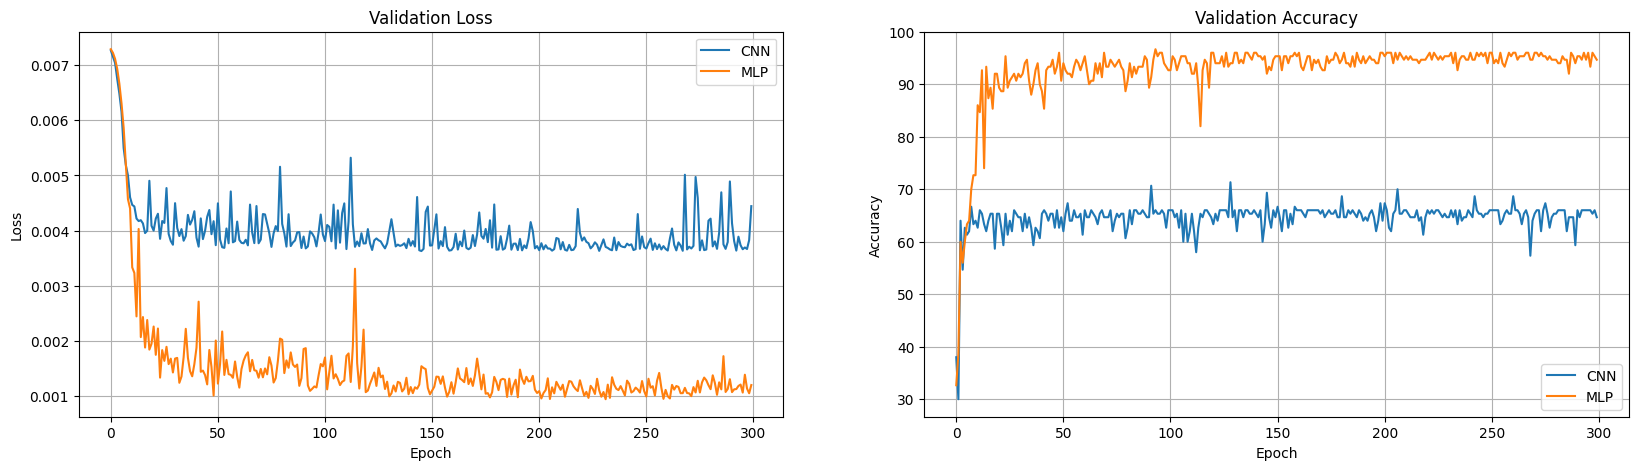

CNN Acc: 64.66666666666667, MLP Acc: 94.66666666666667
Training with 500 images


100%|██████████| 300/300 [03:59<00:00,  1.25it/s]


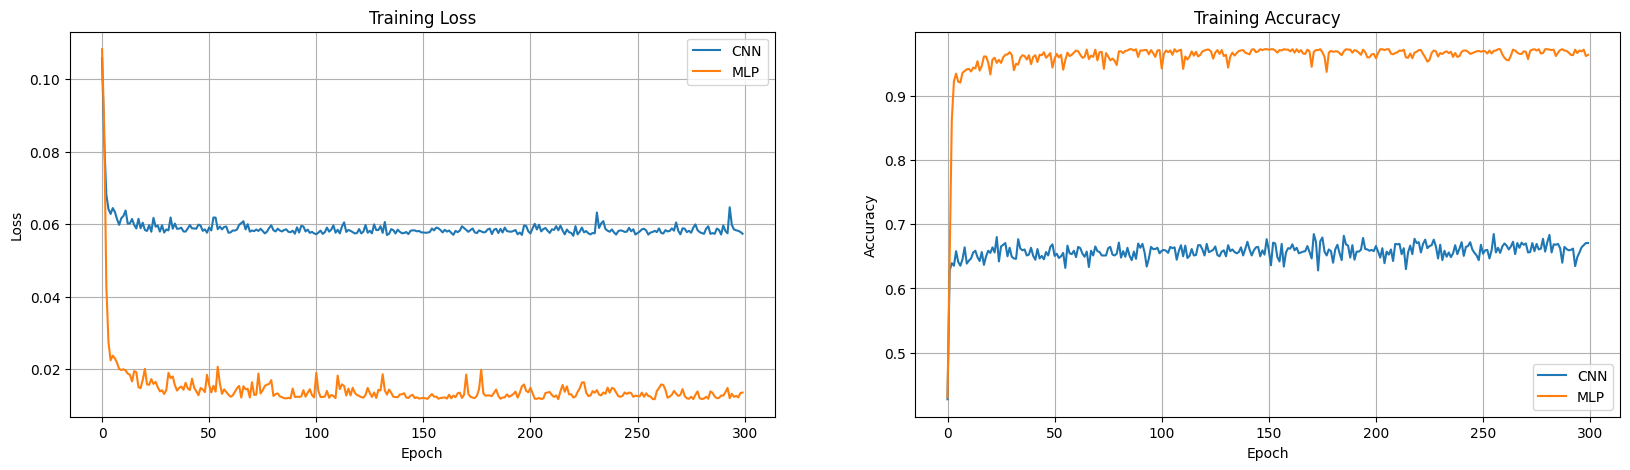

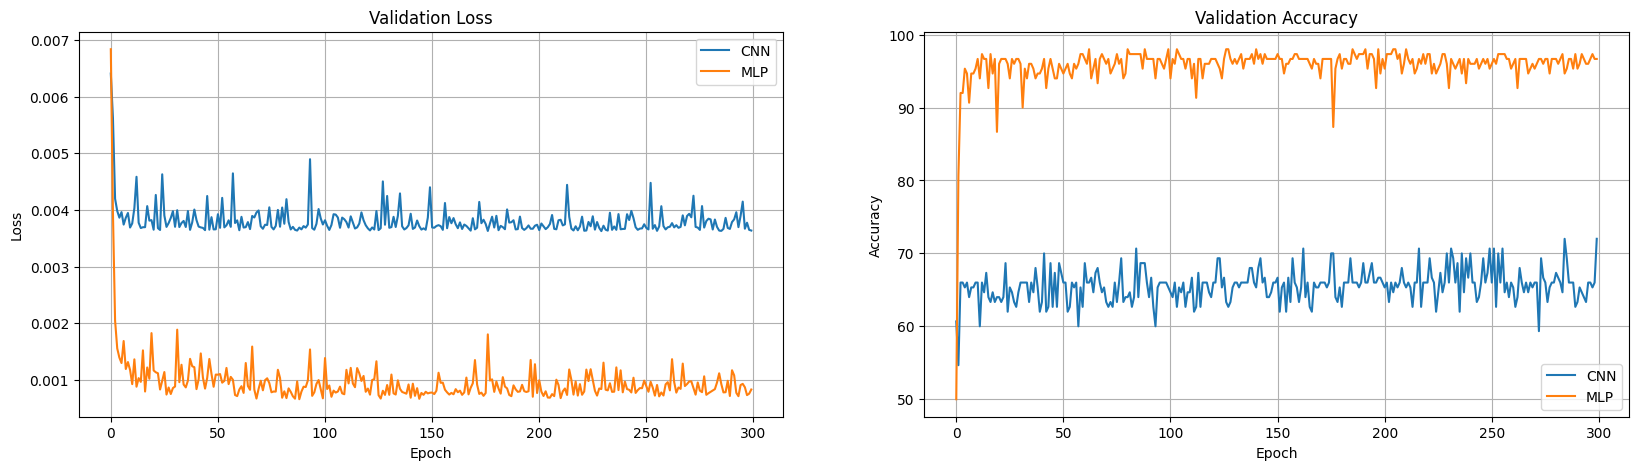

CNN Acc: 72.0, MLP Acc: 96.66666666666667


In [76]:
lr = 1e-2
num_epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict() 

cnn_confusion_matrix_dict = dict()
mlp_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=3)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    mlp_train_acc_list, mlp_valid_acc_list, mlp_train_loss_list, mlp_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, cnn_confusion_matrix = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        mlp_valid_loss, mlp_valid_acc, mlp_confusion_matrix = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        mlp_train_acc_list.append(mlp_train_acc)
        mlp_valid_acc_list.append(mlp_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
        mlp_train_loss_list.append(mlp_train_loss)
        mlp_valid_loss_list.append(mlp_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, mlp_train_loss_list, mlp_train_acc_list)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, mlp_valid_loss_list, mlp_valid_acc_list)

    cnn_acc = cnn_valid_acc_list[-1]
    mlp_acc = mlp_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    cnn_confusion_matrix_dict[num_image] = cnn_confusion_matrix
    mlp_confusion_matrix_dict[num_image] = mlp_confusion_matrix
    
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))
    cnn_acc_list.append(cnn_acc)
    mlp_acc_list.append(mlp_acc)

Q. What do you observe? What is the reason that CNN is worse than MLP? (Hint: Think about the model architecture.)

Q. Assuming we are increasing kernel size of CNN. Does the validation accuracy increase or decrease? Why?

Obervation: MLP does better than CNN. For this task, pixels are more like randomly distributed data. Each pixel doesn't have a strong relationship with its neighbours. Hence, CNN is prone to wrongly generalize features of data and wrongly classifies these pictures. On the contrary, MLP won't be confused by these randomly distributed points.

Now let's visualize CNN's learned kernel.

/home/cleverctz/berkeley/cs182_deeplearning/hw5/hw5/helpers/vis_helper.py:146: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap=cmap)


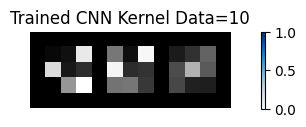

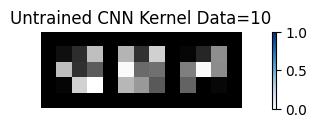

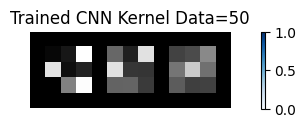

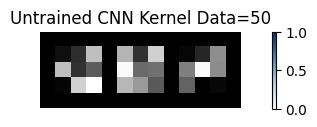

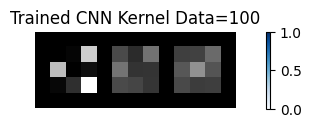

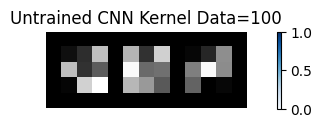

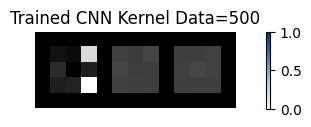

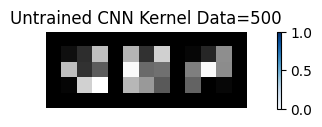

In [77]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Data={}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel Data={}'.format(num_image))

Q. How do the learned kernels look like? Explain why.

From the above example, we can see that CNN is not always better than MLP. We have to think about the domain (or task) of the dataset and the model architecture to decide which model is better. 

For Data = 500, two of the kernels have almost the same weight in their 9 locations. It just does average sum of the input. 
Reason: CNN is confused by the non-exisiting relationship between pixel and its neighbours.

### Q6. Increasing the Number of Classes

OK, can we conclude that CNN has the inductive bias that the model is translation invariant? Let's try other experiments. We make the task harder. In this problem, we increase the number of classes to 5. The new classes are 0 for horizontal edges, 1 for vertical edges, 2 for diagonal edges, 3 for vertical and horizontal, and 4 for nothing. Let's generate the dataset with 10 images per class and visualize the dataset.

In [78]:
set_seed(seed)
visual_domain_config = None

visual_dataset = None

transforms = T.Compose([T.ToTensor()])
#############################################################################
# TODO: Implement visual_dataset for this new domain                        #
# Hint: If you read docstring of EdgeDetectionDataset, you will find        #
# 'class_type' args. Pass ['horizontal', 'vertical', 'diagonal', 'both',    #
# 'none'] to 'class_type' args.                                             #
#############################################################################

visual_domain_config = dict(
    data_per_class=10,
    num_classes=5,
    class_type=['horizontal', 'vertical', 'diagonal', 'both',  'none'],
    # permutater = permutater,
    # unpermutater = unpermutater,
    # use_permutation = True
)
visual_dataset = EdgeDetectionDataset(visual_domain_config, mode='train', transform=transforms)
# train_loader_dict[f'{i}'] = torch.utils.data.DataLoader(dataset, train_batch_size, shuffle = True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Let's visualize the dataset first.

In [79]:
vis_dataset(visual_dataset, 5, 10)

Now let's make the new dataset. In this problem, we also see how the model performance changes as the number of images per class increases. Let's sweep the number of training images 10, 20, 30, 40, and 50. The validation set will be the same (50) for all the cases.

In [80]:
set_seed(seed)

train_dataset_config = None
train_loader_dict = dict()
num_train_images_list = [10, 20, 30, 40, 50]
valid_loader = None

transforms = T.Compose([T.ToTensor()])
batch_size = 10
#############################################################################
# TODO: Implement train_loader_dict for each number of training images.     #
# Key: The number of training images (10, 20, 30, 40 and 50)                #
# Value: The corresponding dataloader                                       #
# The validation set size is 50 images per class                            #
# Hint: class_type = ['horizontal', 'vertical', 'diagonal', 'both', 'none'] #
# Hint: Be careful about the number of classes                              #
#############################################################################
for i in num_images_list:
    dataset_config = dict(
    data_per_class=i,
    num_classes=5,
    class_type=['horizontal', 'vertical', 'diagonal', 'both',  'none'],
    # permutater = permutater,
    # unpermutater = unpermutater,
    # use_permutation = True
)
    dataset = EdgeDetectionDataset(dataset_config, mode='train', transform=transforms)
    train_loader_dict[f'{i}'] = torch.utils.data.DataLoader(dataset, train_batch_size, shuffle = True)


valid_config = dict(
    data_per_class=50,
    num_classes=5,
    class_type=['horizontal', 'vertical', 'diagonal', 'both',  'none'],
    # permutater = permutater,
    # unpermutater = unpermutater,
    # use_permutation = True
)
valid_dataset = EdgeDetectionDataset(valid_config, mode='valid', transform=transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, valid_batch_size, shuffle = True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Training with 10 images


100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


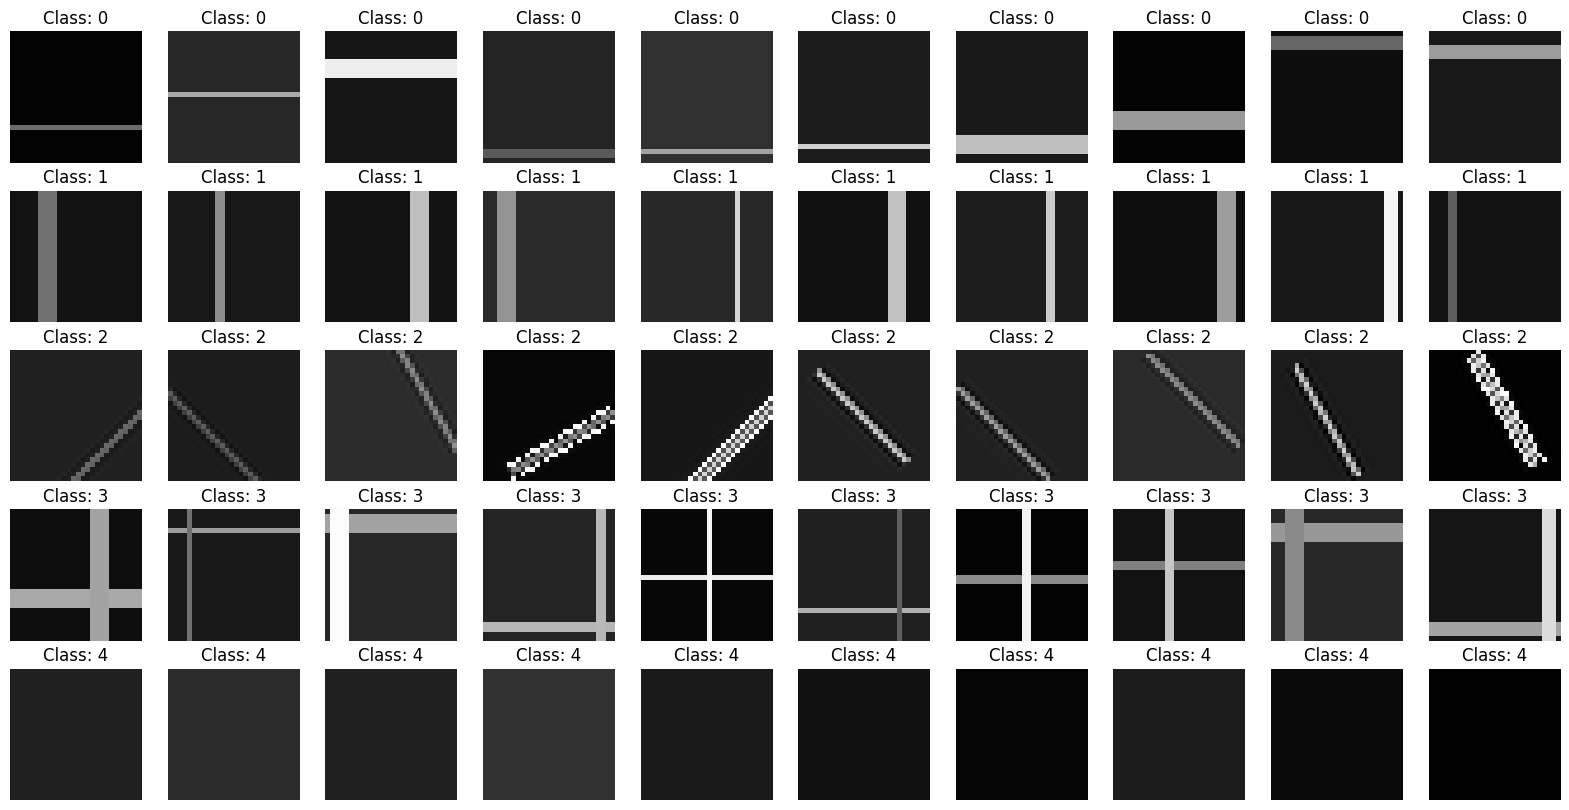

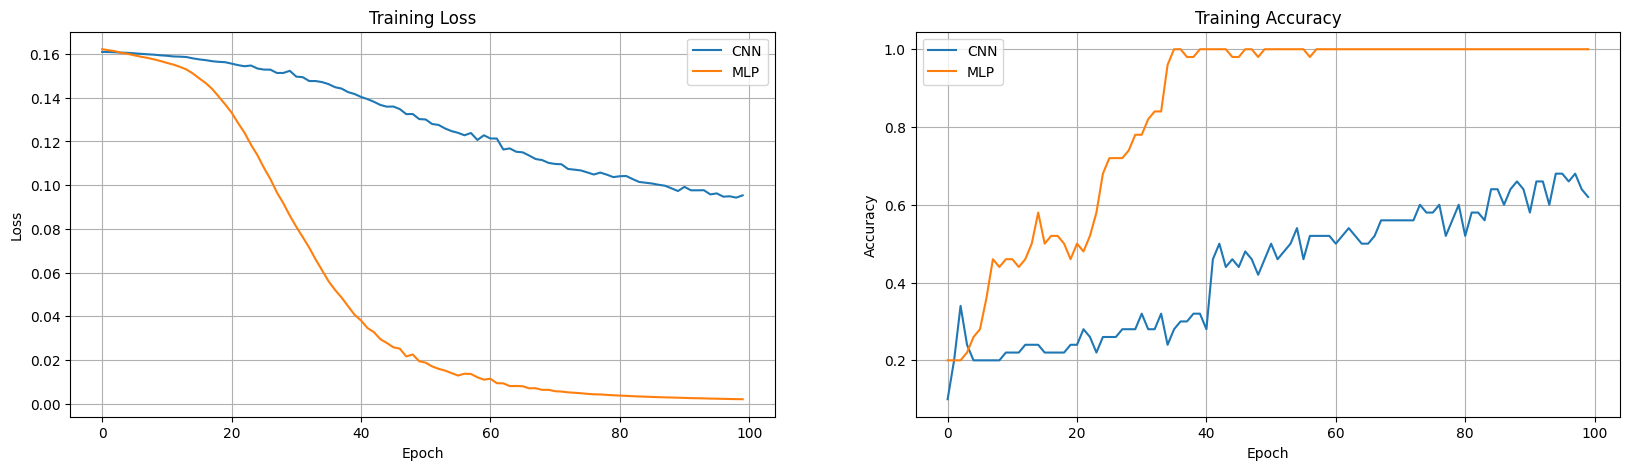

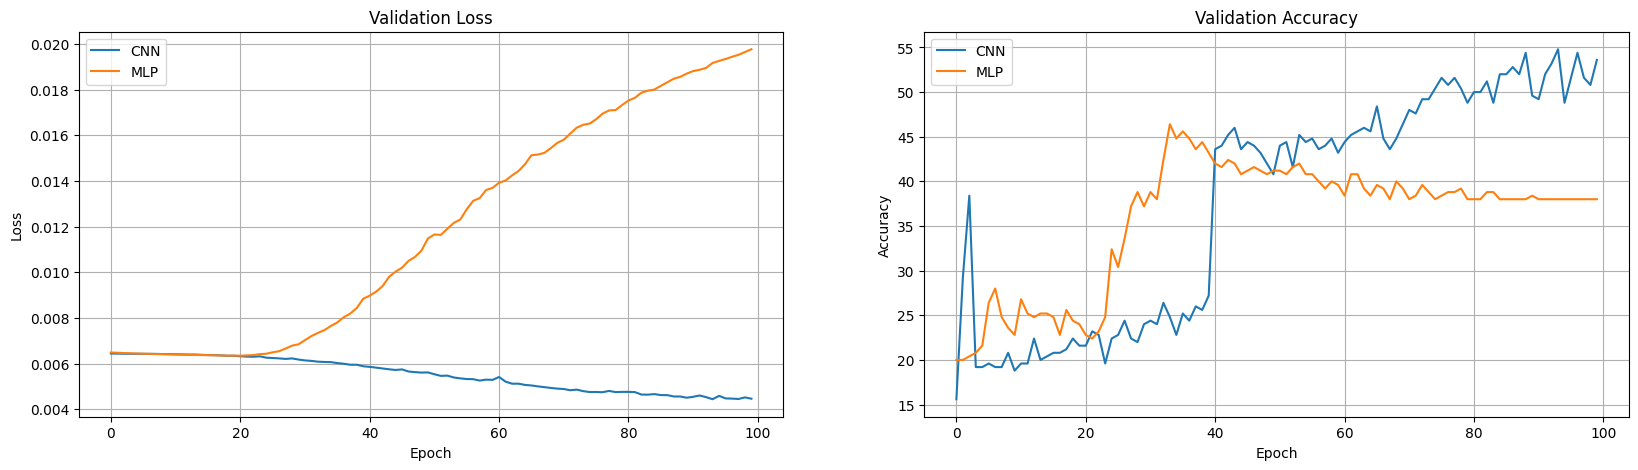

CNN Acc: 53.6, MLP Acc: 38.0
Training with 50 images


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


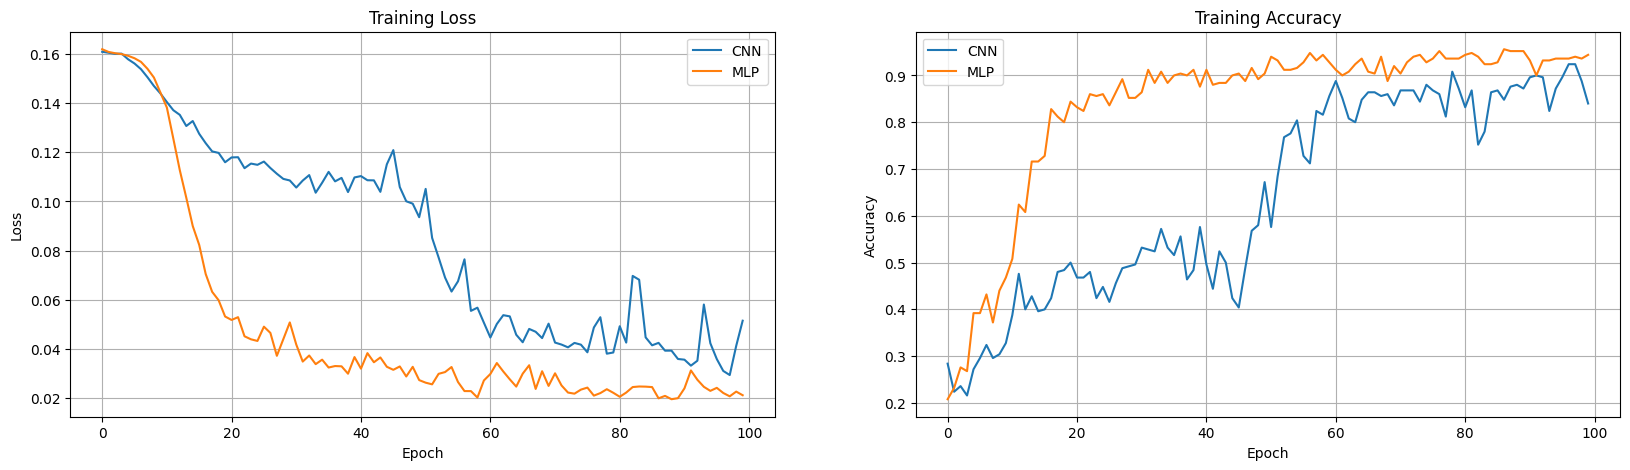

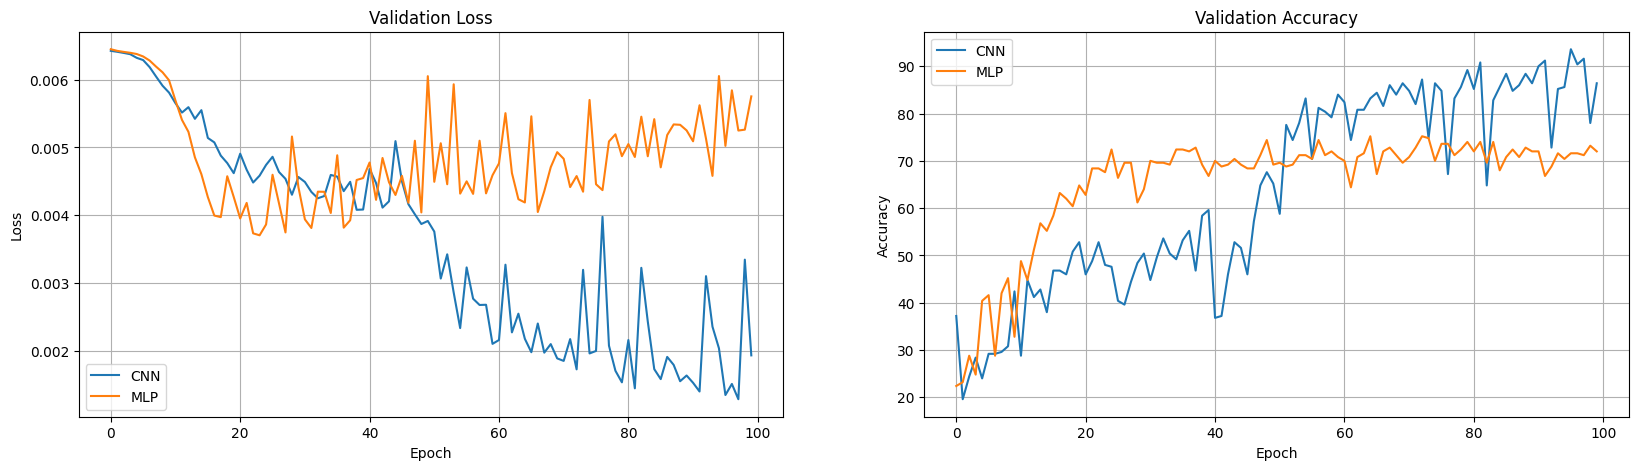

CNN Acc: 86.4, MLP Acc: 72.0
Training with 100 images


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


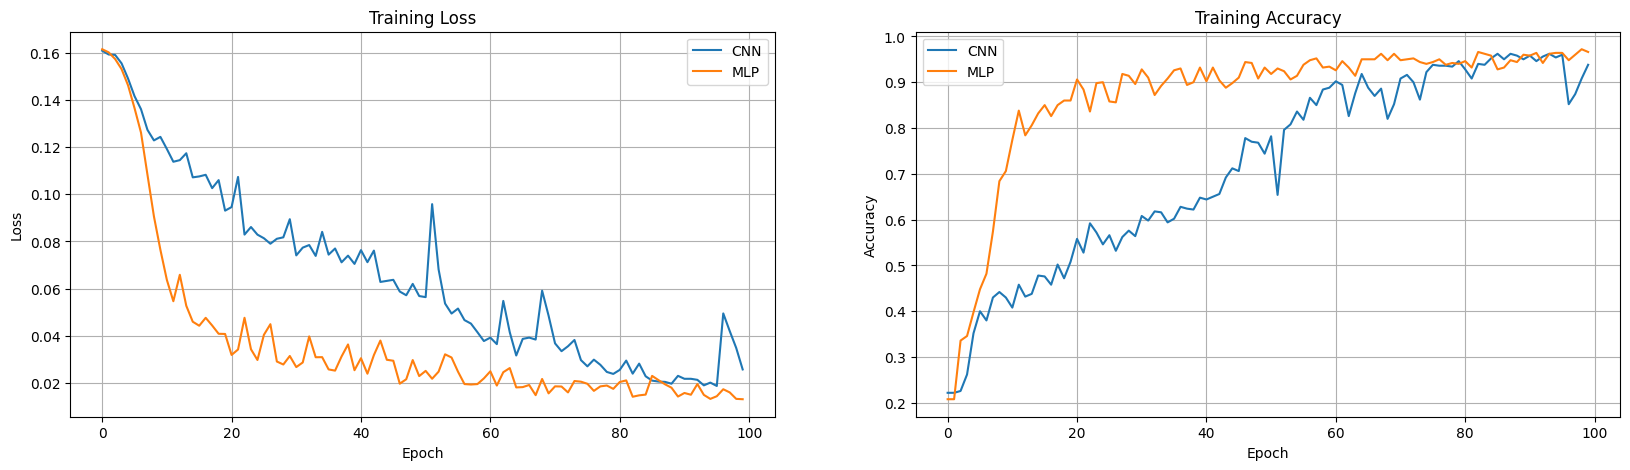

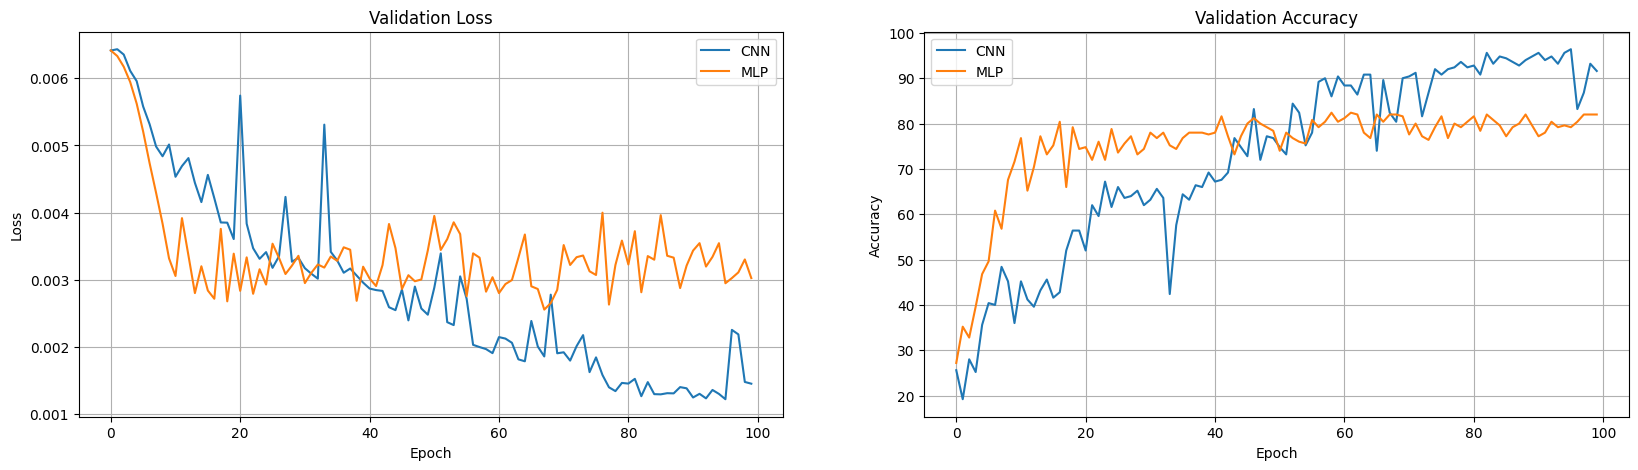

CNN Acc: 91.6, MLP Acc: 82.0
Training with 500 images


100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


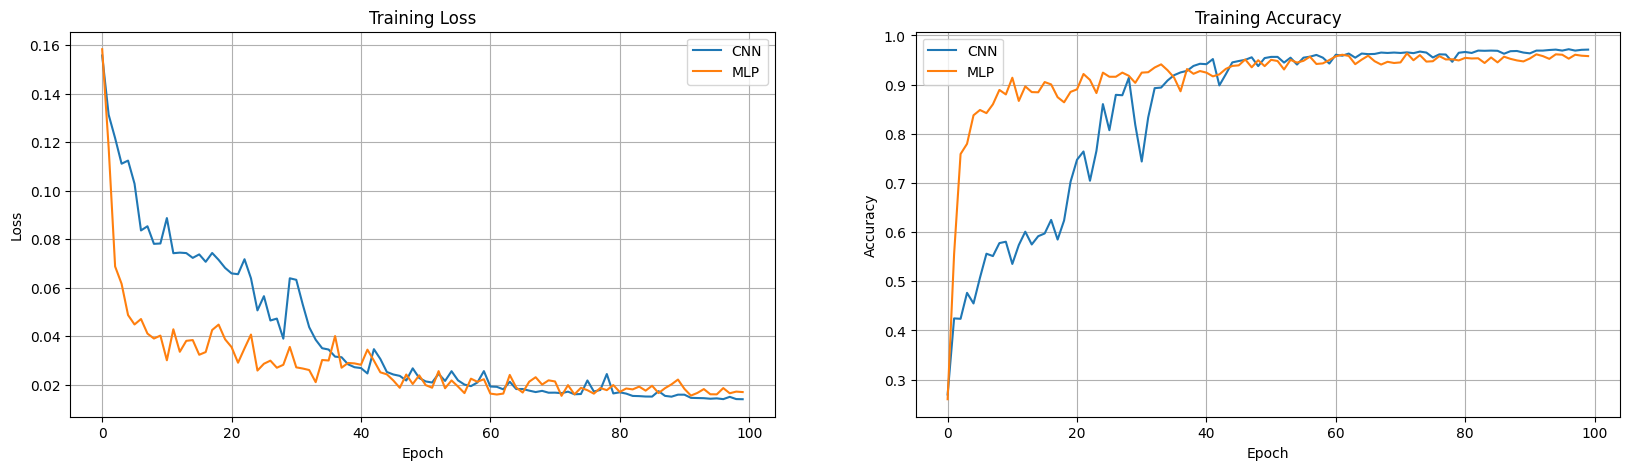

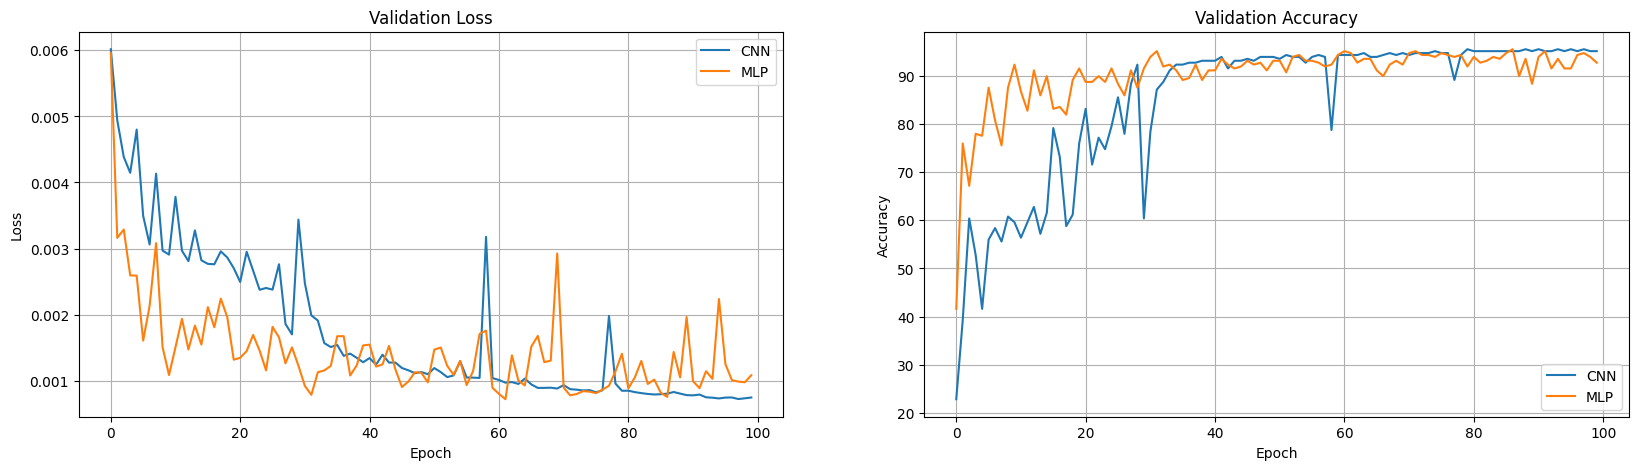

CNN Acc: 95.2, MLP Acc: 92.8


In [81]:
lr = 1e-2
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict() 

cnn_confusion_matrix_dict = dict()
mlp_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7, num_classes=5)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10], num_classes=5)
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    mlp_train_acc_list, mlp_valid_acc_list, mlp_train_loss_list, mlp_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        mlp_train_loss, mlp_train_acc = train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, cnn_confusion_matrix = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
        mlp_valid_loss, mlp_valid_acc, mlp_confusion_matrix = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        mlp_train_acc_list.append(mlp_train_acc)
        mlp_valid_acc_list.append(mlp_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
        mlp_train_loss_list.append(mlp_train_loss)
        mlp_valid_loss_list.append(mlp_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, mlp_train_loss_list, mlp_train_acc_list)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, mlp_valid_loss_list, mlp_valid_acc_list)

    cnn_acc = cnn_valid_acc_list[-1]
    mlp_acc = mlp_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    cnn_confusion_matrix_dict[num_image] = cnn_confusion_matrix
    mlp_confusion_matrix_dict[num_image] = mlp_confusion_matrix
    
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))
    cnn_acc_list.append(cnn_acc)
    mlp_acc_list.append(mlp_acc)

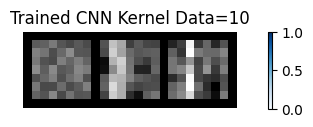

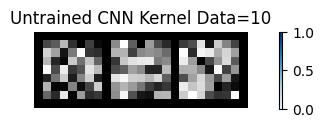

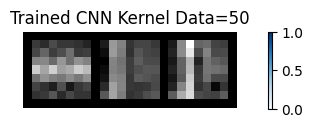

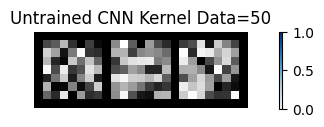

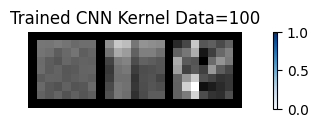

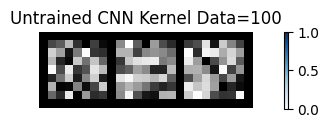

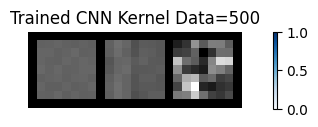

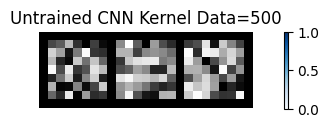

In [82]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Data={}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel Data={}'.format(num_image))

(Optional) Ok, CNN performs pretty good. But what if we increase the width or the depth of CNN? The patterns that we have to detect are 5 but our kernels per layer are only 3. Intuitively, this is quite a suboptimal. Here, we will investigate the affect of increasing width and depth. Let's use the same dataset but we will use ```DeeperCNN``` and ```WiderCNN``` in ```cnn.py```. ```DeeperCNN``` has 2 times more layers than ```SimpleCNN``` and ```WiderCNN``` has 2 times more kernels per layer than ```SimpleCNN```. Let's train the models and visualize the validation accuracy. 

In [ ]:
#############################################################################
# TODO: Training DeeperCNN and tuning hyperparameters Try other num_epochs, #
# lr, kernel_size. The validation accuracy                                  #
#############################################################################
lr = None
num_epochs = None
kernel_size = None
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_valid_acc_list = list()

cnn_kernel_dict = dict()

cnn_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = DeeperCNN(kernel_size=kernel_size)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, cnn_confusion_matrix = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, None, None)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, None, None)

    cnn_acc = cnn_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    cnn_confusion_matrix_dict[num_image] = cnn_confusion_matrix
    
    print("CNN Acc: {}".format(cnn_acc))
    cnn_acc_list.append(cnn_acc)

In [ ]:
#############################################################################
# TODO: Training WiderCNN and tuning hyperparameters Try other num_epochs,  #
# lr, kernel_size. The validation accuracy                                  #
#############################################################################
lr = None
num_epochs = None
kernel_size = None
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_valid_acc_list = list()

cnn_kernel_dict = dict()

cnn_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = WiderCNN(kernel_size=kernel_size)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    cnn_train_acc_list, cnn_valid_acc_list, cnn_train_loss_list, cnn_valid_loss_list = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)

        cnn_valid_loss, cnn_valid_acc, cnn_confusion_matrix = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)

        cnn_train_acc_list.append(cnn_train_acc)
        cnn_valid_acc_list.append(cnn_valid_acc)
        cnn_train_loss_list.append(cnn_train_loss)
        cnn_valid_loss_list.append(cnn_valid_loss)
    
    vis_training_curve(cnn_train_loss_list, cnn_train_acc_list, None, None)
    vis_validation_curve(cnn_valid_loss_list, cnn_valid_acc_list, None, None)

    cnn_acc = cnn_valid_acc_list[-1]

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    cnn_confusion_matrix_dict[num_image] = cnn_confusion_matrix
    
    print("CNN Acc: {}".format(cnn_acc))
    cnn_acc_list.append(cnn_acc)